# AQMP Optimization 

In [15]:
import sys
import os
from datetime import datetime
import time
import pickle
import pandas as pd

sys.path.append(os.path.abspath(os.path.join('..')))

import numpy as np
from codec import ImageCompressor
import warnings
from skimage import io, img_as_float
from skimage.metrics import structural_similarity as ssim

import plotly
from plotly.io import show
import matplotlib.pyplot as plt
from PIL import Image
import optuna
from optuna.samplers import TPESampler

# After running the trials, plot the results for each (n_min, n_max) pair
def plot_results(study, plot_name="test", log_xscale=False):
    ## 1st plot
    plt.figure(figsize=(10, 6))
    ssim_values = []
    compression_rates = []
    for trial in study.trials:
        ssim_values.append(trial.user_attrs["ssim_values"])
        compression_rates.append(trial.user_attrs["compression_rate"])
    
    plt.plot(compression_rates, ssim_values, "o") # ,label=f"({n_min}, {n_max})")
    plt.xlabel('Compression Rate')
    plt.ylabel('SSIM Index')
    if log_xscale == True:
        plt.xscale("log")
    plt.grid(True)
    plt.show()
    
    ## 2nd plot
    # Extract all SSIM and Compression Rate values from trials
    ssim_values = [trial.values[0] for trial in study.trials if trial.values]
    compression_values = [trial.values[1] for trial in study.trials if trial.values]
    # Sort Pareto front for connected plotting
    pareto_front = sorted(study.best_trials, key=lambda t: t.values[0])  # Sort by SSIM or another objective
    # Extract values for only Pareto-optimal solutions
    pareto_ssim = [trial.values[0] for trial in pareto_front]
    pareto_compression = [trial.values[1] for trial in pareto_front]
    print("results for image ", image_name)
    plt.figure(figsize=(10, 6))
    plt.scatter(ssim_values, compression_values, color="grey", label="All Trials")
    plt.plot(pareto_ssim, pareto_compression, 'o--', color="red", label="Pareto Front", markersize=6)
    plt.ylabel("SSIM")
    plt.title("Pareto Front for SSIM and Compression Rate for " + image_name)
    plt.xlabel("Compression Rate")
    plt.xscale("log")
    plt.legend()
    plt.grid(True)
    plt.savefig("../images/hpo/"+ plot_name +".png")    

test_images = ["Clock",
               "San_Diego",
               "Splash",
               "Sailboat_on_lake",
               "Stream_and_bridge",
               "Female_(NTSC_test_image)",
               "Peppers",
               "Mandrill_(a.k.a._Baboon)"
              ]

lena_size = os.path.getsize("../images/lena.png")

# Some Lenna results

- min_sparcity: porcentaje máximo de coeficientes diferentes de cero permitidos en un cuadrante. Si no se cumple, se particiona en cuatro nuevos cuadrantes.
- max_error: ('tol' argument of OMP) Maximum squared norm of the residual.

In [3]:
results = {}
lena_size = os.path.getsize("../images/lena.png")

def objective(trial):
    min_sparcity = trial.suggest_float('min_sparcity', 0.01, 1)
    exponent_min_n = trial.suggest_int('exponent_min_n', 2, 7)
    exponent_max_n = trial.suggest_int('exponent_max_n', exponent_min_n, 7)
    a_cols = trial.suggest_categorical("a_cols", [64, 128, 256])
    max_error = trial.suggest_float('max_error', 0.001, 1000, log = True )
    
    min_n = 2**exponent_min_n
    max_n = 2**exponent_max_n
    print(max_n, min_n)
    assert max_n >= min_n

    # Use the (n_min, n_max) pair as the key in the results dictionary
    pair_key = (min_n, max_n)
    
    if pair_key not in results:
        results[pair_key] = {'ssim_values': [], 'compression_rates': []}

    # ENCODE
    newCodec = ImageCompressor(min_sparcity,
                               min_n,
                               max_n,
                               a_cols,
                               max_error)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        newCodec.encode(input_file="../images/lena.png",
                        output_file="../compressions/lena_compressed.fif")

    # DECODE
    newCodec.decode(input_file="../compressions/lena_compressed.fif",
                    output_file="../images/lena_reconstructed.png")

    # CALCULATE SSIM
    image1 = img_as_float(io.imread('../images/lena.png', as_gray=True))
    image2 = img_as_float(io.imread('../images/lena_reconstructed.png', as_gray=True))
    ssim_index, _ = ssim(image1, image2, full=True, data_range=image1.max() - image1.min())
    
    # Record SSIM value for this pair
    results[pair_key]['ssim_values'].append(ssim_index)
    print(f"SSIM Index for ({min_n}, {max_n}): {ssim_index}\n")

    # COMPRESSION RATE
    compressed_lena_size = os.path.getsize('../images/lena_reconstructed.png')
    compression_rate = lena_size / compressed_lena_size
    
    # Record compression rate for this pair
    results[pair_key]['compression_rates'].append(compression_rate)

    return compression_rate

In [4]:
lena_size = os.path.getsize("../images/lena.png")
results = {}
def objective(trial):
    min_sparcity = trial.suggest_float('min_sparcity', 0.01, 1)
    exponent_min_n = trial.suggest_int('exponent_min_n', 2, 7)
    exponent_max_n = trial.suggest_int('exponent_max_n', exponent_min_n, 7)
    max_error = trial.suggest_float('max_error', 0.001, 1000, log = True )
    
    min_n = 2**exponent_min_n
    max_n = 2**exponent_max_n
    print(max_n, min_n)
    assert max_n >= min_n

    # Use the (n_min, n_max) pair as the key in the results dictionary
    pair_key = (min_n, max_n)
    
    if pair_key not in results:
        results[pair_key] = {'ssim_values': [], 'compression_rates': []}

    # ENCODE
    newCodec = ImageCompressor(min_sparcity = min_sparcity,
                               min_n = min_n,
                               max_n = max_n,
                               max_error = max_error,
                               a_cols = 32
                              )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        newCodec.encode(input_file="../images/lena.png",
                        output_file="../compressions/lena_compressed.fif")

    # DECODE
    newCodec.decode(input_file="../compressions/lena_compressed.fif",
                    output_file="../images/lena_reconstructed.png")

    # CALCULATE SSIM
    image1 = img_as_float(io.imread('../images/lena.png', as_gray=True))
    image2 = img_as_float(io.imread('../images/lena_reconstructed.png', as_gray=True))
    ssim_index, _ = ssim(image1, image2, full=True, data_range=image1.max() - image1.min())
    
    # Record SSIM value for this pair
    results[pair_key]['ssim_values'].append(ssim_index)
    print(f"SSIM Index for ({min_n}, {max_n}): {ssim_index}\n")

    # COMPRESSION RATE
    compressed_lena_size = os.path.getsize('../images/lena_reconstructed.png')
    compression_rate = lena_size / compressed_lena_size
    
    # Record compression rate for this pair
    results[pair_key]['compression_rates'].append(compression_rate)

    return compression_rate

In [5]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
study_name = f"aqmp_optuna_study_{current_time}"

sampler = TPESampler(seed=42)  # Make the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', study_name=study_name, sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-11-16 11:23:43,512] A new study created in memory with name: aqmp_optuna_study_2024-11-16_11-23-43


128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:23:47,517] Trial 0 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.3807947176588889, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 24.658329458549105}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3568895
File saved.


[I 2024-11-16 11:25:34,908] Trial 1 finished with value: 0.9780782782985276 and parameters: {'min_sparcity': 0.6026718993550663, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.002231010801867922}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.996401159268659

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:25:39,162] Trial 2 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8675143843171859, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.0013289448722869186}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:25:42,401] Trial 3 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.9702107536403743, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.012329623163659839}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3984239171038933

32 8
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:25:46,978] Trial 4 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.1915704647548995, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.3905441275210791}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 32): 0.42608836930259947

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:25:51,523] Trial 5 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.2983168487960615, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.05660670699258887}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.42608836930259947

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:25:55,791] Trial 6 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.37269822486075477, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.01577766363058246}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.40349624916963595

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:26:00,483] Trial 7 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.5190920940294755, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 4.418441521199722}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.42608836930259947

128 4
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:26:04,735] Trial 8 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.17881888245041863, 'exponent_min_n': 2, 'exponent_max_n': 7, 'max_error': 622.0025976819159}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 128): 0.40349624916963595

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 1270092
File saved.


[I 2024-11-16 11:26:43,100] Trial 9 finished with value: 1.2964231677387406 and parameters: {'min_sparcity': 0.8103133746352965, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 12.746711578215052}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.8607151773078684

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:26:46,978] Trial 10 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.05186710917452314, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 142.23511490271545}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:26:50,821] Trial 11 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6959647487096554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.072062770507817}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:26:54,987] Trial 12 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9772569037284843, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3087708226714937}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:26:59,162] Trial 13 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.41169982361211305, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.687360478919045}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:02,557] Trial 14 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.7541845370801955, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.001114076061818741}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:06,379] Trial 15 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5555567307930065, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 74.35827188879385}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:09,712] Trial 16 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.8644297040604267, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 679.3220420187774}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.3984239171038933

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:13,855] Trial 17 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6573796598009694, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.2171316028571613}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:17,198] Trial 18 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.40386890323979924, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.20862044720216466}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:21,054] Trial 19 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.24913938365053662, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 12.972618567849958}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:24,403] Trial 20 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.023008912560630312, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 96.36844547614447}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:27,758] Trial 21 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.4079124914166146, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.008005837104411072}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:32,049] Trial 22 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.3276416768336191, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.016597580209720696}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:36,349] Trial 23 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.46483740117046, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.0031949992564712466}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.40349624916963595

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 303410
File saved.


[I 2024-11-16 11:27:47,570] Trial 24 finished with value: 1.9270509671227083 and parameters: {'min_sparcity': 0.15016839923582764, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.044693443890700506}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.6410648313120781

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:51,785] Trial 25 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.3316391391449611, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0011449816173528565}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:27:56,050] Trial 26 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.4618962175922097, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.05138042298177373}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:27:59,398] Trial 27 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.8719217211404205, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.004515739613368305}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:28:03,631] Trial 28 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6061244904476757, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.021635752951422955}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 1270092
File saved.


[I 2024-11-16 11:28:42,321] Trial 29 finished with value: 1.2964231677387406 and parameters: {'min_sparcity': 0.592867090230501, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.13810958435578885}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 8): 0.8607151773078684

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:28:46,507] Trial 30 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.252303028603456, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0028897482463332205}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 747985
File saved.


[I 2024-11-16 11:29:36,204] Trial 31 finished with value: 1.5310058483311253 and parameters: {'min_sparcity': 0.0923832458983167, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 596.6518762553054}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.8789950396921834

64 4
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:29:39,666] Trial 32 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.17398993134389892, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 241.99775381505876}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 64): 0.3984239171038933

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:29:43,072] Trial 33 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.11300831490830376, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 40.62830761911113}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

32 4
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:29:47,663] Trial 34 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.23389088333726368, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 263.66556327815954}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 32): 0.42608836930259947

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:29:51,021] Trial 35 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.33617581701458804, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 6.013473283689714}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:29:54,832] Trial 36 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.38158613634770805, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8648234410108676}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:29:59,169] Trial 37 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.4968651050964025, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.007594964484750085}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

32 8
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:30:03,877] Trial 38 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.2750658231130657, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 983.7115719575471}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 32): 0.42608836930259947

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:08,171] Trial 39 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.2066105830428214, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 32.521478102525066}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.40349624916963595

32 4
processed_blocks: 768
bytes_written (without DEFLATE): 73562
File saved.


[I 2024-11-16 11:30:12,956] Trial 40 finished with value: 3.8430986098269178 and parameters: {'min_sparcity': 0.7208140190381007, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 2.0674596332505293}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 32): 0.42608836930259947

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:16,769] Trial 41 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.018829109153958135, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 256.1015700926908}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:20,606] Trial 42 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.08417476973486761, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 96.42473423628186}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:24,764] Trial 43 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.05721163767318625, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 140.5733403533762}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:28,763] Trial 44 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.1368993638025529, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 12.743720898325039}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:32,920] Trial 45 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8845384177199289, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 373.33563698344545}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:36,750] Trial 46 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.18446500226253149, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 62.90286571111985}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:40,909] Trial 47 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9258752030635327, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.10917796031517372}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:45,054] Trial 48 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.7912168915819551, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0015007778242363949}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:48,918] Trial 49 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5349316361305396, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 19.57388770613719}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:53,191] Trial 50 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.29874976084181876, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.577714621664576}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:30:57,130] Trial 51 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6903714237865339, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 5.712209998221527}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:01,801] Trial 52 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8197100192912204, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 161.52868741275884}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:05,848] Trial 53 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9511963370195402, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 48.722581379947606}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:10,118] Trial 54 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6537554216065806, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 18.97348310690171}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:14,326] Trial 55 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.4460179812677668, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 615.965630308475}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:31:17,934] Trial 56 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.38952020465967585, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.03034291704444686}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:22,673] Trial 57 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9891987888016882, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.126022501934914}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:31:26,157] Trial 58 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.7574342509563283, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 0.006578545643951104}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:30,590] Trial 59 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5836629846369064, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 10.006049327484845}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:34,607] Trial 60 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.35670402292324177, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 402.36259446447747}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:38,992] Trial 61 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9305044294688077, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.07689476637459636}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:43,253] Trial 62 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8336501738471546, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0150823201344659}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:48,279] Trial 63 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.893229426691526, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.4379652148702273}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:53,019] Trial 64 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9776199743378828, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.24068422072300508}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:31:57,346] Trial 65 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6349607272513353, 'exponent_min_n': 4, 'exponent_max_n': 7, 'max_error': 0.0017814858092011349}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:01,243] Trial 66 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.4955866148927159, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.6020378888365072}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:05,788] Trial 67 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.42742459008451267, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 994.7866494791975}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:09,965] Trial 68 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.06484528954099178, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 28.0804790694226}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:13,918] Trial 69 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.21748191243653606, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 139.0636767677599}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:18,150] Trial 70 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.29305638779870025, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0027127143822676674}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:32:22,376] Trial 71 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.4711320822841597, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 8.578292964487783}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:28,309] Trial 72 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.3536795318763142, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 3.7274127637297587}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:33,112] Trial 73 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5515575111550697, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.004349692627576324}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:32:36,790] Trial 74 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.4148702476719116, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 1.0271078336120825}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:40,776] Trial 75 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.1522161853573255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.21522973929416298}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:45,180] Trial 76 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.7710478600119761, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 2.596251047850264}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:32:49,502] Trial 77 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.7136083760307528, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.024429681593682827}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 303410
File saved.


[I 2024-11-16 11:33:01,040] Trial 78 finished with value: 1.9270509671227083 and parameters: {'min_sparcity': 0.856636231842959, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.010733569465298094}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 16): 0.6410648313120781

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:05,232] Trial 79 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.9129269622360863, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 21.124156983623138}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:09,623] Trial 80 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.12090148476375961, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 79.39380733195713}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:13,914] Trial 81 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.3744724875896223, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 57.60204915672221}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:18,001] Trial 82 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5731295228694641, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 99.00146323522199}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:22,339] Trial 83 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6261301875599387, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 39.64552213506123}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:26,453] Trial 84 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5190988484322443, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 497.08086520447114}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:30,543] Trial 85 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.044488403709717544, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 173.33395902110277}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:34,714] Trial 86 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.2625262233857926, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 226.22748537637924}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:39,010] Trial 87 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.313341586518352, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.7152213086847623}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:43,519] Trial 88 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.44400586576678625, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 6.736376196415663}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:33:46,993] Trial 89 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.957971667190986, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 13.116136303184255}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.3984239171038933

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:50,961] Trial 90 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.47215361718327886, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 351.05550648555936}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:55,264] Trial 91 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.7076017574848573, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.162534646522281}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:33:59,618] Trial 92 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8523381511198972, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.314373326738279}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:34:04,015] Trial 93 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6569595418323465, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.001012505397726322}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:34:08,173] Trial 94 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5565865651783467, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 73.75336042594584}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:34:11,888] Trial 95 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.6876244302181835, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 1.5298373003235681}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.3984239171038933

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:34:16,549] Trial 96 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.8034175770965151, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 124.05857892981743}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.40349624916963595

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.


[I 2024-11-16 11:34:21,041] Trial 97 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.5994028962450902, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 27.696441623772152}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.40349624916963595

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4547
File saved.
Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.40349624916963595



[I 2024-11-16 11:34:25,140] Trial 98 finished with value: 20.34657334249399 and parameters: {'min_sparcity': 0.6703554004219697, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.06693150073401585}. Best is trial 0 with value: 20.34657334249399.


64 4
processed_blocks: 192
bytes_written (without DEFLATE): 17685
File saved.


[I 2024-11-16 11:34:28,969] Trial 99 finished with value: 8.12634629896412 and parameters: {'min_sparcity': 0.3466886230856753, 'exponent_min_n': 2, 'exponent_max_n': 6, 'max_error': 0.14725097405325}. Best is trial 0 with value: 20.34657334249399.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 64): 0.3984239171038933



In [14]:
study.trials[0]

FrozenTrial(number=0, state=1, values=[20.34657334249399], datetime_start=datetime.datetime(2024, 11, 16, 11, 23, 43, 513782), datetime_complete=datetime.datetime(2024, 11, 16, 11, 23, 47, 517517), params={'min_sparcity': 0.3807947176588889, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 24.658329458549105}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'min_sparcity': FloatDistribution(high=1.0, log=False, low=0.01, step=None), 'exponent_min_n': IntDistribution(high=7, log=False, low=2, step=1), 'exponent_max_n': IntDistribution(high=7, log=False, low=7, step=1), 'max_error': FloatDistribution(high=1000.0, log=True, low=0.001, step=None)}, trial_id=0, value=None)

In [16]:
# with a_cols = 32

plot_results(study, plot_name='lena_pareto_front')

KeyError: 'ssim_values'

<Figure size 1000x600 with 0 Axes>

In [43]:
# ENCODE
newCodec = ImageCompressor(min_sparcity= 0.3338676652530284,
                           min_n = 2**7,
                           max_n = 2**7,
                           max_error = 9.920676282679887,
                           a_cols = 2
                          )

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    newCodec.encode(input_file="../images/lena.png",
                    output_file="../compressions/lena_compressed.fif")

# DECODE
newCodec.decode(input_file="../compressions/lena_compressed.fif",
                output_file="../images/lena_reconstructed.png")

# CALCULATE SSIM
image1 = img_as_float(io.imread('../images/lena.png', as_gray=True))
image2 = img_as_float(io.imread('../images/lena_reconstructed.png', as_gray=True))
ssim_index, _ = ssim(image1, image2, full=True, data_range=image1.max() - image1.min())

print(f"SSIM: {ssim_index}\n")

# COMPRESSION RATE
compressed_lena_size = os.path.getsize('../images/lena_reconstructed.png')
compression_rate = lena_size / compressed_lena_size

# Record compression rate for this pair
print("CR:", compression_rate)

processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/lena_reconstructed.png
SSIM: 0.44912643479802294

CR: 238.22574157868274


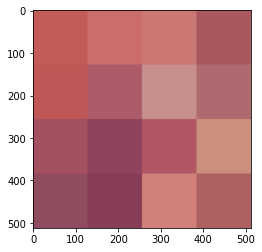

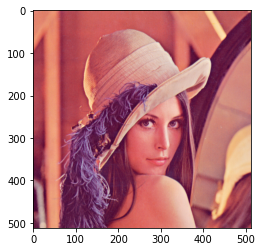

In [44]:
image_path = "../images/lena_reconstructed.png"
image = Image.open(image_path)

plt.imshow(image)
plt.show()

image_path = "../images/lena.png"
image = Image.open(image_path)

plt.imshow(image)
plt.show()

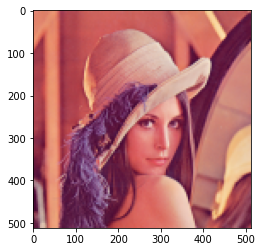

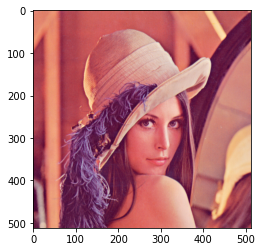

In [50]:
image_path = "../images/lena_reconstructed.png"
image = Image.open(image_path)

plt.imshow(image)
plt.show()

image_path = "../images/lena.png"
image = Image.open(image_path)

plt.imshow(image)
plt.show()

[I 2024-10-18 18:51:21,338] A new study created in memory with name: aqmp_optuna_study_2024-10-18_18-51-21


32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:51:22,350] Trial 0 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.5492646904233974, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.4222048983149828}. Best is trial 0 with value: 9.49732416668337.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:51:23,258] Trial 1 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.8918812277812977, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 2.5601615250028704}. Best is trial 1 with value: 12.065364636382155.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 790715
File saved.


[I 2024-10-18 18:51:36,673] Trial 2 finished with value: 1.4961840015409245 and parameters: {'min_sparcity': 0.9256710416543684, 'exponent_min_n': 2, 'exponent_max_n': 2, 'a_cols': 4, 'max_error': 165.98654663071267}. Best is trial 1 with value: 12.065364636382155.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.8203366962114179

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:51:37,552] Trial 3 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.9786397238905312, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 6.910765046043323}. Best is trial 1 with value: 12.065364636382155.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:51:38,368] Trial 4 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.14420993412163735, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 44.19795105236874}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:51:39,744] Trial 5 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.456694181884332, 'exponent_min_n': 4, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 459.71478464161305}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 16): 0.4801434556859617

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:51:41,189] Trial 6 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.6821384788043799, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 10.56397142297484}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 201417
File saved.


[I 2024-10-18 18:51:45,146] Trial 7 finished with value: 3.2082808585550815 and parameters: {'min_sparcity': 0.21117217851276707, 'exponent_min_n': 2, 'exponent_max_n': 3, 'a_cols': 4, 'max_error': 851.614462778716}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 8): 0.6435385951817517

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-18 18:51:57,575] Trial 8 finished with value: 9.32389460634802 and parameters: {'min_sparcity': 0.10294276593728004, 'exponent_min_n': 2, 'exponent_max_n': 2, 'a_cols': 2, 'max_error': 0.029278818805431105}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.7596111947792082

16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
File saved.


[I 2024-10-18 18:51:59,411] Trial 9 finished with value: 4.145321726958576 and parameters: {'min_sparcity': 0.1598106140618742, 'exponent_min_n': 2, 'exponent_max_n': 4, 'a_cols': 8, 'max_error': 84.32558817326782}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 16): 0.5190555968433982

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:00,226] Trial 10 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.34366708818190517, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0013190919167740036}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:01,055] Trial 11 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3605794816112863, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0073759641627807425}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:01,884] Trial 12 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.014035896119382052, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.12435208865458341}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:02,735] Trial 13 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.30578543719752116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0013907296598152392}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:52:04,179] Trial 14 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.2880930820682007, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 20.943202800907972}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:05,020] Trial 15 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.5912148379777444, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0012266712018538786}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:06,046] Trial 16 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.4048953035984949, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 1.2163207495836401}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:06,875] Trial 17 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.07504208426236796, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.1494008620101531}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:52:08,369] Trial 18 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.22598552261822907, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 40.70919925012664}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:09,380] Trial 19 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.739693743067472, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.012692257470910299}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:10,211] Trial 20 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.45256646509967696, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 2.5827648887474326}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:11,063] Trial 21 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.351943192286848, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.006249330592766429}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:11,905] Trial 22 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.36352925581801376, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.004623087068630824}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:12,749] Trial 23 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.24327463478529662, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.040471345486599676}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:13,569] Trial 24 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.15042870596754898, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0019464415922758882}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:14,389] Trial 25 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.5145257551714163, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.024549640227590205}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:15,219] Trial 26 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.04295646700105832, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.00483343736768188}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:16,102] Trial 27 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3300243665395005, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.11187089732513573}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:17,101] Trial 28 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.6482180013530352, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.009479209539670316}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:52:18,006] Trial 29 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.5585569552718901, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 0.37865082746516215}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:19,002] Trial 30 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.4208253690840513, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.0027401164299076116}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.46254506722335087

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:19,831] Trial 31 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.0017805679414578772, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.14032591190503596}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:20,656] Trial 32 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.1517903546597557, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.07471204523872371}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:52:22,058] Trial 33 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.10441287772935293, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 0.4379936538693653}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:52:22,975] Trial 34 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.013725106942326093, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 0.013955812359813712}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:23,803] Trial 35 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.250254270034654, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.3664581913449354}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:24,627] Trial 36 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.1807878603166833, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 215.55368932995947}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:52:25,533] Trial 37 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.8339888697717245, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 4.408521614961696}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:26,351] Trial 38 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.11167318593784174, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 1.0661302596075315}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-18 18:52:29,853] Trial 39 finished with value: 27.263003452243957 and parameters: {'min_sparcity': 0.270612438778185, 'exponent_min_n': 3, 'exponent_max_n': 3, 'a_cols': 2, 'max_error': 0.0031169698616077403}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.585373815045804

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:52:30,759] Trial 40 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.06274726695048045, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 0.0010167723238934424}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:31,582] Trial 41 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.31372448862709806, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001752002847960687}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:32,409] Trial 42 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.38565450104210947, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001005731449048982}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:33,237] Trial 43 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.19822511893639905, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.05035029949070076}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:34,052] Trial 44 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.477856961072466, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.023202080986208174}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:34,874] Trial 45 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.30367164113633177, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.006526277967492556}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:35,694] Trial 46 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.41871029535566834, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.002949365974576231}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:36,685] Trial 47 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.12852457028892655, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 22.573456299951232}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.46254506722335087

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:37,504] Trial 48 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.20772981458128562, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 86.66143428674826}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:52:38,891] Trial 49 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.2798258032182858, 'exponent_min_n': 2, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 9.678886582783912}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 16): 0.4801434556859617

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:39,711] Trial 50 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.5110180224822772, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.01515622881334338}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:40,540] Trial 51 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.6100394401601418, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0014641398107056313}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-18 18:52:43,987] Trial 52 finished with value: 27.263003452243957 and parameters: {'min_sparcity': 0.5722288476471066, 'exponent_min_n': 3, 'exponent_max_n': 3, 'a_cols': 2, 'max_error': 0.0036289692346850944}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.585373815045804

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:44,820] Trial 53 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.7232990070700921, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.008032930592362975}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:45,639] Trial 54 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.35760499327849626, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001742010179205036}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:46,466] Trial 55 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.4657577416792033, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001032993082617629}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:47,454] Trial 56 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.08291323195032006, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.00227510953761737}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.46254506722335087

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:48,277] Trial 57 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.6019783449217837, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.22805024912203237}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67545
File saved.


[I 2024-10-18 18:52:49,911] Trial 58 finished with value: 5.737703131433 and parameters: {'min_sparcity': 0.43564092986358327, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 4, 'max_error': 472.3733029999735}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.5098269487954677

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:50,734] Trial 59 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.04422958444642962, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.004950535220601136}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:51,608] Trial 60 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.2457041894118172, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 2.0831133277920086}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:52,440] Trial 61 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.0635531216170299, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.5295631273465992}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:53,254] Trial 62 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.14605647801276983, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.06656238518554745}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:54,074] Trial 63 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.02673862716327724, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.033242040507320054}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:54,887] Trial 64 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3845498064029284, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.018678836499684076}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:55,712] Trial 65 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3342491357866181, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.197552944549384}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:52:56,716] Trial 66 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.0871740208297189, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.008493385626587737}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:57,529] Trial 67 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.17676241697912146, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.09256718312765405}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:52:58,354] Trial 68 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.5403120018763053, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.011218907402237653}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:52:59,250] Trial 69 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.22360626321984162, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 1.5564803225121828}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:00,067] Trial 70 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.6910778398601173, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.697477303984062}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:00,901] Trial 71 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.4836761711060809, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 37.40987123300622}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:01,723] Trial 72 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.4481416243498251, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.004281492708630401}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:02,546] Trial 73 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3413190290589893, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0015005572603907892}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:03,426] Trial 74 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.39514398362713105, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 3.3770692997431984}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:04,264] Trial 75 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.2922715885066348, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 4.573420282529207}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:05,092] Trial 76 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.00349412210628843, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 131.62448243647805}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:05,919] Trial 77 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.8080314186225064, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 16.771077722755635}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:53:06,918] Trial 78 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.5428322117189723, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.1951086350274225}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:07,763] Trial 79 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.6349567735033746, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0024659357220379982}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:53:09,165] Trial 80 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.2662758600803255, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 0.7102314262363275}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:09,987] Trial 81 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.37486158140805764, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.006163334021235868}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:10,809] Trial 82 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.4147673042083134, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.053222418314338896}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:11,669] Trial 83 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3114059915101679, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0012011054574757388}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:12,510] Trial 84 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.5042156472227131, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 948.2685915928649}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:53:13,416] Trial 85 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.9544108594084371, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 0.0031996152505775247}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:14,230] Trial 86 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.12719215130741549, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001823394428593687}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:15,048] Trial 87 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.34877498561989567, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.026363251245037352}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:15,872] Trial 88 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.4294564510053271, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.28353342813810767}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:53:17,264] Trial 89 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.048351886180153805, 'exponent_min_n': 3, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 0.005342127238683322}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.4801434556859617

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:18,101] Trial 90 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.08140746270173718, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.0022986828909838776}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:18,939] Trial 91 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3564914073455108, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.007437367848248816}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-18 18:53:20,408] Trial 92 finished with value: 72.41800397371236 and parameters: {'min_sparcity': 0.4033752446959765, 'exponent_min_n': 2, 'exponent_max_n': 4, 'a_cols': 2, 'max_error': 0.003861047582973969}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 16): 0.4801434556859617

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:21,234] Trial 93 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.3726255969742089, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.01826130084006484}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:22,063] Trial 94 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.31931928388229275, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 7.12287608600418}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:22,899] Trial 95 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.46228043969781396, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.001344997417870635}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28047
File saved.


[I 2024-10-18 18:53:23,895] Trial 96 finished with value: 9.49732416668337 and parameters: {'min_sparcity': 0.18048506243260837, 'exponent_min_n': 4, 'exponent_max_n': 5, 'a_cols': 8, 'max_error': 0.01139288847648808}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.46254506722335087

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:24,726] Trial 97 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.2636259354317804, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.14378457039823234}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-18 18:53:25,637] Trial 98 finished with value: 12.065364636382155 and parameters: {'min_sparcity': 0.5799758248226176, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 4, 'max_error': 0.0019379553294209442}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-18 18:53:26,467] Trial 99 finished with value: 146.06381011097412 and parameters: {'min_sparcity': 0.028715711600539665, 'exponent_min_n': 5, 'exponent_max_n': 5, 'a_cols': 2, 'max_error': 0.03793838950930764}. Best is trial 4 with value: 146.06381011097412.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.45222195855269565



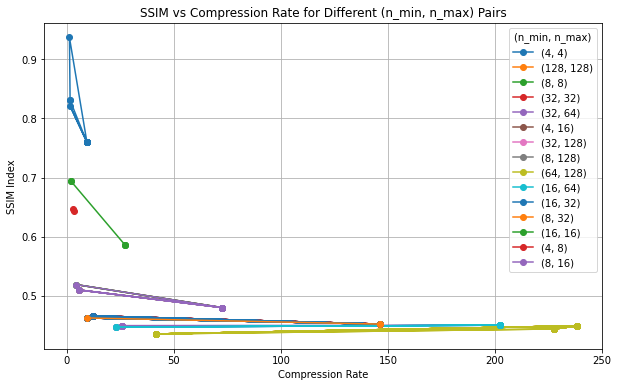

In [60]:
def objective(trial):
    min_sparcity = trial.suggest_float('min_sparcity', 0.001, 1)
    exponent_min_n = trial.suggest_int('exponent_min_n', 2, 5)
    exponent_max_n = trial.suggest_int('exponent_max_n', exponent_min_n, 5)
    a_cols = trial.suggest_categorical("a_cols", [2, 4, 8])
    max_error = trial.suggest_float('max_error', 0.001, 1000, log = True )
    
    min_n = 2**exponent_min_n
    max_n = 2**exponent_max_n
    print(max_n, min_n)
    assert max_n >= min_n

    # Use the (n_min, n_max) pair as the key in the results dictionary
    pair_key = (min_n, max_n)
    
    if pair_key not in results:
        results[pair_key] = {'ssim_values': [], 'compression_rates': []}

    # ENCODE
    newCodec = ImageCompressor(min_sparcity,
                               min_n,
                               max_n,
                               a_cols,
                               max_error)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        newCodec.encode(input_file="../images/lena.png",
                        output_file="../compressions/lena_compressed.fif")

    # DECODE
    newCodec.decode(input_file="../compressions/lena_compressed.fif",
                    output_file="../images/lena_reconstructed.png")

    # CALCULATE SSIM
    image1 = img_as_float(io.imread('../images/lena.png', as_gray=True))
    image2 = img_as_float(io.imread('../images/lena_reconstructed.png', as_gray=True))
    ssim_index, _ = ssim(image1, image2, full=True, data_range=image1.max() - image1.min())
    
    # Record SSIM value for this pair
    results[pair_key]['ssim_values'].append(ssim_index)
    print(f"SSIM Index for ({min_n}, {max_n}): {ssim_index}\n")

    # COMPRESSION RATE
    compressed_lena_size = os.path.getsize('../images/lena_reconstructed.png')
    compression_rate = lena_size / compressed_lena_size
    
    # Record compression rate for this pair
    results[pair_key]['compression_rates'].append(compression_rate)

    return compression_rate if compression_rate > 0.6 else 0

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
study_name = f"aqmp_optuna_study_{current_time}"

sampler = TPESampler(seed=0)  # Make the sampler behave in a deterministic way
study = optuna.create_study(direction='maximize', study_name=study_name, sampler=sampler)
study.optimize(objective, n_trials=100)

plot_results()

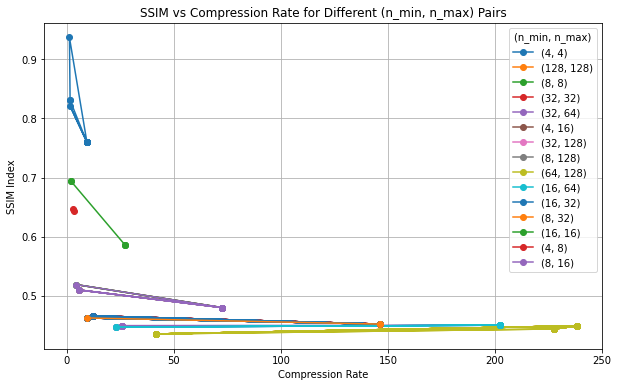

In [61]:
plot_results()

In [19]:
from optuna.samplers import RandomSampler

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
study_name = f"aqmp_optuna_study_{current_time}"

sampler = RandomSampler(seed=0)  # Make the sampler behave in a deterministic way
study = optuna.create_study(directions=['maximize', 'maximize'], study_name=study_name, sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-10-29 10:03:57,792] A new study created in memory with name: aqmp_optuna_study_2024-10-29_10-03-57


128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4587
File saved.


[I 2024-10-29 10:03:59,529] Trial 0 finished with values: [24.879548437910213, 0.42507119750864575] and parameters: {'min_sparcity': 0.5492646904233974, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 5, 'max_error': 0.348280208702833}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.42507119750864575

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:04:07,631] Trial 1 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.6462482189535894, 'exponent_min_n': 4, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 0.1998246739232945}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.45400420221794147

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:04:13,830] Trial 2 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.7919333130445819, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 0.002668187524237051}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4919963138776112

64 4
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:04:16,898] Trial 3 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.08804217040183916, 'exponent_min_n': 2, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 165.98654663071267}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 64): 0.4633051751217545

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:04:19,940] Trial 4 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.9786397238905312, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 0.005124441683726439}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4633051751217545

128 4
processed_blocks: 48
bytes_written (without DEFLATE): 4587
File saved.


[I 2024-10-29 10:04:21,821] Trial 5 finished with values: [24.879548437910213, 0.42507119750864575] and parameters: {'min_sparcity': 0.6402811003061963, 'exponent_min_n': 2, 'exponent_max_n': 7, 'exponent_a_cols': 5, 'max_error': 0.30758959477348574}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 128): 0.42507119750864575

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 18545
File saved.


[I 2024-10-29 10:04:23,500] Trial 6 finished with values: [8.109378743795995, 0.3984377111853839] and parameters: {'min_sparcity': 0.2652910564925223, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 5, 'max_error': 0.0012963993440545018}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3984377111853839

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:04:29,537] Trial 7 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.6180178615788012, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 12.328828024348084}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4919963138776112

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-29 10:04:30,821] Trial 8 finished with values: [25.59864937871421, 0.44959744160375437] and parameters: {'min_sparcity': 0.36014839267321225, 'exponent_min_n': 4, 'exponent_max_n': 6, 'exponent_a_cols': 2, 'max_error': 10.013831806758102}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.44959744160375437

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 777082
File saved.


[I 2024-10-29 10:04:38,187] Trial 9 finished with values: [1.5130974316069141, 0.8042853311179139] and parameters: {'min_sparcity': 0.6709672317485412, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 4, 'max_error': 0.15214743167796876}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.8042853311179139

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-29 10:04:39,315] Trial 10 finished with values: [227.80336538461538, 0.4439075463868736] and parameters: {'min_sparcity': 0.5706265736474617, 'exponent_min_n': 4, 'exponent_max_n': 7, 'exponent_a_cols': 2, 'max_error': 0.017916803744057602}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.4439075463868736

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 77672
File saved.


[I 2024-10-29 10:04:41,881] Trial 11 finished with values: [3.837993487663821, 0.42621266734790736] and parameters: {'min_sparcity': 0.16214820836711127, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 5, 'max_error': 0.029278818805431105}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.42621266734790736

32 4
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-29 10:04:42,777] Trial 12 finished with values: [12.065364636382155, 0.4661189004364895] and parameters: {'min_sparcity': 0.1598106140618742, 'exponent_min_n': 2, 'exponent_max_n': 5, 'exponent_a_cols': 2, 'max_error': 0.015117994050015146}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 32): 0.4661189004364895

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:04:45,767] Trial 13 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.36935644549030316, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 0.0037721629693531814}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4633051751217545

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:04:48,457] Trial 14 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.9764830055483824, 'exponent_min_n': 4, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 27.26349171289777}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.3836300946220435

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 777082
File saved.


[I 2024-10-29 10:04:56,318] Trial 15 finished with values: [1.5130974316069141, 0.8042853311179139] and parameters: {'min_sparcity': 0.040148604462066355, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 4, 'max_error': 0.005156634070543801}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.8042853311179139

16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 559435
File saved.


[I 2024-10-29 10:05:05,085] Trial 16 finished with values: [1.7196949900556016, 0.7008497549907867] and parameters: {'min_sparcity': 0.31866519621458206, 'exponent_min_n': 4, 'exponent_max_n': 4, 'exponent_a_cols': 6, 'max_error': 2.509624383071781}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 16): 0.7008497549907867

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136332
File saved.


[I 2024-10-29 10:05:08,698] Trial 17 finished with values: [2.554345013477089, 0.5111276216110829] and parameters: {'min_sparcity': 0.26612410144850596, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 6, 'max_error': 376.51058087853585}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.5111276216110829

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:05:11,927] Trial 18 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.31925038349887236, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 0.05450502682033237}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4633051751217545

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 262697
File saved.


[I 2024-10-29 10:05:17,607] Trial 19 finished with values: [2.2012441000483145, 0.5523448032536613] and parameters: {'min_sparcity': 0.18400817064510971, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 7, 'max_error': 0.0010670207305103134}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.5523448032536613

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:05:24,298] Trial 20 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.6781387202594339, 'exponent_min_n': 3, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 0.031082708899403122}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.4919963138776112

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:05:25,652] Trial 21 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.576581177083419, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 520.5878993977001}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4471080551681772

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:05:28,261] Trial 22 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.4476782532390097, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 0.06090061875639703}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.3836300946220435

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:05:31,130] Trial 23 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.8139840218827747, 'exponent_min_n': 4, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 195.1695995917702}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.3836300946220435

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:05:39,340] Trial 24 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.6928390584876881, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 7.310400920186161}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.45400420221794147

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 40027
File saved.


[I 2024-10-29 10:05:41,129] Trial 25 finished with values: [5.7436149193304, 0.4529175111085986] and parameters: {'min_sparcity': 0.4244311935096215, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 4, 'max_error': 9.142000168460763}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4529175111085986

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-29 10:05:42,603] Trial 26 finished with values: [25.59864937871421, 0.44959744160375437] and parameters: {'min_sparcity': 0.2907875296032336, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 2, 'max_error': 0.061616064476687854}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.44959744160375437

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33680
File saved.


[I 2024-10-29 10:05:45,260] Trial 27 finished with values: [5.115473889902512, 0.3370258231669546] and parameters: {'min_sparcity': 0.5703949457905636, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 6, 'max_error': 8.177482436211173}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.3370258231669546

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-29 10:05:46,761] Trial 28 finished with values: [41.20627880685277, 0.43888599592067057] and parameters: {'min_sparcity': 0.43198701699854, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 4, 'max_error': 0.4122774218913464}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.43888599592067057

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-29 10:05:48,044] Trial 29 finished with values: [227.80336538461538, 0.4439075463868736] and parameters: {'min_sparcity': 0.8920314316606565, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 2, 'max_error': 328.77265020216964}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.4439075463868736

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-29 10:05:49,434] Trial 30 finished with values: [41.66646148434752, 0.4354711053615101] and parameters: {'min_sparcity': 0.7145270582495623, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 3, 'max_error': 161.71724875539462}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.4354711053615101

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 262697
File saved.


[I 2024-10-29 10:05:55,500] Trial 31 finished with values: [2.2012441000483145, 0.5523448032536613] and parameters: {'min_sparcity': 0.16333044174169845, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 7, 'max_error': 69.80937540893079}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.5523448032536613

16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 559435
File saved.


[I 2024-10-29 10:06:05,282] Trial 32 finished with values: [1.7196949900556016, 0.7008497549907867] and parameters: {'min_sparcity': 0.5695316378759787, 'exponent_min_n': 4, 'exponent_max_n': 4, 'exponent_a_cols': 6, 'max_error': 0.526327541297808}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 16): 0.7008497549907867

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:06:12,615] Trial 33 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.7223335438708776, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 136.4017852114359}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.45400420221794147

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:06:13,998] Trial 34 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.01270237010081697, 'exponent_min_n': 4, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 1.3372716484978067}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.4471080551681772

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3690557
File saved.


[I 2024-10-29 10:06:41,204] Trial 35 finished with values: [0.9829335889042398, 0.9986739952368063] and parameters: {'min_sparcity': 0.05528365035091438, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 7, 'max_error': 0.0220570855869856}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.9986739952368063

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:06:43,606] Trial 36 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.3460063290162058, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 0.001552507036362896}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.3836300946220435

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:06:44,929] Trial 37 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.16552946234141483, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 402.98045932583017}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4471080551681772

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:06:48,265] Trial 38 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.6143519900099301, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 0.07441662554879507}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4633051751217545

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 1970737
File saved.


[I 2024-10-29 10:07:22,100] Trial 39 finished with values: [0.9798156297043789, 0.9946666390350921] and parameters: {'min_sparcity': 0.3988228411538758, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 8, 'max_error': 27.37188900900727}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.9946666390350921

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-29 10:07:23,885] Trial 40 finished with values: [5.736661137813722, 0.5098305300677997] and parameters: {'min_sparcity': 0.4909683498089495, 'exponent_min_n': 3, 'exponent_max_n': 4, 'exponent_a_cols': 2, 'max_error': 0.40411014500490783}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.5098305300677997

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:07:25,258] Trial 41 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.3124840861121085, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 0.0014062818458438315}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4471080551681772

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 18545
File saved.


[I 2024-10-29 10:07:27,161] Trial 42 finished with values: [8.109378743795995, 0.3984377111853839] and parameters: {'min_sparcity': 0.06818238183178534, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 5, 'max_error': 239.89862470391157}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3984377111853839

64 8
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:07:28,597] Trial 43 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.9903486084493076, 'exponent_min_n': 3, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 0.0013301664717779403}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 64): 0.4471080551681772

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559435
File saved.


[I 2024-10-29 10:07:38,747] Trial 44 finished with values: [1.7196949900556016, 0.7008497549907867] and parameters: {'min_sparcity': 0.7586202751823053, 'exponent_min_n': 3, 'exponent_max_n': 4, 'exponent_a_cols': 6, 'max_error': 96.89262712235762}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.7008497549907867

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-29 10:07:40,159] Trial 45 finished with values: [41.66646148434752, 0.4354711053615101] and parameters: {'min_sparcity': 0.6293528617475576, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 3, 'max_error': 61.41592588083609}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.4354711053615101

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:07:42,935] Trial 46 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.18645030836164625, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 0.019635685282387273}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.3836300946220435

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:07:44,397] Trial 47 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.9474232198984354, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 1.2858913757256232}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4471080551681772

32 8
processed_blocks: 768
bytes_written (without DEFLATE): 40027
File saved.


[I 2024-10-29 10:07:46,399] Trial 48 finished with values: [5.7436149193304, 0.4529175111085986] and parameters: {'min_sparcity': 0.026637055336477044, 'exponent_min_n': 3, 'exponent_max_n': 5, 'exponent_a_cols': 4, 'max_error': 0.604578287619494}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 32): 0.4529175111085986

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-29 10:07:47,754] Trial 49 finished with values: [227.80336538461538, 0.4439075463868736] and parameters: {'min_sparcity': 0.2783510775884372, 'exponent_min_n': 5, 'exponent_max_n': 7, 'exponent_a_cols': 2, 'max_error': 1.2713778560353075}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.4439075463868736

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 18545
File saved.


[I 2024-10-29 10:07:49,637] Trial 50 finished with values: [8.109378743795995, 0.3984377111853839] and parameters: {'min_sparcity': 0.13293603823880817, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 5, 'max_error': 0.01257995296353426}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3984377111853839

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507547
File saved.


[I 2024-10-29 10:08:03,727] Trial 51 finished with values: [1.9055453452318234, 0.649164739289536] and parameters: {'min_sparcity': 0.14570291158403387, 'exponent_min_n': 4, 'exponent_max_n': 5, 'exponent_a_cols': 8, 'max_error': 39.079727147913495}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.649164739289536

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-29 10:08:05,292] Trial 52 finished with values: [227.80336538461538, 0.4439075463868736] and parameters: {'min_sparcity': 0.7489149562306967, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 2, 'max_error': 2.056623621104484}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.4439075463868736

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-29 10:08:06,886] Trial 53 finished with values: [41.20627880685277, 0.43888599592067057] and parameters: {'min_sparcity': 0.5848915928868131, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 4, 'max_error': 0.027859459054091085}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.43888599592067057

128 4
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-29 10:08:09,894] Trial 54 finished with values: [13.142258833971265, 0.3836300946220435] and parameters: {'min_sparcity': 0.10119364832323231, 'exponent_min_n': 2, 'exponent_max_n': 7, 'exponent_a_cols': 6, 'max_error': 51.39459784726387}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 128): 0.3836300946220435

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 77672
File saved.


[I 2024-10-29 10:08:12,719] Trial 55 finished with values: [3.837993487663821, 0.42621266734790736] and parameters: {'min_sparcity': 0.28244837564819514, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 5, 'max_error': 732.7753278865404}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.42621266734790736

128 16
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-29 10:08:14,229] Trial 56 finished with values: [41.66646148434752, 0.4354711053615101] and parameters: {'min_sparcity': 0.8766287400712742, 'exponent_min_n': 4, 'exponent_max_n': 7, 'exponent_a_cols': 3, 'max_error': 496.4927767176735}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 128): 0.4354711053615101

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:08:22,633] Trial 57 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.9414363270017921, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 0.05729565743162536}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.45400420221794147

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 40027
File saved.


[I 2024-10-29 10:08:24,564] Trial 58 finished with values: [5.7436149193304, 0.4529175111085986] and parameters: {'min_sparcity': 0.8490946117576053, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 4, 'max_error': 0.007741857365336936}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4529175111085986

32 16
processed_blocks: 768
bytes_written (without DEFLATE): 136332
File saved.


[I 2024-10-29 10:08:28,319] Trial 59 finished with values: [2.554345013477089, 0.5111276216110829] and parameters: {'min_sparcity': 0.9818475604284349, 'exponent_min_n': 4, 'exponent_max_n': 5, 'exponent_a_cols': 6, 'max_error': 0.16274499330081232}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 32): 0.5111276216110829

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 18545
File saved.


[I 2024-10-29 10:08:30,151] Trial 60 finished with values: [8.109378743795995, 0.3984377111853839] and parameters: {'min_sparcity': 0.13776337141391334, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 5, 'max_error': 0.022176968205873514}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3984377111853839

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:08:37,252] Trial 61 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.09874664000954002, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 582.113871414753}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.45400420221794147

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-29 10:08:38,579] Trial 62 finished with values: [25.59864937871421, 0.44959744160375437] and parameters: {'min_sparcity': 0.9066489437219578, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 2, 'max_error': 0.27761762112834004}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.44959744160375437

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 4156180
File saved.


[I 2024-10-29 10:09:15,091] Trial 63 finished with values: [0.9844591127150637, 0.9986679924864509] and parameters: {'min_sparcity': 0.2330019080287718, 'exponent_min_n': 2, 'exponent_max_n': 2, 'exponent_a_cols': 7, 'max_error': 0.0011710211843652943}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.9986679924864509

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081185
File saved.


[I 2024-10-29 10:09:30,481] Trial 64 finished with values: [1.457645524293528, 0.8304289950140705] and parameters: {'min_sparcity': 0.7708101677542735, 'exponent_min_n': 2, 'exponent_max_n': 2, 'exponent_a_cols': 2, 'max_error': 10.771764354556005}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.8304289950140705

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:09:36,468] Trial 65 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.24612184264299192, 'exponent_min_n': 4, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 23.028496069913658}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.4919963138776112

4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2767225
File saved.


[I 2024-10-29 10:10:01,347] Trial 66 finished with values: [1.0243089933547491, 0.9592524594872034] and parameters: {'min_sparcity': 0.2710575773334759, 'exponent_min_n': 2, 'exponent_max_n': 2, 'exponent_a_cols': 4, 'max_error': 0.03738599085780402}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 4): 0.9592524594872034

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-29 10:10:02,588] Trial 67 finished with values: [41.66646148434752, 0.4354711053615101] and parameters: {'min_sparcity': 0.45668442623367916, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 3, 'max_error': 0.19035388083156188}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.4354711053615101

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 33680
File saved.


[I 2024-10-29 10:10:04,769] Trial 68 finished with values: [5.115473889902512, 0.3370258231669546] and parameters: {'min_sparcity': 0.18196981077516614, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 6, 'max_error': 47.00806511030314}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.3370258231669546

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559435
File saved.


[I 2024-10-29 10:10:13,619] Trial 69 finished with values: [1.7196949900556016, 0.7008497549907867] and parameters: {'min_sparcity': 0.7776301542869044, 'exponent_min_n': 3, 'exponent_max_n': 4, 'exponent_a_cols': 6, 'max_error': 0.04334424220895921}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.7008497549907867

32 8
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-29 10:10:14,543] Trial 70 finished with values: [12.065364636382155, 0.4661189004364895] and parameters: {'min_sparcity': 0.3714819464186708, 'exponent_min_n': 3, 'exponent_max_n': 5, 'exponent_a_cols': 2, 'max_error': 62.918057710313434}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 32): 0.4661189004364895

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 136332
File saved.


[I 2024-10-29 10:10:18,079] Trial 71 finished with values: [2.554345013477089, 0.5111276216110829] and parameters: {'min_sparcity': 0.0778794905396461, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 6, 'max_error': 570.9525868760132}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.5111276216110829

16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 311665
File saved.


[I 2024-10-29 10:10:21,466] Trial 72 finished with values: [1.927254756810842, 0.6407259183599945] and parameters: {'min_sparcity': 0.6459246742115479, 'exponent_min_n': 2, 'exponent_max_n': 4, 'exponent_a_cols': 5, 'max_error': 1.648408966584727}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 16): 0.6407259183599945

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 455832
File saved.


[I 2024-10-29 10:10:27,179] Trial 73 finished with values: [1.7818688467873556, 0.7950292729953904] and parameters: {'min_sparcity': 0.681711118093234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 4, 'max_error': 547.5633057805163}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.7950292729953904

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4587
File saved.


[I 2024-10-29 10:10:28,936] Trial 74 finished with values: [24.879548437910213, 0.42507119750864575] and parameters: {'min_sparcity': 0.1879437608590939, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 5, 'max_error': 0.5514022448707822}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.42507119750864575

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 10350
File saved.


[I 2024-10-29 10:10:30,350] Trial 75 finished with values: [15.754455379704748, 0.4345756391896931] and parameters: {'min_sparcity': 0.8821593688196597, 'exponent_min_n': 4, 'exponent_max_n': 6, 'exponent_a_cols': 4, 'max_error': 265.62341590508305}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.4345756391896931

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-29 10:10:33,605] Trial 76 finished with values: [3.1928021778095226, 0.4633051751217545] and parameters: {'min_sparcity': 0.6903349951710361, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 7, 'max_error': 6.5518860060653585}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4633051751217545

64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:10:43,915] Trial 77 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.24078025310632983, 'exponent_min_n': 2, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 0.5608322297118469}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 64): 0.4919963138776112

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4587
File saved.


[I 2024-10-29 10:10:46,434] Trial 78 finished with values: [24.879548437910213, 0.42507119750864575] and parameters: {'min_sparcity': 0.5913931811583613, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 5, 'max_error': 514.3359265376613}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.42507119750864575

128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16137
File saved.


[I 2024-10-29 10:10:50,906] Trial 79 finished with values: [7.099123529852424, 0.3127477891586962] and parameters: {'min_sparcity': 0.5761754108828275, 'exponent_min_n': 6, 'exponent_max_n': 7, 'exponent_a_cols': 7, 'max_error': 0.00904662900667174}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 128): 0.3127477891586962

16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 175115
File saved.


[I 2024-10-29 10:10:53,417] Trial 80 finished with values: [2.4792978049865266, 0.5070651030596427] and parameters: {'min_sparcity': 0.6292695406226387, 'exponent_min_n': 4, 'exponent_max_n': 4, 'exponent_a_cols': 4, 'max_error': 0.03565368320699194}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 16): 0.5070651030596427

128 4
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-29 10:10:54,971] Trial 81 finished with values: [41.20627880685277, 0.43888599592067057] and parameters: {'min_sparcity': 0.8491892701200823, 'exponent_min_n': 2, 'exponent_max_n': 7, 'exponent_a_cols': 4, 'max_error': 0.13811515731222385}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 128): 0.43888599592067057

32 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3224512
File saved.


[I 2024-10-29 10:12:41,772] Trial 82 finished with values: [0.9818174660074678, 0.9979202059566772] and parameters: {'min_sparcity': 0.017312174181024185, 'exponent_min_n': 3, 'exponent_max_n': 5, 'exponent_a_cols': 8, 'max_error': 0.0039599488962781286}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 32): 0.9979202059566772

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4587
File saved.


[I 2024-10-29 10:12:43,683] Trial 83 finished with values: [24.879548437910213, 0.42507119750864575] and parameters: {'min_sparcity': 0.9453562319456005, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 5, 'max_error': 0.0912442047964337}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.42507119750864575

32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-29 10:12:44,698] Trial 84 finished with values: [12.065364636382155, 0.4661189004364895] and parameters: {'min_sparcity': 0.2335113851497778, 'exponent_min_n': 5, 'exponent_max_n': 5, 'exponent_a_cols': 2, 'max_error': 0.37391624608406826}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 32): 0.4661189004364895

16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
File saved.


[I 2024-10-29 10:12:46,538] Trial 85 finished with values: [4.145321726958576, 0.5190555968433982] and parameters: {'min_sparcity': 0.06900599990074549, 'exponent_min_n': 3, 'exponent_max_n': 4, 'exponent_a_cols': 3, 'max_error': 0.006114083805552654}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 16): 0.5190555968433982

32 4
processed_blocks: 47547
bytes_written (without DEFLATE): 668005
File saved.


[I 2024-10-29 10:14:11,958] Trial 86 finished with values: [1.5522464824491, 0.86510397489774] and parameters: {'min_sparcity': 0.013024186674756615, 'exponent_min_n': 2, 'exponent_max_n': 5, 'exponent_a_cols': 8, 'max_error': 875.1248361872716}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 32): 0.86510397489774

32 4
processed_blocks: 768
bytes_written (without DEFLATE): 77672
File saved.


[I 2024-10-29 10:14:14,901] Trial 87 finished with values: [3.837993487663821, 0.42621266734790736] and parameters: {'min_sparcity': 0.4096450412776885, 'exponent_min_n': 2, 'exponent_max_n': 5, 'exponent_a_cols': 5, 'max_error': 863.8904313922044}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 32): 0.42621266734790736

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:14:16,792] Trial 88 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.06623890294462842, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 9.441205032203982}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4471080551681772

64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10350
File saved.


[I 2024-10-29 10:14:18,458] Trial 89 finished with values: [15.754455379704748, 0.4345756391896931] and parameters: {'min_sparcity': 0.2468171218059735, 'exponent_min_n': 5, 'exponent_max_n': 6, 'exponent_a_cols': 4, 'max_error': 2.1287607394835675}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 64): 0.4345756391896931

64 64
processed_blocks: 192
bytes_written (without DEFLATE): 10350
File saved.


[I 2024-10-29 10:14:20,072] Trial 90 finished with values: [15.754455379704748, 0.4345756391896931] and parameters: {'min_sparcity': 0.2877644683997101, 'exponent_min_n': 6, 'exponent_max_n': 6, 'exponent_a_cols': 4, 'max_error': 93.7435697338692}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (64, 64): 0.4345756391896931

8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 773457
File saved.


[I 2024-10-29 10:14:27,864] Trial 91 finished with values: [1.5132907289061777, 0.8042759024542643] and parameters: {'min_sparcity': 0.9250419450412389, 'exponent_min_n': 2, 'exponent_max_n': 3, 'exponent_a_cols': 4, 'max_error': 77.58877162335912}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 8): 0.8042759024542643

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:14:34,742] Trial 92 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.9855059362156543, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 0.06016412298915474}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.45400420221794147

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3183572
File saved.


[I 2024-10-29 10:15:26,443] Trial 93 finished with values: [0.9817381305100021, 0.9979202861383378] and parameters: {'min_sparcity': 0.9920192321710596, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 8, 'max_error': 0.025149047017064483}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.9979202861383378

64 4
processed_blocks: 192
bytes_written (without DEFLATE): 125595
File saved.


[I 2024-10-29 10:15:33,230] Trial 94 finished with values: [3.008011528475207, 0.4919963138776112] and parameters: {'min_sparcity': 0.6900784968126727, 'exponent_min_n': 2, 'exponent_max_n': 6, 'exponent_a_cols': 8, 'max_error': 0.0431143033226197}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (4, 64): 0.4919963138776112

64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-29 10:15:34,673] Trial 95 finished with values: [22.88928071107676, 0.4471080551681772] and parameters: {'min_sparcity': 0.3796778391813511, 'exponent_min_n': 4, 'exponent_max_n': 6, 'exponent_a_cols': 3, 'max_error': 0.010742827303657951}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (16, 64): 0.4471080551681772

128 8
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-29 10:15:36,161] Trial 96 finished with values: [41.66646148434752, 0.4354711053615101] and parameters: {'min_sparcity': 0.44984235703905034, 'exponent_min_n': 3, 'exponent_max_n': 7, 'exponent_a_cols': 3, 'max_error': 1.033562502834463}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 128): 0.4354711053615101

128 32
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:15:45,058] Trial 97 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.9426410160982325, 'exponent_min_n': 5, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 31.95870488109623}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (32, 128): 0.45400420221794147

128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-29 10:15:52,413] Trial 98 finished with values: [4.018513806906846, 0.45400420221794147] and parameters: {'min_sparcity': 0.6998754851645266, 'exponent_min_n': 7, 'exponent_max_n': 7, 'exponent_a_cols': 8, 'max_error': 0.5139609178439343}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (128, 128): 0.45400420221794147

8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 777082
File saved.


[I 2024-10-29 10:16:00,055] Trial 99 finished with values: [1.5130974316069141, 0.8042853311179139] and parameters: {'min_sparcity': 0.07179890840602415, 'exponent_min_n': 3, 'exponent_max_n': 3, 'exponent_a_cols': 4, 'max_error': 0.0061338898219480895}.


Output file saved to: ../images/lena_reconstructed.png
SSIM Index for (8, 8): 0.8042853311179139



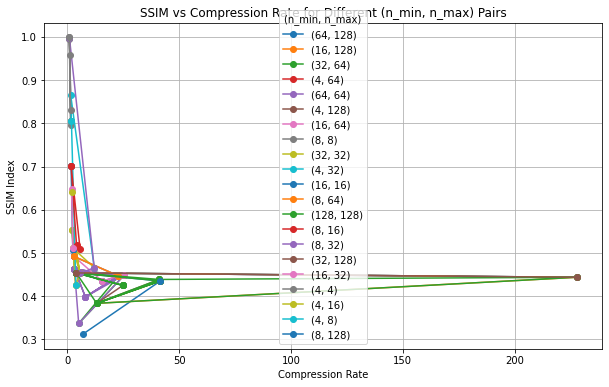

In [20]:
plot_results()

# New images. Avoiding Lenna

 1- Change downloaded images from .tiff to .png ()

 2- Use Optuna
 
 - Images taken from https://sipi.usc.edu/database/ .
 - Images from the same database were utilized in https://www.tandfonline.com/doi/epdf/10.1080/09500340.2016.1270881?needAccess=true
to search Lenna variants.

[I 2024-10-31 18:53:27,341] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Clock_time:2024-10-31_18-53-27


image name:  Clock
32 32
processed_blocks: 192
bytes_written (without DEFLATE): 3940
File saved.


[I 2024-10-31 18:53:27,598] Trial 0 finished with values: [5.319064290260981, 0.6037515363793662] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.2461860179901123
SSIM Index : 0.6037515363793662

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 3227
File saved.


[I 2024-10-31 18:53:28,251] Trial 1 finished with values: [4.1143525356967015, 0.4840825560787565] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.6414220333099365
SSIM Index : 0.4840825560787565

image name:  Clock
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 5742
File saved.


[I 2024-10-31 18:53:29,226] Trial 2 finished with values: [2.6445921354537543, 0.5868814786395329] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.9622201919555664
SSIM Index : 0.5868814786395329

image name:  Clock
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 23445
File saved.


[I 2024-10-31 18:53:30,210] Trial 3 finished with values: [1.5600933488914819, 0.700545721469388] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.9721202850341797
SSIM Index : 0.700545721469388

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 2730
File saved.


[I 2024-10-31 18:53:34,394] Trial 4 finished with values: [5.390259635542654, 0.5872826710211435] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.172158718109131
SSIM Index : 0.5872826710211435

image name:  Clock
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 917
File saved.


[I 2024-10-31 18:53:34,794] Trial 5 finished with values: [9.218146718146718, 0.5721168631537045] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.38829493522644043
SSIM Index : 0.5721168631537045

image name:  Clock
32 4
processed_blocks: 192
bytes_written (without DEFLATE): 12935
File saved.


[I 2024-10-31 18:53:35,540] Trial 6 finished with values: [2.0314209310805884, 0.6614728387547857] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.7332968711853027
SSIM Index : 0.6614728387547857

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 490
File saved.


[I 2024-10-31 18:53:36,339] Trial 7 finished with values: [15.403225806451612, 0.5587519148129341] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.7862503528594971
SSIM Index : 0.5587519148129341

image name:  Clock
128 8
processed_blocks: 12
bytes_written (without DEFLATE): 1455
File saved.


[I 2024-10-31 18:53:39,173] Trial 8 finished with values: [7.056153683766096, 0.4928271997523954] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 2.8219473361968994
SSIM Index : 0.4928271997523954

image name:  Clock
32 32
processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.


[I 2024-10-31 18:53:39,460] Trial 9 finished with values: [6.130777696258254, 0.6000040700756132] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.2771108150482178
SSIM Index : 0.6000040700756132

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 345
File saved.


[I 2024-10-31 18:53:39,971] Trial 10 finished with values: [16.00814176245211, 0.557718718400733] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.48023486137390137
SSIM Index : 0.557718718400733

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:53:40,359] Trial 11 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.6786440830104932, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3503725528717041
SSIM Index : 0.5632295068759442

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:53:40,771] Trial 12 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.6433077671486415, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.0141401748985, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3664076328277588
SSIM Index : 0.5632295068759442

image name:  Clock
16 16


[I 2024-10-31 18:53:41,208] Trial 13 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.6256686784685921, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 13.265287901477882, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3933277130126953
SSIM Index : 0.5845896573422181

image name:  Clock
8 8


[I 2024-10-31 18:53:42,107] Trial 14 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.6203109251296234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.8688523769378662
SSIM Index : 0.6534069089884157

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 18:53:46,214] Trial 15 finished with values: [0.8597849573001337, 0.8647462945616319] and parameters: {'min_sparcity': 0.7674028378760763, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 6.795065796278994, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.073331117630005
SSIM Index : 0.8647462945616319

image name:  Clock
8 8


[I 2024-10-31 18:53:47,236] Trial 16 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.5709255861884776, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 2.589488546494979, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.9883053302764893
SSIM Index : 0.6534069089884157

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 185
File saved.


[I 2024-10-31 18:53:47,670] Trial 17 finished with values: [41.62515566625156, 0.5536761987906907] and parameters: {'min_sparcity': 0.49800647956660665, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 984.7940308782788, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3968193531036377
SSIM Index : 0.5536761987906907

image name:  Clock
16 8


[I 2024-10-31 18:53:48,192] Trial 18 finished with values: [2.4517714369544485, 0.6548908190071935] and parameters: {'min_sparcity': 0.7704989271387993, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 56.05550543577921, 'exponent_a_cols': 3}.


processed_blocks: 768
bytes_written (without DEFLATE): 14357
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.4416379928588867
SSIM Index : 0.6548908190071935

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 345
File saved.


[I 2024-10-31 18:53:48,794] Trial 19 finished with values: [16.00814176245211, 0.557718718400733] and parameters: {'min_sparcity': 0.35463873268250473, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.035168375868930096, 'exponent_a_cols': 4}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.5659284591674805
SSIM Index : 0.557718718400733

image name:  Clock
64 16
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:53:49,066] Trial 20 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.7513333531776172, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 2.3691329778369523, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.22516274452209473
SSIM Index : 0.5478383372963492

image name:  Clock
64 16
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.16235041618347168


[I 2024-10-31 18:53:49,261] Trial 21 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.6066653537315065, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 40.09575746070031, 'exponent_a_cols': 1}.


SSIM Index : 0.5478383372963492

image name:  Clock
128 32
processed_blocks: 12
bytes_written (without DEFLATE): 185
File saved.


[I 2024-10-31 18:53:49,630] Trial 22 finished with values: [41.62515566625156, 0.5536761987906907] and parameters: {'min_sparcity': 0.012130548355998527, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 57.25843719200402, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.33312511444091797
SSIM Index : 0.5536761987906907

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:53:50,071] Trial 23 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.5557222406192883, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.4719819178969535, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3884010314941406
SSIM Index : 0.5632295068759442

image name:  Clock
16 16


[I 2024-10-31 18:53:50,556] Trial 24 finished with values: [2.9774630322465705, 0.6322180475860035] and parameters: {'min_sparcity': 0.695098485632712, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 26.468646950962214, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.43195629119873047
SSIM Index : 0.6322180475860035

image name:  Clock
16 8


[I 2024-10-31 18:53:50,977] Trial 25 finished with values: [2.4517714369544485, 0.6548908190071935] and parameters: {'min_sparcity': 0.8794218646285838, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.9955387677148444, 'exponent_a_cols': 3}.


processed_blocks: 768
bytes_written (without DEFLATE): 14357
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.38900184631347656
SSIM Index : 0.6548908190071935

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:53:51,311] Trial 26 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.5030265354431228, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 91.46805985642587, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.30590295791625977
SSIM Index : 0.5632295068759442

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 18:53:55,533] Trial 27 finished with values: [0.8597849573001337, 0.8647462945616319] and parameters: {'min_sparcity': 0.6982681640041222, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.633077560023407, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.17293381690979
SSIM Index : 0.8647462945616319

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1942
File saved.


[I 2024-10-31 18:53:56,096] Trial 28 finished with values: [5.412079015544041, 0.5301303919315408] and parameters: {'min_sparcity': 0.8037717266821447, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.05968618440403329, 'exponent_a_cols': 5}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.5272583961486816
SSIM Index : 0.5301303919315408

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 245
File saved.


[I 2024-10-31 18:53:56,636] Trial 29 finished with values: [17.601369141653503, 0.5445236156851573] and parameters: {'min_sparcity': 0.6131082748931094, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0121458827137354, 'exponent_a_cols': 3}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.4760396480560303
SSIM Index : 0.5445236156851573

image name:  Clock
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 18:53:56,965] Trial 30 finished with values: [31.592627599243855, 0.557996880699766] and parameters: {'min_sparcity': 0.3078687812445219, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 900.0853434874601, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.2772979736328125
SSIM Index : 0.557996880699766

image name:  Clock
16 8


[I 2024-10-31 18:53:57,385] Trial 31 finished with values: [2.9774630322465705, 0.6322180475860035] and parameters: {'min_sparcity': 0.545440619837498, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 15.940202503204075, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.38660335540771484
SSIM Index : 0.6322180475860035

image name:  Clock
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 4890
File saved.


[I 2024-10-31 18:53:57,895] Trial 32 finished with values: [3.9171452009844137, 0.6125379941855356] and parameters: {'min_sparcity': 0.9089662223762252, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.000229098038311, 'exponent_a_cols': 4}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.47214174270629883
SSIM Index : 0.6125379941855356

image name:  Clock
8 8
processed_blocks: 3072
bytes_written (without DEFLATE): 245275
File saved.


[I 2024-10-31 18:54:04,980] Trial 33 finished with values: [0.40874850196884094, 0.9972448869750381] and parameters: {'min_sparcity': 0.22863000375220932, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.5186616821838537, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 7.026018142700195
SSIM Index : 0.9972448869750381

image name:  Clock
8 4


[I 2024-10-31 18:54:06,082] Trial 34 finished with values: [1.1707120591222724, 0.72945715459704] and parameters: {'min_sparcity': 0.41432720937292333, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 112.0843209075026, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 44660
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.0453336238861084
SSIM Index : 0.72945715459704

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:54:09,236] Trial 35 finished with values: [5.059028303314666, 0.7986674467149785] and parameters: {'min_sparcity': 0.7532363102723062, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 10.4636628459421, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.115940809249878
SSIM Index : 0.7986674467149785

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:54:09,441] Trial 36 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.7346509150813152, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.4849397047439395, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.16600275039672852
SSIM Index : 0.5478383372963492

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:54:09,652] Trial 37 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.8166661523164659, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.005908937938131015, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.17449498176574707
SSIM Index : 0.5478383372963492

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 810
File saved.


[I 2024-10-31 18:54:11,198] Trial 38 finished with values: [9.182692307692308, 0.5451450936080973] and parameters: {'min_sparcity': 0.4773407095488946, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.14068532868435052, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.5028510093688965
SSIM Index : 0.5451450936080973

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 245
File saved.


[I 2024-10-31 18:54:11,689] Trial 39 finished with values: [17.601369141653503, 0.5445236156851573] and parameters: {'min_sparcity': 0.6273889582329437, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0012528258169705198, 'exponent_a_cols': 3}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.4428691864013672
SSIM Index : 0.5445236156851573

image name:  Clock
8 4


[I 2024-10-31 18:54:12,696] Trial 40 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.9050873374682654, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 24.078844127725397, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.9521622657775879
SSIM Index : 0.6534069089884157

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 18:54:16,930] Trial 41 finished with values: [0.8597849573001337, 0.8647462945616319] and parameters: {'min_sparcity': 0.7194383144957142, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.603221686031967, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.19489049911499
SSIM Index : 0.8647462945616319

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 229397
File saved.


[I 2024-10-31 18:54:21,165] Trial 42 finished with values: [0.4750771067555467, 0.8645200554385555] and parameters: {'min_sparcity': 0.799435964190459, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 8.579647250772123, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.199397563934326
SSIM Index : 0.8645200554385555

image name:  Clock
16 8


[I 2024-10-31 18:54:21,539] Trial 43 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.6596872282090561, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 134.6086273329905, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3405745029449463
SSIM Index : 0.5845896573422181

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:54:24,519] Trial 44 finished with values: [5.059028303314666, 0.7986674467149785] and parameters: {'min_sparcity': 0.5726017686451286, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 28.519043184891792, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 2.9439656734466553
SSIM Index : 0.7986674467149785

image name:  Clock
32 8
processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.


[I 2024-10-31 18:54:24,768] Trial 45 finished with values: [6.130777696258254, 0.6000040700756132] and parameters: {'min_sparcity': 0.8501511176711956, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 4.328565336013248, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.21027493476867676
SSIM Index : 0.6000040700756132

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:54:24,970] Trial 46 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.43731139431850397, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.9349394123830312, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.16564631462097168
SSIM Index : 0.5478383372963492

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 810
File saved.


[I 2024-10-31 18:54:26,314] Trial 47 finished with values: [9.182692307692308, 0.5451450936080973] and parameters: {'min_sparcity': 0.6660852567960736, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 9.083733168835629, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.3089971542358398
SSIM Index : 0.5451450936080973

image name:  Clock
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 42650
File saved.


[I 2024-10-31 18:54:28,332] Trial 48 finished with values: [1.290690041317527, 0.7573918405851428] and parameters: {'min_sparcity': 0.943296894479511, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 507.2023641777243, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.9614510536193848
SSIM Index : 0.7573918405851428

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 245
File saved.


[I 2024-10-31 18:54:28,881] Trial 49 finished with values: [17.601369141653503, 0.5445236156851573] and parameters: {'min_sparcity': 0.7621084299533707, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.49797236013169, 'exponent_a_cols': 3}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.49274682998657227
SSIM Index : 0.5445236156851573

image name:  Clock
8 4
processed_blocks: 5175
bytes_written (without DEFLATE): 134006
File saved.


[I 2024-10-31 18:54:32,301] Trial 50 finished with values: [0.48527831818577777, 0.9766411294403493] and parameters: {'min_sparcity': 0.19044746971185728, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 64.62068835673583, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.3646397590637207
SSIM Index : 0.9766411294403493

image name:  Clock
8 4


[I 2024-10-31 18:54:33,225] Trial 51 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.5970142415258228, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 47.74716027976118, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.8845462799072266
SSIM Index : 0.6534069089884157

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 1455
File saved.


[I 2024-10-31 18:54:35,513] Trial 52 finished with values: [7.056153683766096, 0.4928271997523954] and parameters: {'min_sparcity': 0.11752819415176641, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 4.580078130060529, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 2.2560510635375977
SSIM Index : 0.4928271997523954

image name:  Clock
16 8


[I 2024-10-31 18:54:35,998] Trial 53 finished with values: [2.9774630322465705, 0.6322180475860035] and parameters: {'min_sparcity': 0.5331234279987674, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 16.81043051936457, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.4304356575012207
SSIM Index : 0.6322180475860035

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:54:39,072] Trial 54 finished with values: [5.059028303314666, 0.7986674467149785] and parameters: {'min_sparcity': 0.709850584366005, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 212.15171836529424, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.036640167236328
SSIM Index : 0.7986674467149785

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:54:39,396] Trial 55 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.19407329767961445, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.3179424938717899, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.2839395999908447
SSIM Index : 0.5632295068759442

image name:  Clock
64 16
processed_blocks: 48
bytes_written (without DEFLATE): 1942
File saved.


[I 2024-10-31 18:54:40,023] Trial 56 finished with values: [5.412079015544041, 0.5301303919315408] and parameters: {'min_sparcity': 0.05364523246537367, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.4895738564849923, 'exponent_a_cols': 5}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.5673720836639404
SSIM Index : 0.5301303919315408

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 757
File saved.


[I 2024-10-31 18:54:40,482] Trial 57 finished with values: [9.31058495821727, 0.5668095671934466] and parameters: {'min_sparcity': 0.6497917651670235, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 67.30680230063258, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.40000414848327637
SSIM Index : 0.5668095671934466

image name:  Clock
16 8


[I 2024-10-31 18:54:40,974] Trial 58 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.7640445730315248, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 31.60494164155066, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.43437814712524414
SSIM Index : 0.5845896573422181

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 185
File saved.


[I 2024-10-31 18:54:41,354] Trial 59 finished with values: [41.62515566625156, 0.5536761987906907] and parameters: {'min_sparcity': 0.590192900950308, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 6.186840222519354, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3459455966949463
SSIM Index : 0.5536761987906907

image name:  Clock
8 4


[I 2024-10-31 18:54:42,434] Trial 60 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.8368564893886976, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 10.726504368451732, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.0224130153656006
SSIM Index : 0.6534069089884157

image name:  Clock
32 8


[I 2024-10-31 18:54:42,779] Trial 61 finished with values: [31.592627599243855, 0.557996880699766] and parameters: {'min_sparcity': 0.677453612406816, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 2.2357485556909076, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3098015785217285
SSIM Index : 0.557996880699766

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 2730
File saved.


[I 2024-10-31 18:54:48,215] Trial 62 finished with values: [5.390259635542654, 0.5872826710211435] and parameters: {'min_sparcity': 0.36760963977679, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 17.11312420383653, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 5.3981032371521
SSIM Index : 0.5872826710211435

image name:  Clock
16 8


[I 2024-10-31 18:54:48,685] Trial 63 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.23529596437436723, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.003680664909696702, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.4167520999908447
SSIM Index : 0.5845896573422181

image name:  Clock
32 16


[I 2024-10-31 18:54:48,941] Trial 64 finished with values: [6.130777696258254, 0.6000040700756132] and parameters: {'min_sparcity': 0.7853748560762667, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 3.138231525691338, 'exponent_a_cols': 2}.


processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.21841073036193848
SSIM Index : 0.6000040700756132

image name:  Clock
64 32


[I 2024-10-31 18:54:49,148] Trial 65 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.6288775914854893, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 40.939201404785905, 'exponent_a_cols': 1}.


processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.1699833869934082
SSIM Index : 0.5478383372963492

image name:  Clock
8 4


[I 2024-10-31 18:54:50,056] Trial 66 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.7260425690105501, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 1.5329653373140948, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.8708662986755371
SSIM Index : 0.6534069089884157

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 185
File saved.


[I 2024-10-31 18:54:50,404] Trial 67 finished with values: [41.62515566625156, 0.5536761987906907] and parameters: {'min_sparcity': 0.5160474851530685, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 82.20348188938233, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.315171480178833
SSIM Index : 0.5536761987906907

image name:  Clock
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 23445
File saved.


[I 2024-10-31 18:54:51,482] Trial 68 finished with values: [1.5600933488914819, 0.700545721469388] and parameters: {'min_sparcity': 0.684775150190626, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.15365111794414402, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.0187535285949707
SSIM Index : 0.700545721469388

image name:  Clock
8 8


[I 2024-10-31 18:54:52,742] Trial 69 finished with values: [0.8420880255964528, 0.7725213070144179] and parameters: {'min_sparcity': 0.4737659142433313, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 21.50112362421647, 'exponent_a_cols': 3}.


processed_blocks: 3072
bytes_written (without DEFLATE): 64175
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.2011587619781494
SSIM Index : 0.7725213070144179

image name:  Clock


[I 2024-10-31 18:54:52,956] Trial 70 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.5707348185631926, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.01449467952844321, 'exponent_a_cols': 1}.


64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.17264795303344727
SSIM Index : 0.5478383372963492

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 287832
File saved.


[I 2024-10-31 18:54:56,965] Trial 71 finished with values: [0.350896531452087, 0.9516198505109729] and parameters: {'min_sparcity': 0.7431031651060793, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 13.838580810656685, 'exponent_a_cols': 4}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.969507932662964
SSIM Index : 0.9516198505109729

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 310182
File saved.


[I 2024-10-31 18:55:01,332] Trial 72 finished with values: [0.34538165059879933, 0.9841075985606513] and parameters: {'min_sparcity': 0.6293456086299095, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.700568890472134, 'exponent_a_cols': 5}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.328795671463013
SSIM Index : 0.9841075985606513

image name:  Clock
8 4


[I 2024-10-31 18:55:02,478] Trial 73 finished with values: [1.7467990593153906, 0.7297396779044879] and parameters: {'min_sparcity': 0.8233015067835189, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.06810150576082157, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.102766752243042
SSIM Index : 0.7297396779044879

image name:  Clock
8 8


[I 2024-10-31 18:55:03,427] Trial 74 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.88749000281292, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 11.15699433912285, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.911487340927124
SSIM Index : 0.6534069089884157

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:55:06,544] Trial 75 finished with values: [5.059028303314666, 0.7986674467149785] and parameters: {'min_sparcity': 0.7821408587180304, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.709859970349047, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.076773166656494
SSIM Index : 0.7986674467149785

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 18:55:10,451] Trial 76 finished with values: [0.8597849573001337, 0.8647462945616319] and parameters: {'min_sparcity': 0.9983230224505066, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.6631423831499841, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.8672449588775635
SSIM Index : 0.8647462945616319

image name:  Clock
16 8


[I 2024-10-31 18:55:10,826] Trial 77 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.7000445629751083, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 8.405467861804151, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.33586955070495605
SSIM Index : 0.5845896573422181

image name:  Clock
8 4


[I 2024-10-31 18:55:11,953] Trial 78 finished with values: [0.8453464845725848, 0.7724740262517028] and parameters: {'min_sparcity': 0.15969500261796993, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 33.42679625988491, 'exponent_a_cols': 3}.


processed_blocks: 3072
bytes_written (without DEFLATE): 62260
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 1.089142084121704
SSIM Index : 0.7724740262517028

image name:  Clock
16 8


[I 2024-10-31 18:55:12,349] Trial 79 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.8652047602172672, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 158.19122247981562, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3475527763366699
SSIM Index : 0.5845896573422181

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 291907
File saved.


[I 2024-10-31 18:55:17,328] Trial 80 finished with values: [0.38049974386703855, 0.9861711835778616] and parameters: {'min_sparcity': 0.2993515818480008, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 23.37201300041489, 'exponent_a_cols': 7}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.939705848693848
SSIM Index : 0.9861711835778616

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 355097
File saved.


[I 2024-10-31 18:55:22,379] Trial 81 finished with values: [0.3535054413926581, 0.9966831175712533] and parameters: {'min_sparcity': 0.05977429251264338, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.079162802059934, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 5.005027770996094
SSIM Index : 0.9966831175712533

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 308437
File saved.


[I 2024-10-31 18:55:26,946] Trial 82 finished with values: [0.3440874604955683, 0.9530544064923069] and parameters: {'min_sparcity': 0.7351342540864761, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.024711110733860644, 'exponent_a_cols': 4}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 4.4944915771484375
SSIM Index : 0.9530544064923069

image name:  Clock
8 4
processed_blocks: 3477
bytes_written (without DEFLATE): 285910
File saved.


[I 2024-10-31 18:55:34,071] Trial 83 finished with values: [0.40107272705456026, 0.9973307004255044] and parameters: {'min_sparcity': 0.9421228829104252, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0023098006219466247, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 7.083356618881226
SSIM Index : 0.9973307004255044

image name:  Clock
32 16


[I 2024-10-31 18:55:34,405] Trial 84 finished with values: [6.130777696258254, 0.6000040700756132] and parameters: {'min_sparcity': 0.6544995717234967, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 6.780276607410437, 'exponent_a_cols': 2}.


processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.27393150329589844
SSIM Index : 0.6000040700756132

image name:  Clock
16 8


[I 2024-10-31 18:55:34,794] Trial 85 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.7951290314294629, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0018295370554403541, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.35121607780456543
SSIM Index : 0.5845896573422181

image name:  Clock
8 4


[I 2024-10-31 18:55:35,757] Trial 86 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.9427500744498697, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 12.53003510676947, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.9262008666992188
SSIM Index : 0.6534069089884157

image name:  Clock
32 16


[I 2024-10-31 18:55:36,013] Trial 87 finished with values: [6.130777696258254, 0.6000040700756132] and parameters: {'min_sparcity': 0.5455694182070798, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 19.00300661133097, 'exponent_a_cols': 2}.


processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.21622133255004883
SSIM Index : 0.6000040700756132

image name:  Clock
8 4


[I 2024-10-31 18:55:36,929] Trial 88 finished with values: [11.288416075650119, 0.6534069089884157] and parameters: {'min_sparcity': 0.6414252958247509, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 412.1656821255977, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.8783564567565918
SSIM Index : 0.6534069089884157

image name:  Clock
16 8


[I 2024-10-31 18:55:37,319] Trial 89 finished with values: [20.877576514678324, 0.5845896573422181] and parameters: {'min_sparcity': 0.6076847614069038, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 4.933326977617653, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.35216331481933594
SSIM Index : 0.5845896573422181

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 229392
File saved.


[I 2024-10-31 18:55:41,038] Trial 90 finished with values: [0.47502984480700355, 0.8645206009225789] and parameters: {'min_sparcity': 0.38500528512179494, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 10.245176404048967, 'exponent_a_cols': 2}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.678661584854126
SSIM Index : 0.8645206009225789

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 640977
File saved.


[I 2024-10-31 18:55:49,347] Trial 91 finished with values: [0.3909036687054861, 0.9982015542070889] and parameters: {'min_sparcity': 0.7526365532760637, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.2724943746533523, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 8.267606258392334
SSIM Index : 0.9982015542070889

image name:  Clock
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 222502
File saved.


[I 2024-10-31 18:55:53,345] Trial 92 finished with values: [0.39214191020331546, 0.9735415919939242] and parameters: {'min_sparcity': 0.719781960660071, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 56.41193284316643, 'exponent_a_cols': 6}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 3.9573864936828613
SSIM Index : 0.9735415919939242

image name:  Clock
8 8
processed_blocks: 3072
bytes_written (without DEFLATE): 215645
File saved.


[I 2024-10-31 18:55:59,380] Trial 93 finished with values: [0.4115163006008076, 0.9967395561599584] and parameters: {'min_sparcity': 0.75174855628949, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 6.243138231385031, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 5.9910619258880615
SSIM Index : 0.9967395561599584

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 2730
File saved.


[I 2024-10-31 18:56:04,920] Trial 94 finished with values: [5.390259635542654, 0.5872826710211435] and parameters: {'min_sparcity': 0.6875724145384726, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 41.10888832844463, 'exponent_a_cols': 8}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 5.477049112319946
SSIM Index : 0.5872826710211435

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:56:05,345] Trial 95 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.591873019537185, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 27.653322556267224, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.3733806610107422
SSIM Index : 0.5632295068759442

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:56:05,640] Trial 96 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.7539416711922694, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 81.6679367374294, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.2339951992034912
SSIM Index : 0.5478383372963492

image name:  Clock
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 18:56:05,973] Trial 97 finished with values: [42.797695262484, 0.5632295068759442] and parameters: {'min_sparcity': 0.6599062939012753, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.391307748888762, 'exponent_a_cols': 1}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.28859806060791016
SSIM Index : 0.5632295068759442

image name:  Clock
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 490
File saved.


[I 2024-10-31 18:56:06,861] Trial 98 finished with values: [15.403225806451612, 0.5587519148129341] and parameters: {'min_sparcity': 0.7128276121734715, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.6861033939658956, 'exponent_a_cols': 5}.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.8355741500854492
SSIM Index : 0.5587519148129341

image name:  Clock
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:56:07,137] Trial 99 finished with values: [38.82113821138211, 0.5478383372963492] and parameters: {'min_sparcity': 0.6196075964994222, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.356635579806293, 'exponent_a_cols': 1}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Clock_reconstructed.png
execution_time 0.21752476692199707
SSIM Index : 0.5478383372963492



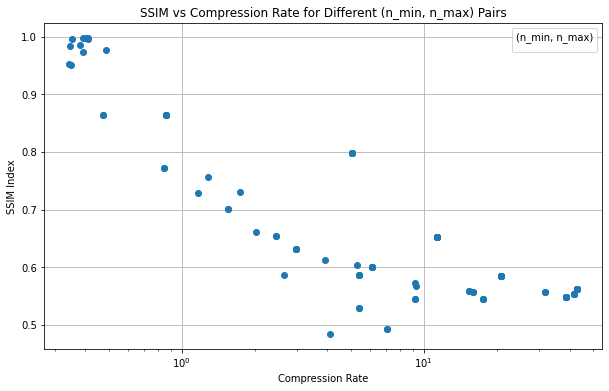

results for image  Clock


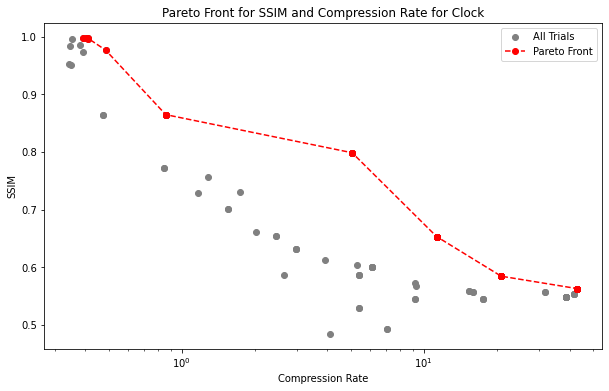

[I 2024-10-31 18:56:07,809] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:San_Diego_time:2024-10-31_18-56-07


image name:  San_Diego
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28312
File saved.


[I 2024-10-31 18:56:08,827] Trial 0 finished with values: [12.810707263181367, 0.13817124822208166] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.974726676940918
SSIM Index : 0.13817124822208166

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33460
File saved.


[I 2024-10-31 18:56:11,080] Trial 1 finished with values: [8.51578606945062, 0.142002367931943] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 2.198183059692383
SSIM Index : 0.142002367931943

image name:  San_Diego
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64200
File saved.


[I 2024-10-31 18:56:15,850] Trial 2 finished with values: [5.203670767254582, 0.15981335870289454] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 4.71090841293335
SSIM Index : 0.15981335870289454

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262637
File saved.


[I 2024-10-31 18:56:22,263] Trial 3 finished with values: [3.003735865736978, 0.3085095074626521] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 6.352805137634277
SSIM Index : 0.3085095074626521

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31372
File saved.


[I 2024-10-31 18:56:29,984] Trial 4 finished with values: [7.27684637173848, 0.1332311235567181] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 7.656931638717651
SSIM Index : 0.1332311235567181

image name:  San_Diego
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 18:56:31,428] Trial 5 finished with values: [34.59599277385449, 0.11313975360191002] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3859033584594727
SSIM Index : 0.11313975360191002

image name:  San_Diego
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136337
File saved.


[I 2024-10-31 18:56:36,538] Trial 6 finished with values: [3.6735957309523393, 0.2141207812543038] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 5.050099611282349
SSIM Index : 0.2141207812543038

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4532
File saved.


[I 2024-10-31 18:56:38,581] Trial 7 finished with values: [61.45725955460469, 0.11394180857174047] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.985658884048462
SSIM Index : 0.11394180857174047

image name:  San_Diego
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16097
File saved.


[I 2024-10-31 18:56:43,453] Trial 8 finished with values: [14.1635850198346, 0.12299323231452708] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 4.815918207168579
SSIM Index : 0.12299323231452708

image name:  San_Diego
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 18:56:44,554] Trial 9 finished with values: [13.920547160667871, 0.12462575794249299] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.0513243675231934
SSIM Index : 0.12462575794249299

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
File saved.


[I 2024-10-31 18:56:46,155] Trial 10 finished with values: [92.86774430565761, 0.1108421409670368] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.529710292816162
SSIM Index : 0.1108421409670368

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 18:56:47,628] Trial 11 finished with values: [60.055592511641166, 0.108675919108012] and parameters: {'min_sparcity': 0.6540337852300198, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3869967460632324
SSIM Index : 0.108675919108012

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:56:49,185] Trial 12 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.6059507601264229, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.778039860056361, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.4243886470794678
SSIM Index : 0.10857232888180603

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:56:50,795] Trial 13 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.6159826350785884, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.425725563862846, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.5185110569000244
SSIM Index : 0.10857232888180603

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:56:52,331] Trial 14 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.5246855280250191, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 3.0938557616450493, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.4523284435272217
SSIM Index : 0.13077381841591335

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:56:53,771] Trial 15 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.5389879840136532, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 4.075980118367214, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3785700798034668
SSIM Index : 0.13077381841591335

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:56:57,623] Trial 16 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.7610231514940821, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 65.29742339491112, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.7803549766540527
SSIM Index : 0.2210922243806362

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1061955
File saved.


[I 2024-10-31 18:57:13,738] Trial 17 finished with values: [1.5507696611429707, 0.639527670466335] and parameters: {'min_sparcity': 0.7699623312488544, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 54.261203761062525, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 16.04352045059204
SSIM Index : 0.639527670466335

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 18:57:15,015] Trial 18 finished with values: [303.1007194244604, 0.10799312618964384] and parameters: {'min_sparcity': 0.35360492078192596, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 56.05550543577921, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1963326930999756
SSIM Index : 0.10799312618964384

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 779382
File saved.


[I 2024-10-31 18:57:23,158] Trial 19 finished with values: [1.6228573629675282, 0.5766164649170439] and parameters: {'min_sparcity': 0.7674661163887234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.04883060684997246, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 8.054931163787842
SSIM Index : 0.5766164649170439

image name:  San_Diego
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 18:57:23,860] Trial 20 finished with values: [275.24608013937285, 0.10806990708895407] and parameters: {'min_sparcity': 0.020966336660231344, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 976.7353569963619, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.6370084285736084
SSIM Index : 0.10806990708895407

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:57:25,272] Trial 21 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.564571427685767, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 1.574614406118836, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3481359481811523
SSIM Index : 0.13077381841591335

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 18:57:26,531] Trial 22 finished with values: [35.23444469223907, 0.1110781504878905] and parameters: {'min_sparcity': 0.4997538246604248, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 2.155290759349093, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1724960803985596
SSIM Index : 0.1110781504878905

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:57:28,042] Trial 23 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.7222135686172191, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 51.497462119424696, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.4292359352111816
SSIM Index : 0.13077381841591335

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 18:57:29,247] Trial 24 finished with values: [303.1007194244604, 0.10799312618964384] and parameters: {'min_sparcity': 0.5764619260613666, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3977092078136707, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1270909309387207
SSIM Index : 0.10799312618964384

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:57:32,968] Trial 25 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.33930451350447194, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 19.42213991108101, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.635936975479126
SSIM Index : 0.2210922243806362

image name:  San_Diego
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 18:57:34,274] Trial 26 finished with values: [34.59599277385449, 0.11313975360191002] and parameters: {'min_sparcity': 0.479711681759038, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.0868184222099575, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.2207863330841064
SSIM Index : 0.11313975360191002

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 18:57:35,625] Trial 27 finished with values: [35.23444469223907, 0.1110781504878905] and parameters: {'min_sparcity': 0.8657458530350106, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.013115629124856774, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.2515265941619873
SSIM Index : 0.1110781504878905

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:57:36,854] Trial 28 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.4396495379277111, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.8288518615045763, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1341540813446045
SSIM Index : 0.10857232888180603

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 18:57:38,288] Trial 29 finished with values: [34.59599277385449, 0.11313975360191002] and parameters: {'min_sparcity': 0.6294548592178973, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.8109501141512195, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3261144161224365
SSIM Index : 0.11313975360191002

image name:  San_Diego
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 779382
File saved.


[I 2024-10-31 18:57:46,299] Trial 30 finished with values: [1.6228573629675282, 0.5766164649170439] and parameters: {'min_sparcity': 0.7073124053820253, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 5.569230494942067, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 7.918062925338745
SSIM Index : 0.5766164649170439

image name:  San_Diego
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 77302
File saved.


[I 2024-10-31 18:57:49,027] Trial 31 finished with values: [5.61337513989803, 0.18077030536653854] and parameters: {'min_sparcity': 0.7886277450113612, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 88.24753414086301, 'exponent_a_cols': 5}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 2.6385133266448975
SSIM Index : 0.18077030536653854

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 18:57:50,744] Trial 32 finished with values: [5.974051141466181, 0.18484467855652603] and parameters: {'min_sparcity': 0.8982493527108015, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 24.440941026874945, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.6268692016601562
SSIM Index : 0.18484467855652603

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:57:54,303] Trial 33 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.219172944156943, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 914.068305736716, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.4871370792388916
SSIM Index : 0.2210922243806362

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507522
File saved.


[I 2024-10-31 18:58:09,184] Trial 34 finished with values: [2.4076049480545705, 0.46213335213738416] and parameters: {'min_sparcity': 0.5960827314725862, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.003620817620032234, 'exponent_a_cols': 8}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 14.743821144104004
SSIM Index : 0.46213335213738416

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1933735
File saved.


[I 2024-10-31 18:58:38,276] Trial 35 finished with values: [1.0085475950712486, 0.9919163427035579] and parameters: {'min_sparcity': 0.80688412059434, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 99.26599105426662, 'exponent_a_cols': 8}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 28.993046522140503
SSIM Index : 0.9919163427035579

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 136337
File saved.


[I 2024-10-31 18:58:42,144] Trial 36 finished with values: [3.6735957309523393, 0.2141207812543038] and parameters: {'min_sparcity': 0.7084794837931848, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 9.165562955977354, 'exponent_a_cols': 6}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.764805793762207
SSIM Index : 0.2141207812543038

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 18:58:43,893] Trial 37 finished with values: [5.974051141466181, 0.18484467855652603] and parameters: {'min_sparcity': 0.9163796450909822, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0059388701290070825, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.6706771850585938
SSIM Index : 0.18484467855652603

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28312
File saved.


[I 2024-10-31 18:58:44,943] Trial 38 finished with values: [12.810707263181367, 0.13817124822208166] and parameters: {'min_sparcity': 0.6068684527885857, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 30.468097942130917, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.9747004508972168
SSIM Index : 0.13817124822208166

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 18530
File saved.


[I 2024-10-31 18:58:47,169] Trial 39 finished with values: [16.688188227838072, 0.13225853063182338] and parameters: {'min_sparcity': 0.5198156046852049, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.931136240919522, 'exponent_a_cols': 5}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 2.132861375808716
SSIM Index : 0.13225853063182338

image name:  San_Diego
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:58:51,422] Trial 40 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.4223671607511006, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 158.55139236117432, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 4.158822298049927
SSIM Index : 0.2210922243806362

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1066000
File saved.


[I 2024-10-31 18:59:08,159] Trial 41 finished with values: [1.5515730188114096, 0.6395337737624333] and parameters: {'min_sparcity': 0.7631277908521881, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 47.974574497814544, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 16.654787302017212
SSIM Index : 0.6395337737624333

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:59:09,377] Trial 42 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.674655493978339, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 429.17152848264965, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1391196250915527
SSIM Index : 0.10857232888180603

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:59:10,911] Trial 43 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.36223792795240234, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0011724646068832466, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.4389452934265137
SSIM Index : 0.13077381841591335

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64200
File saved.


[I 2024-10-31 18:59:14,559] Trial 44 finished with values: [5.203670767254582, 0.15981335870289454] and parameters: {'min_sparcity': 0.8279002598648566, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 33.66454358912642, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.543762683868408
SSIM Index : 0.15981335870289454

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 18:59:15,930] Trial 45 finished with values: [303.1007194244604, 0.10799312618964384] and parameters: {'min_sparcity': 0.7366221286740028, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 11.284067637686752, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.2709109783172607
SSIM Index : 0.10799312618964384

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 18:59:17,245] Trial 46 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.6511235643697901, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.154724305065621, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.2171988487243652
SSIM Index : 0.10857232888180603

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 18:59:18,294] Trial 47 finished with values: [13.920547160667871, 0.12462575794249299] and parameters: {'min_sparcity': 0.5819591451492949, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 120.14121962489972, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.9535338878631592
SSIM Index : 0.12462575794249299

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 18:59:21,919] Trial 48 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.4809115063449499, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.0709022653291922, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.5550997257232666
SSIM Index : 0.2210922243806362

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2063725
File saved.


[I 2024-10-31 18:59:45,140] Trial 49 finished with values: [1.1103253679474183, 0.8681059447687116] and parameters: {'min_sparcity': 0.5334158749774689, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.36620096483762793, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 23.14221978187561
SSIM Index : 0.8681059447687116

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31372
File saved.


[I 2024-10-31 18:59:53,980] Trial 50 finished with values: [7.27684637173848, 0.1332311235567181] and parameters: {'min_sparcity': 0.7506747765802788, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.16358101851613857, 'exponent_a_cols': 8}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 8.750460863113403
SSIM Index : 0.1332311235567181

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 18:59:54,930] Trial 51 finished with values: [197.30408991570403, 0.11167203601277018] and parameters: {'min_sparcity': 0.9252706067729232, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 6.525444437374636, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.8586997985839844
SSIM Index : 0.11167203601277018

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 18:59:56,462] Trial 52 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.9617008465416599, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 465.4341469337648, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.461803674697876
SSIM Index : 0.13077381841591335

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 136337
File saved.


[I 2024-10-31 19:00:00,359] Trial 53 finished with values: [3.6735957309523393, 0.2141207812543038] and parameters: {'min_sparcity': 0.8605904095492988, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 46.24813669032143, 'exponent_a_cols': 6}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.8046798706054688
SSIM Index : 0.2141207812543038

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081335
File saved.


[I 2024-10-31 19:00:17,270] Trial 54 finished with values: [1.5567404188651917, 0.6395735565239778] and parameters: {'min_sparcity': 0.2957543131718676, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.1365558704393495, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 16.825783252716064
SSIM Index : 0.6395735565239778

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:00:18,174] Trial 55 finished with values: [197.30408991570403, 0.11167203601277018] and parameters: {'min_sparcity': 0.13843731410452875, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 6.6314457814594805, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.8265519142150879
SSIM Index : 0.11167203601277018

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:00:19,898] Trial 56 finished with values: [5.974051141466181, 0.18484467855652603] and parameters: {'min_sparcity': 0.6878353216664639, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 15.409720824522038, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.6471540927886963
SSIM Index : 0.18484467855652603

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:00:20,630] Trial 57 finished with values: [275.24608013937285, 0.10806990708895407] and parameters: {'min_sparcity': 0.9477261848126968, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.003723761491969891, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.6570460796356201
SSIM Index : 0.10806990708895407

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:00:21,524] Trial 58 finished with values: [197.30408991570403, 0.11167203601277018] and parameters: {'min_sparcity': 0.383073831790762, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 213.7890663935879, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.8230628967285156
SSIM Index : 0.11167203601277018

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16097
File saved.


[I 2024-10-31 19:00:25,407] Trial 59 finished with values: [14.1635850198346, 0.12299323231452708] and parameters: {'min_sparcity': 0.3227433484587873, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.024925654052330506, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.8094711303710938
SSIM Index : 0.12299323231452708

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:00:27,188] Trial 60 finished with values: [5.974051141466181, 0.18484467855652603] and parameters: {'min_sparcity': 0.0301938475951809, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.552956681979915, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.6857006549835205
SSIM Index : 0.18484467855652603

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:00:28,070] Trial 61 finished with values: [197.30408991570403, 0.11167203601277018] and parameters: {'min_sparcity': 0.5578386796324821, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.841854021910046, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.8101263046264648
SSIM Index : 0.11167203601277018

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:00:28,802] Trial 62 finished with values: [275.24608013937285, 0.10806990708895407] and parameters: {'min_sparcity': 0.28466073355848287, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.3951366477506524, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.6555948257446289
SSIM Index : 0.10806990708895407

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:00:29,792] Trial 63 finished with values: [13.920547160667871, 0.12462575794249299] and parameters: {'min_sparcity': 0.6092738716204577, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.039749409626272, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.9103541374206543
SSIM Index : 0.12462575794249299

image name:  San_Diego
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:00:33,447] Trial 64 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.463768861885821, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.1898511919194042, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.580033540725708
SSIM Index : 0.2210922243806362

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:00:34,958] Trial 65 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.830582812050885, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 8.79077823039969, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.44132399559021
SSIM Index : 0.13077381841591335

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40052
File saved.


[I 2024-10-31 19:00:36,800] Trial 66 finished with values: [9.315109886060464, 0.15979710658976218] and parameters: {'min_sparcity': 0.9028125433920925, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 73.21157789583701, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.7519571781158447
SSIM Index : 0.15979710658976218

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:00:38,094] Trial 67 finished with values: [303.1007194244604, 0.10799312618964384] and parameters: {'min_sparcity': 0.6452696682853395, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.337068991232755, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.1852498054504395
SSIM Index : 0.10799312618964384

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33460
File saved.


[I 2024-10-31 19:00:40,538] Trial 68 finished with values: [8.51578606945062, 0.142002367931943] and parameters: {'min_sparcity': 0.9914728599198, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 432.2620284489137, 'exponent_a_cols': 6}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 2.338472366333008
SSIM Index : 0.142002367931943

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:00:44,349] Trial 69 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.7896361316030626, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.08900408230485254, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.715395450592041
SSIM Index : 0.2210922243806362

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:00:45,098] Trial 70 finished with values: [275.24608013937285, 0.10806990708895407] and parameters: {'min_sparcity': 0.5997434482690024, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 27.522993713731125, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.669090986251831
SSIM Index : 0.10806990708895407

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3390880
File saved.


[I 2024-10-31 19:01:24,847] Trial 71 finished with values: [0.9993753558099816, 0.9996278375666123] and parameters: {'min_sparcity': 0.15412757872930244, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.5910397959357763, 'exponent_a_cols': 8}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 39.665395736694336
SSIM Index : 0.9996278375666123

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 98330
File saved.


[I 2024-10-31 19:01:26,823] Trial 72 finished with values: [5.154479833612006, 0.22069516256519123] and parameters: {'min_sparcity': 0.5179227239022797, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.5465730705852954, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.9060938358306885
SSIM Index : 0.22069516256519123

image name:  San_Diego
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:01:30,505] Trial 73 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.5380826477431675, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 154.97878374179567, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.617994785308838
SSIM Index : 0.2210922243806362

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:01:31,849] Trial 74 finished with values: [60.055592511641166, 0.108675919108012] and parameters: {'min_sparcity': 0.4136565593688347, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 4.433699989322407, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.2674689292907715
SSIM Index : 0.108675919108012

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:01:32,777] Trial 75 finished with values: [197.30408991570403, 0.11167203601277018] and parameters: {'min_sparcity': 0.6808008640195665, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 19.499055159871915, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.8378143310546875
SSIM Index : 0.11167203601277018

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1068205
File saved.


[I 2024-10-31 19:01:52,520] Trial 76 finished with values: [1.50434546636102, 0.6858962215152128] and parameters: {'min_sparcity': 0.9252911803277968, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.00229310809414097, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 19.650371551513672
SSIM Index : 0.6858962215152128

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311535
File saved.


[I 2024-10-31 19:01:56,245] Trial 77 finished with values: [2.4656467999438174, 0.3484024383536401] and parameters: {'min_sparcity': 0.49748869107795757, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 648.950136339678, 'exponent_a_cols': 5}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.6455626487731934
SSIM Index : 0.3484024383536401

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:01:57,454] Trial 78 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.9327822403718768, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 274.6673528577317, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.137998104095459
SSIM Index : 0.10857232888180603

image name:  San_Diego
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:01:58,745] Trial 79 finished with values: [13.920547160667871, 0.12462575794249299] and parameters: {'min_sparcity': 0.4449903042582454, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002230444869300506, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.195136547088623
SSIM Index : 0.12462575794249299

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3640542
File saved.


[I 2024-10-31 19:02:28,184] Trial 80 finished with values: [0.9996235386418603, 0.999727018674804] and parameters: {'min_sparcity': 0.24532650746144508, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 1.2651222135832598, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 29.361798763275146
SSIM Index : 0.999727018674804

image name:  San_Diego
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:02:29,732] Trial 81 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.5532394431915407, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.066717011658889, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.4781639575958252
SSIM Index : 0.13077381841591335

image name:  San_Diego
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
File saved.


[I 2024-10-31 19:02:31,171] Trial 82 finished with values: [92.86774430565761, 0.1108421409670368] and parameters: {'min_sparcity': 0.7296712222239236, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.28127512023143836, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.3663921356201172
SSIM Index : 0.1108421409670368

image name:  San_Diego
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:02:31,967] Trial 83 finished with values: [275.24608013937285, 0.10806990708895407] and parameters: {'min_sparcity': 0.8837928643655864, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.008754169405792753, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 0.7025113105773926
SSIM Index : 0.10806990708895407

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3812072
File saved.


[I 2024-10-31 19:03:02,051] Trial 84 finished with values: [0.9996093082700107, 0.9997449919593525] and parameters: {'min_sparcity': 0.6296849115544632, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.044084366627203865, 'exponent_a_cols': 7}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 30.005019664764404
SSIM Index : 0.9997449919593525

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:03:14,536] Trial 85 finished with values: [10.62536778922945, 0.44478296782504734] and parameters: {'min_sparcity': 0.7803057053965947, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 62.690103378706965, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 12.408707618713379
SSIM Index : 0.44478296782504734

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1073125
File saved.


[I 2024-10-31 19:03:30,538] Trial 86 finished with values: [1.5530333748645322, 0.6395607623085725] and parameters: {'min_sparcity': 0.83324381982885, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 36.20881086199334, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 15.917192220687866
SSIM Index : 0.6395607623085725

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2395920
File saved.


[I 2024-10-31 19:03:54,013] Trial 87 finished with values: [1.0290360557078027, 0.9300639490050994] and parameters: {'min_sparcity': 0.7650681108675055, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 91.23994056243242, 'exponent_a_cols': 4}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 23.395633220672607
SSIM Index : 0.9300639490050994

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1056505
File saved.


[I 2024-10-31 19:04:09,680] Trial 88 finished with values: [1.5498150909340604, 0.639494004317593] and parameters: {'min_sparcity': 0.8028367508306783, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 61.77450068258838, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 15.587328672409058
SSIM Index : 0.639494004317593

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:04:22,336] Trial 89 finished with values: [10.62536778922945, 0.44478296782504734] and parameters: {'min_sparcity': 0.8608942190312219, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 139.6770848745086, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 12.583485841751099
SSIM Index : 0.44478296782504734

image name:  San_Diego
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:04:25,955] Trial 90 finished with values: [33.609796309099615, 0.2210922243806362] and parameters: {'min_sparcity': 0.7076055844489275, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 11.604105504993818, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 3.548982620239258
SSIM Index : 0.2210922243806362

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1781595
File saved.


[I 2024-10-31 19:04:46,522] Trial 91 finished with values: [1.1132082783597588, 0.8673653650217947] and parameters: {'min_sparcity': 0.7457378064101042, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 96.55909029343044, 'exponent_a_cols': 3}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 20.4868061542511
SSIM Index : 0.8673653650217947

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:05:00,005] Trial 92 finished with values: [10.62536778922945, 0.44478296782504734] and parameters: {'min_sparcity': 0.7994374326830542, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 96.90321338819341, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 13.410562753677368
SSIM Index : 0.44478296782504734

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:05:12,093] Trial 93 finished with values: [10.62536778922945, 0.44478296782504734] and parameters: {'min_sparcity': 0.7549851574799111, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 22.968128832944025, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 12.012015581130981
SSIM Index : 0.44478296782504734

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:05:24,440] Trial 94 finished with values: [10.62536778922945, 0.44478296782504734] and parameters: {'min_sparcity': 0.8162228732166554, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 48.66465504604631, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 12.270299673080444
SSIM Index : 0.44478296782504734

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 971645
File saved.


[I 2024-10-31 19:05:39,600] Trial 95 finished with values: [1.5571086439099389, 0.6388008738812204] and parameters: {'min_sparcity': 0.7427401661252813, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 176.3191248240513, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 15.080965995788574
SSIM Index : 0.6388008738812204

image name:  San_Diego
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:05:40,773] Trial 96 finished with values: [318.20996978851963, 0.10857232888180603] and parameters: {'min_sparcity': 0.7761413009577794, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 35.752779940055866, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.0862948894500732
SSIM Index : 0.10857232888180603

image name:  San_Diego
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 269642
File saved.


[I 2024-10-31 19:05:45,601] Trial 97 finished with values: [3.0008262225957636, 0.3486795710242408] and parameters: {'min_sparcity': 0.7222231831633815, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 109.48695287589307, 'exponent_a_cols': 2}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 4.7284626960754395
SSIM Index : 0.3486795710242408

image name:  San_Diego
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:05:47,056] Trial 98 finished with values: [94.60553892215569, 0.13077381841591335] and parameters: {'min_sparcity': 0.6630012242529033, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.7020866466895876, 'exponent_a_cols': 1}.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 1.383333683013916
SSIM Index : 0.13077381841591335

image name:  San_Diego
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1530705
File saved.


[I 2024-10-31 19:06:05,975] Trial 99 finished with values: [1.1213920937478927, 0.8651788317833535] and parameters: {'min_sparcity': 0.8391285668881198, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 200.52583123188245, 'exponent_a_cols': 3}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/San_Diego_reconstructed.png
execution_time 18.841972589492798
SSIM Index : 0.8651788317833535



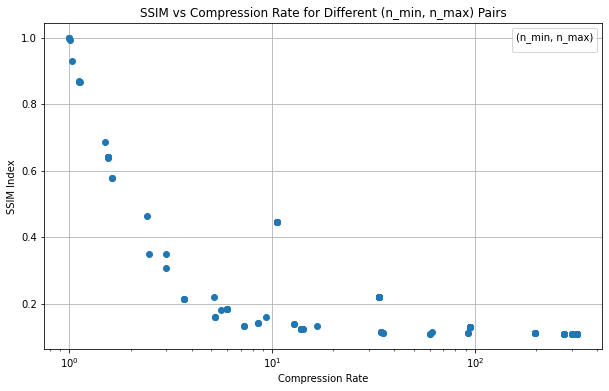

results for image  San_Diego


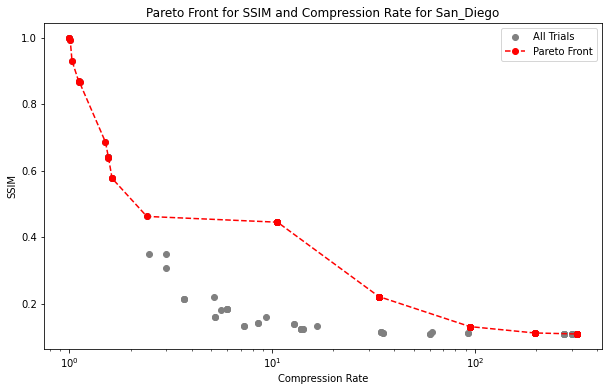

[I 2024-10-31 19:06:06,441] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Splash_time:2024-10-31_19-06-06


image name:  Splash
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28122
File saved.


[I 2024-10-31 19:06:07,448] Trial 0 finished with values: [8.522780222624903, 0.5927220482431144] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.9594683647155762
SSIM Index : 0.5927220482431144

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
File saved.


[I 2024-10-31 19:06:09,697] Trial 1 finished with values: [5.355083562627919, 0.5271259034746898] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.1962673664093018
SSIM Index : 0.5271259034746898

image name:  Splash
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64150
File saved.


[I 2024-10-31 19:06:13,019] Trial 2 finished with values: [3.2043375291980274, 0.6190728038247983] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.2662980556488037
SSIM Index : 0.6190728038247983

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262647
File saved.


[I 2024-10-31 19:06:19,316] Trial 3 finished with values: [2.241396525705468, 0.7267640790160531] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 6.223676443099976
SSIM Index : 0.7267640790160531

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31367
File saved.


[I 2024-10-31 19:06:26,709] Trial 4 finished with values: [3.843621399176955, 0.6106890062931141] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 7.3265299797058105
SSIM Index : 0.6106890062931141

image name:  Splash
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:06:28,126] Trial 5 finished with values: [18.456600953003832, 0.5659040596236232] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.352090835571289
SSIM Index : 0.5659040596236232

image name:  Splash
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136282
File saved.


[I 2024-10-31 19:06:32,178] Trial 6 finished with values: [2.635443696593312, 0.6704230552407576] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.9811816215515137
SSIM Index : 0.6704230552407576

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4552
File saved.


[I 2024-10-31 19:06:34,173] Trial 7 finished with values: [21.49989116238572, 0.5609620170266687] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.9378952980041504
SSIM Index : 0.5609620170266687

image name:  Splash
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:06:39,105] Trial 8 finished with values: [7.087181143041653, 0.5008168724064581] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.875635623931885
SSIM Index : 0.5008168724064581

image name:  Splash
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:06:40,167] Trial 9 finished with values: [10.503868343391913, 0.5905710437146501] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.0128297805786133
SSIM Index : 0.5905710437146501

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:06:41,714] Trial 10 finished with values: [31.413055577641728, 0.568226075306857] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4794471263885498
SSIM Index : 0.568226075306857

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:06:43,088] Trial 11 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.6786440830104932, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.2832393646240234
SSIM Index : 0.5709045011826551

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:06:44,474] Trial 12 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.6433077671486415, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.0141401748985, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.2888011932373047
SSIM Index : 0.5709045011826551

image name:  Splash
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:06:46,067] Trial 13 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.6256686784685921, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 13.265287901477882, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.506563663482666
SSIM Index : 0.6222320056085507

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:06:49,740] Trial 14 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.6203109251296234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.605276584625244
SSIM Index : 0.6735716480235855

image name:  Splash
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:06:51,511] Trial 15 finished with values: [5.275920089738796, 0.6567426757221861] and parameters: {'min_sparcity': 0.7674028378760763, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 6.795065796278994, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.7050199508666992
SSIM Index : 0.6567426757221861

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:06:52,733] Trial 16 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.5709255861884776, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 43.69501199322717, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.1469976902008057
SSIM Index : 0.5709045011826551

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081315
File saved.


[I 2024-10-31 19:07:08,957] Trial 17 finished with values: [1.4172633482085204, 0.8683519712438041] and parameters: {'min_sparcity': 0.35147818541471576, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.168110598733529, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 16.132603406906128
SSIM Index : 0.8683519712438041

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
File saved.


[I 2024-10-31 19:07:10,941] Trial 18 finished with values: [4.1688069135072965, 0.6784264279190778] and parameters: {'min_sparcity': 0.5134493239719418, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 56.05550543577921, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.916656494140625
SSIM Index : 0.6784264279190778

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:07:12,388] Trial 19 finished with values: [31.413055577641728, 0.568226075306857] and parameters: {'min_sparcity': 0.7402863973316733, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.035168375868930096, 'exponent_a_cols': 4}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.3815200328826904
SSIM Index : 0.568226075306857

image name:  Splash
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:07:13,138] Trial 20 finished with values: [172.90240700218817, 0.5691481948859379] and parameters: {'min_sparcity': 0.8470607838820379, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 2.2426355226918235, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.6674153804779053
SSIM Index : 0.5691481948859379

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:07:16,824] Trial 21 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.6066653537315065, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 40.09575746070031, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.621354818344116
SSIM Index : 0.6735716480235855

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:07:18,109] Trial 22 finished with values: [20.741390172196557, 0.5605213374632921] and parameters: {'min_sparcity': 0.012130548355998527, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 736.5524464696595, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.2053873538970947
SSIM Index : 0.5605213374632921

image name:  Splash
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:07:19,619] Trial 23 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.5354331624711387, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 4.748406629479158, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4227473735809326
SSIM Index : 0.6222320056085507

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:07:20,857] Trial 24 finished with values: [190.2176215695715, 0.5712634750505503] and parameters: {'min_sparcity': 0.6998159710953578, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 64.40839204991288, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.160231113433838
SSIM Index : 0.5712634750505503

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 478127
File saved.


[I 2024-10-31 19:07:27,002] Trial 25 finished with values: [1.8847443719856312, 0.7819764238403375] and parameters: {'min_sparcity': 0.7839301098550727, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.9955387677148444, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 6.0599446296691895
SSIM Index : 0.7819764238403375

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:07:28,153] Trial 26 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.45421177181509814, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 17.15279841693491, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.077538013458252
SSIM Index : 0.5709045011826551

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:07:29,561] Trial 27 finished with values: [20.741390172196557, 0.5605213374632921] and parameters: {'min_sparcity': 0.6097761639823716, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.1414793842631393, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.3097364902496338
SSIM Index : 0.5605213374632921

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:07:33,298] Trial 28 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.8897362956476971, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.6979276678713573, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.655712604522705
SSIM Index : 0.6735716480235855

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:07:34,610] Trial 29 finished with values: [18.456600953003832, 0.5659040596236232] and parameters: {'min_sparcity': 0.7010013339852683, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0121458827137354, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.2330901622772217
SSIM Index : 0.5659040596236232

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4552
File saved.


[I 2024-10-31 19:07:36,644] Trial 30 finished with values: [21.49989116238572, 0.5609620170266687] and parameters: {'min_sparcity': 0.3078687812445219, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 100.82835005970016, 'exponent_a_cols': 5}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.9421579837799072
SSIM Index : 0.5609620170266687

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 477182
File saved.


[I 2024-10-31 19:07:42,595] Trial 31 finished with values: [1.8851580579744722, 0.7819751555596863] and parameters: {'min_sparcity': 0.7995346232582514, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 15.940202503204075, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 5.860641956329346
SSIM Index : 0.7819751555596863

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:07:43,553] Trial 32 finished with values: [10.503868343391913, 0.5905710437146501] and parameters: {'min_sparcity': 0.5688634495003281, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.549228951697806, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8876755237579346
SSIM Index : 0.5905710437146501

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:07:44,999] Trial 33 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.8066383714697403, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 20.40155068357846, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.3783249855041504
SSIM Index : 0.6222320056085507

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507612
File saved.


[I 2024-10-31 19:08:03,982] Trial 34 finished with values: [1.9376167846160637, 0.7784527872950663] and parameters: {'min_sparcity': 0.9262498978034777, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 112.0843209075026, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 18.899774074554443
SSIM Index : 0.7784527872950663

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507612
File saved.


[I 2024-10-31 19:08:19,422] Trial 35 finished with values: [1.9376167846160637, 0.7784527872950663] and parameters: {'min_sparcity': 0.9066554483631968, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 110.37759688680822, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 15.350609064102173
SSIM Index : 0.7784527872950663

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:08:21,318] Trial 36 finished with values: [31.413055577641728, 0.568226075306857] and parameters: {'min_sparcity': 0.45160333270672276, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.4849397047439395, 'exponent_a_cols': 4}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.8140103816986084
SSIM Index : 0.568226075306857

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-31 19:08:24,106] Trial 37 finished with values: [12.568220136790202, 0.5445323564482394] and parameters: {'min_sparcity': 0.3819612208945513, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.07739983095927477, 'exponent_a_cols': 6}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.687614679336548
SSIM Index : 0.5445323564482394

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:08:25,562] Trial 38 finished with values: [20.741390172196557, 0.5605213374632921] and parameters: {'min_sparcity': 0.4792463894283866, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0012211824849688467, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.3404240608215332
SSIM Index : 0.5605213374632921

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:08:38,160] Trial 39 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.6445938064546277, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.008937022528639213, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.508696794509888
SSIM Index : 0.8018527103574075

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:08:50,786] Trial 40 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.1707433190284411, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.003565868304901655, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.55322003364563
SSIM Index : 0.8018527103574075

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:08:52,495] Trial 41 finished with values: [5.275920089738796, 0.6567426757221861] and parameters: {'min_sparcity': 0.7233260807134172, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.5526669133965307, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.6370465755462646
SSIM Index : 0.6567426757221861

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:08:53,366] Trial 42 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.6604612674567865, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 4.497086057965819, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8075251579284668
SSIM Index : 0.5744016516038316

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:08:54,074] Trial 43 finished with values: [172.90240700218817, 0.5691481948859379] and parameters: {'min_sparcity': 0.6499776724672688, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.707071496555734, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.6407418251037598
SSIM Index : 0.5691481948859379

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:08:58,305] Trial 44 finished with values: [7.087181143041653, 0.5008168724064581] and parameters: {'min_sparcity': 0.6241646949894927, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 28.519043184891792, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.158597946166992
SSIM Index : 0.5008168724064581

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:08:59,248] Trial 45 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.5575757218576085, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 9.068419056865167, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8588259220123291
SSIM Index : 0.5744016516038316

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:09:00,443] Trial 46 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.6871234922054897, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 424.06418107018317, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.119281530380249
SSIM Index : 0.5709045011826551

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 18540
File saved.


[I 2024-10-31 19:09:02,389] Trial 47 finished with values: [7.907966373098478, 0.5600184100638994] and parameters: {'min_sparcity': 0.7352059890942645, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.77932504640772, 'exponent_a_cols': 5}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.841374397277832
SSIM Index : 0.5600184100638994

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:09:03,434] Trial 48 finished with values: [10.503868343391913, 0.5905710437146501] and parameters: {'min_sparcity': 0.6614560808862165, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 8.711596149823517, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.9506666660308838
SSIM Index : 0.5905710437146501

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:09:07,125] Trial 49 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.5917543523353911, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 30.161028557964887, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.618849992752075
SSIM Index : 0.6735716480235855

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:09:08,340] Trial 50 finished with values: [190.2176215695715, 0.5712634750505503] and parameters: {'min_sparcity': 0.5000089322105781, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.5386769808643086, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.139862060546875
SSIM Index : 0.5712634750505503

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:09:09,880] Trial 51 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.40846546713187176, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.2455042738513564, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4506511688232422
SSIM Index : 0.6222320056085507

image name:  Splash
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67595
File saved.


[I 2024-10-31 19:09:11,586] Trial 52 finished with values: [5.275990545250591, 0.6567426977051631] and parameters: {'min_sparcity': 0.6885243029962855, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 70.68980900276327, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.6302714347839355
SSIM Index : 0.6567426977051631

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:09:13,109] Trial 53 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.5339994252594873, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 8.418957742288729, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4558639526367188
SSIM Index : 0.6222320056085507

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 693220
File saved.


[I 2024-10-31 19:09:26,341] Trial 54 finished with values: [1.4474784297202734, 0.8495582558640057] and parameters: {'min_sparcity': 0.6305573053724314, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 215.7937049836696, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 13.157247066497803
SSIM Index : 0.8495582558640057

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:09:27,188] Trial 55 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.7527388919792116, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.006003547681829493, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.781456708908081
SSIM Index : 0.5744016516038316

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 1889932
File saved.


[I 2024-10-31 19:09:43,533] Trial 56 finished with values: [1.0167117872914244, 0.9942724311907416] and parameters: {'min_sparcity': 0.05364523246537367, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 25.540034767180547, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 16.27003765106201
SSIM Index : 0.9942724311907416

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:09:56,089] Trial 57 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.8255197972330022, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0251832486311877, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.485643863677979
SSIM Index : 0.8018527103574075

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:09:57,293] Trial 58 finished with values: [190.2176215695715, 0.5712634750505503] and parameters: {'min_sparcity': 0.5872700923215782, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.3795877691917875, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.1236634254455566
SSIM Index : 0.5712634750505503

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:09:58,019] Trial 59 finished with values: [172.90240700218817, 0.5691481948859379] and parameters: {'min_sparcity': 0.34066219366155953, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.924996069147844, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.6428215503692627
SSIM Index : 0.5691481948859379

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-31 19:10:00,502] Trial 60 finished with values: [12.568220136790202, 0.5445323564482394] and parameters: {'min_sparcity': 0.24740914190886182, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 10.726504368451732, 'exponent_a_cols': 6}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.404555559158325
SSIM Index : 0.5445323564482394

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:10:12,796] Trial 61 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.658886375633523, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.09594153756420247, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.204992771148682
SSIM Index : 0.8018527103574075

image name:  Splash
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 266342
File saved.


[I 2024-10-31 19:10:17,333] Trial 62 finished with values: [2.6257053041530702, 0.742401439179424] and parameters: {'min_sparcity': 0.7110917674534603, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 60.288049944594604, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.463046550750732
SSIM Index : 0.742401439179424

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:10:29,948] Trial 63 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.5132846402497981, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.620384826245529, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.548086166381836
SSIM Index : 0.8018527103574075

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:10:31,563] Trial 64 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.6111395130028794, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.311196664335979, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.5461628437042236
SSIM Index : 0.6222320056085507

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:10:32,556] Trial 65 finished with values: [10.503868343391913, 0.5905710437146501] and parameters: {'min_sparcity': 0.7627033272509661, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0020467055414347428, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.9195616245269775
SSIM Index : 0.5905710437146501

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:10:36,176] Trial 66 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.5509760683050888, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.037161475670405744, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.552703619003296
SSIM Index : 0.6735716480235855

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:10:37,902] Trial 67 finished with values: [5.275920089738796, 0.6567426757221861] and parameters: {'min_sparcity': 0.6724352905965277, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 13.570984389433969, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.6542904376983643
SSIM Index : 0.6567426757221861

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28122
File saved.


[I 2024-10-31 19:10:39,052] Trial 68 finished with values: [8.522780222624903, 0.5927220482431144] and parameters: {'min_sparcity': 0.17924206402239462, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 36.31936643891813, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.0671107769012451
SSIM Index : 0.5927220482431144

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 296932
File saved.


[I 2024-10-31 19:10:43,903] Trial 69 finished with values: [2.4342698706099815, 0.8217509137800304] and parameters: {'min_sparcity': 0.5813580940799867, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 976.6061570900735, 'exponent_a_cols': 4}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.771424770355225
SSIM Index : 0.8217509137800304

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:10:45,385] Trial 70 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.480894211384826, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.9044655387299408, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4113564491271973
SSIM Index : 0.6222320056085507

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1858950
File saved.


[I 2024-10-31 19:11:06,246] Trial 71 finished with values: [1.0285674118544477, 0.9621655946618984] and parameters: {'min_sparcity': 0.5833739297336443, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 21.92015392187654, 'exponent_a_cols': 4}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 20.786644458770752
SSIM Index : 0.9621655946618984

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:11:07,036] Trial 72 finished with values: [172.90240700218817, 0.5691481948859379] and parameters: {'min_sparcity': 0.6365314507479828, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 6.294388934351997, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.7205793857574463
SSIM Index : 0.5691481948859379

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:11:08,185] Trial 73 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.709924532506468, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.009044261653805575, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.0709893703460693
SSIM Index : 0.5709045011826551

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:11:09,079] Trial 74 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.6108673021633, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.897842844849338, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8048114776611328
SSIM Index : 0.5744016516038316

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270282
File saved.


[I 2024-10-31 19:11:13,667] Trial 75 finished with values: [2.6226202172008177, 0.7424284231074973] and parameters: {'min_sparcity': 0.5339703897759114, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 12.044818895675672, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.503351449966431
SSIM Index : 0.7424284231074973

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:11:15,118] Trial 76 finished with values: [18.456600953003832, 0.5659040596236232] and parameters: {'min_sparcity': 0.6445809667945887, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 43.07901138211246, 'exponent_a_cols': 3}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.355006217956543
SSIM Index : 0.5659040596236232

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:11:16,025] Trial 77 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.6864366558332055, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 17.004229971169735, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8124706745147705
SSIM Index : 0.5744016516038316

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 309725
File saved.


[I 2024-10-31 19:11:19,446] Trial 78 finished with values: [1.979418322102257, 0.7609911937862373] and parameters: {'min_sparcity': 0.7808258627148162, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 177.91405144767458, 'exponent_a_cols': 5}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.3438422679901123
SSIM Index : 0.7609911937862373

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:11:23,064] Trial 79 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.9699552786256606, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.02372029924594322, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.551286220550537
SSIM Index : 0.6735716480235855

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:11:24,342] Trial 80 finished with values: [20.741390172196557, 0.5605213374632921] and parameters: {'min_sparcity': 0.8602298385497144, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 71.81344720019865, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.193603515625
SSIM Index : 0.5605213374632921

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1869585
File saved.


[I 2024-10-31 19:12:08,200] Trial 81 finished with values: [1.2282596530498042, 0.9447189479411666] and parameters: {'min_sparcity': 0.5700973405116266, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 4.150064992711372, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 43.74431538581848
SSIM Index : 0.9447189479411666

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:12:09,143] Trial 82 finished with values: [130.39009900990098, 0.5744016516038316] and parameters: {'min_sparcity': 0.5589368589989036, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 6.198826983592181, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.8617360591888428
SSIM Index : 0.5744016516038316

image name:  Splash
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:12:21,496] Trial 83 finished with values: [9.39530570022116, 0.8018527103574075] and parameters: {'min_sparcity': 0.7326528865681765, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 4.059510948201922, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 12.283522367477417
SSIM Index : 0.8018527103574075

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 8312
File saved.


[I 2024-10-31 19:12:24,378] Trial 84 finished with values: [12.568220136790202, 0.5445323564482394] and parameters: {'min_sparcity': 0.5944869492821669, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.0112812472651695, 'exponent_a_cols': 6}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.796313524246216
SSIM Index : 0.5445323564482394

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 785395
File saved.


[I 2024-10-31 19:12:43,387] Trial 85 finished with values: [1.4770083143916737, 0.932551630251378] and parameters: {'min_sparcity': 0.662956801637228, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 979.2196979338447, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 18.88540554046631
SSIM Index : 0.932551630251378

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:12:44,921] Trial 86 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.024828828588374263, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 23.27495326577653, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4526851177215576
SSIM Index : 0.6222320056085507

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:12:48,738] Trial 87 finished with values: [7.087181143041653, 0.5008168724064581] and parameters: {'min_sparcity': 0.04717049337627488, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 581.868094924915, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.7418174743652344
SSIM Index : 0.5008168724064581

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262647
File saved.


[I 2024-10-31 19:12:55,326] Trial 88 finished with values: [2.241396525705468, 0.7267640790160531] and parameters: {'min_sparcity': 0.626035148038874, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 25.905724361665595, 'exponent_a_cols': 7}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 6.4690656661987305
SSIM Index : 0.7267640790160531

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:12:56,105] Trial 89 finished with values: [172.90240700218817, 0.5691481948859379] and parameters: {'min_sparcity': 0.6846196791609077, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.23808893020988023, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 0.6968574523925781
SSIM Index : 0.5691481948859379

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270307
File saved.


[I 2024-10-31 19:13:00,712] Trial 90 finished with values: [2.62263762670685, 0.7424285677295068] and parameters: {'min_sparcity': 0.6607931225958634, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 10.448994581073507, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 4.529799699783325
SSIM Index : 0.7424285677295068

image name:  Splash
32 16
processed_blocks: 3069
bytes_written (without DEFLATE): 801589
File saved.


[I 2024-10-31 19:13:32,495] Trial 91 finished with values: [1.4600545466640058, 0.9335384149395621] and parameters: {'min_sparcity': 0.10137260009181231, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 947.6093854964007, 'exponent_a_cols': 8}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 31.69447159767151
SSIM Index : 0.9335384149395621

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:13:34,035] Trial 92 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.41121023280753266, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 15.589102637026167, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4624981880187988
SSIM Index : 0.6222320056085507

image name:  Splash
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:13:35,285] Trial 93 finished with values: [198.63348416289594, 0.5709045011826551] and parameters: {'min_sparcity': 0.6426752521844087, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.759861152059799, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.1638131141662598
SSIM Index : 0.5709045011826551

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:13:36,822] Trial 94 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.5850480042450954, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.06839574487458197, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.4399785995483398
SSIM Index : 0.6222320056085507

image name:  Splash
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:13:40,395] Trial 95 finished with values: [26.812487275195114, 0.6735716480235855] and parameters: {'min_sparcity': 0.7011329943624002, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 33.01912230743516, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 3.504427194595337
SSIM Index : 0.6735716480235855

image name:  Splash
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:13:41,839] Trial 96 finished with values: [68.12933264355924, 0.6222320056085507] and parameters: {'min_sparcity': 0.6126598469903941, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0010310563614891518, 'exponent_a_cols': 1}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.3704032897949219
SSIM Index : 0.6222320056085507

image name:  Splash
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:13:43,074] Trial 97 finished with values: [190.2176215695715, 0.5712634750505503] and parameters: {'min_sparcity': 0.558987403383818, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 49.47110434788976, 'exponent_a_cols': 2}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 1.1558310985565186
SSIM Index : 0.5712634750505503

image name:  Splash
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77522
File saved.


[I 2024-10-31 19:13:45,964] Trial 98 finished with values: [4.076288149233404, 0.6179123607336343] and parameters: {'min_sparcity': 0.6671210559612861, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 19.13968196123782, 'exponent_a_cols': 5}.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.771946907043457
SSIM Index : 0.6179123607336343

image name:  Splash
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
File saved.


[I 2024-10-31 19:13:48,387] Trial 99 finished with values: [5.355083562627919, 0.5271259034746898] and parameters: {'min_sparcity': 0.2842082788393425, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.003574885169590494, 'exponent_a_cols': 6}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Splash_reconstructed.png
execution_time 2.3115265369415283
SSIM Index : 0.5271259034746898



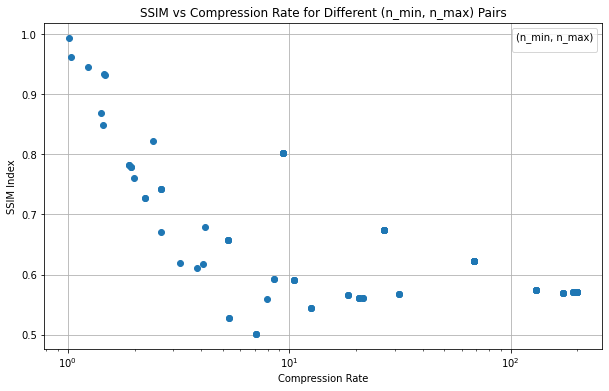

results for image  Splash


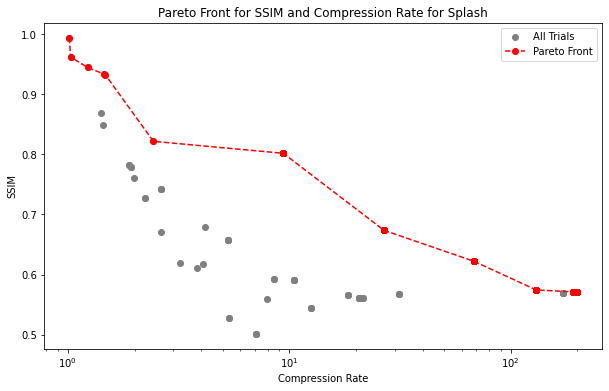

[I 2024-10-31 19:13:48,991] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Sailboat_on_lake_time:2024-10-31_19-13-48


image name:  Sailboat_on_lake
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28477
File saved.


[I 2024-10-31 19:13:50,553] Trial 0 finished with values: [9.250724733166425, 0.3695888496136106] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4814999103546143
SSIM Index : 0.3695888496136106

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33430
File saved.


[I 2024-10-31 19:13:53,107] Trial 1 finished with values: [7.059289332445104, 0.3269420913129896] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 2.4866976737976074
SSIM Index : 0.3269420913129896

image name:  Sailboat_on_lake
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64210
File saved.


[I 2024-10-31 19:13:56,643] Trial 2 finished with values: [4.299823147063552, 0.38796725782258124] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.476986885070801
SSIM Index : 0.38796725782258124

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262662
File saved.


[I 2024-10-31 19:14:03,798] Trial 3 finished with values: [2.555756287798463, 0.5446028806510049] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 7.085663318634033
SSIM Index : 0.5446028806510049

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31352
File saved.


[I 2024-10-31 19:14:11,494] Trial 4 finished with values: [5.54564843888856, 0.3616111504280111] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 7.628333806991577
SSIM Index : 0.3616111504280111

image name:  Sailboat_on_lake
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:14:12,935] Trial 5 finished with values: [20.81961743772242, 0.32530993947403736] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3769950866699219
SSIM Index : 0.32530993947403736

image name:  Sailboat_on_lake
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136342
File saved.


[I 2024-10-31 19:14:16,927] Trial 6 finished with values: [2.9807028903206634, 0.45198148837834523] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.9232256412506104
SSIM Index : 0.45198148837834523

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
File saved.


[I 2024-10-31 19:14:18,870] Trial 7 finished with values: [31.2850935828877, 0.32304672591998024] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.8870363235473633
SSIM Index : 0.32304672591998024

image name:  Sailboat_on_lake
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16112
File saved.


[I 2024-10-31 19:14:23,432] Trial 8 finished with values: [9.740374609781478, 0.272669854134324] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.504256010055542
SSIM Index : 0.272669854134324

image name:  Sailboat_on_lake
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:14:24,558] Trial 9 finished with values: [10.17077145961608, 0.35459272476912124] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.0821757316589355
SSIM Index : 0.35459272476912124

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2752
File saved.


[I 2024-10-31 19:14:26,059] Trial 10 finished with values: [38.49945160405813, 0.31610683477359297] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4279272556304932
SSIM Index : 0.31610683477359297

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:14:27,540] Trial 11 finished with values: [37.802382715218414, 0.31332419688230256] and parameters: {'min_sparcity': 0.6540337852300198, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.39082932472229
SSIM Index : 0.31332419688230256

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:14:28,883] Trial 12 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.6059507601264229, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.778039860056361, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.247622013092041
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:14:30,393] Trial 13 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.6107723483172408, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 7.730170088504397, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4319543838500977
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:14:31,621] Trial 14 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.6091914959702487, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1534450054168701
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:14:33,147] Trial 15 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.5389879840136532, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.103846215160764, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4466588497161865
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:14:34,366] Trial 16 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.7610231514940821, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 26.93361328466897, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1462793350219727
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
File saved.


[I 2024-10-31 19:14:50,327] Trial 17 finished with values: [1.5153755453684492, 0.7885587691016789] and parameters: {'min_sparcity': 0.35147818541471576, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.3833379153519325, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 15.87832760810852
SSIM Index : 0.7885587691016789

image name:  Sailboat_on_lake
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268102
File saved.


[I 2024-10-31 19:14:54,851] Trial 18 finished with values: [2.858866287948201, 0.5913710398620178] and parameters: {'min_sparcity': 0.5134493239719418, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 56.05550543577921, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.459136486053467
SSIM Index : 0.5913710398620178

image name:  Sailboat_on_lake
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 10300
File saved.


[I 2024-10-31 19:14:56,236] Trial 19 finished with values: [16.909435780092732, 0.3364946904431362] and parameters: {'min_sparcity': 0.7674661163887234, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.04883060684997246, 'exponent_a_cols': 4}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3105320930480957
SSIM Index : 0.3364946904431362

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:14:57,490] Trial 20 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.020966336660231344, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 976.7353569963619, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1655399799346924
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:14:59,199] Trial 21 finished with values: [5.371982247388759, 0.45536981475440236] and parameters: {'min_sparcity': 0.5382902774754191, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 46.67803801774202, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.6213340759277344
SSIM Index : 0.45536981475440236

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:15:00,856] Trial 22 finished with values: [5.371982247388759, 0.45536981475440236] and parameters: {'min_sparcity': 0.581164548263079, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 2.3369629496601627, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.5927197933197021
SSIM Index : 0.45536981475440236

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:15:01,544] Trial 23 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.7170249013757537, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 5.178935004398355, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.6294252872467041
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:15:03,177] Trial 24 finished with values: [5.371982247388759, 0.45536981475440236] and parameters: {'min_sparcity': 0.47059074841275195, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 36.228054413435835, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.5694975852966309
SSIM Index : 0.45536981475440236

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:15:03,859] Trial 25 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.8551593850334526, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 80.16104439984622, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.6233880519866943
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 486687
File saved.


[I 2024-10-31 19:15:09,706] Trial 26 finished with values: [2.0458320583992657, 0.6589606105417539] and parameters: {'min_sparcity': 0.34385422614290584, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 5.841553738427463, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 5.7769386768341064
SSIM Index : 0.6589606105417539

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:15:10,769] Trial 27 finished with values: [10.17077145961608, 0.35459272476912124] and parameters: {'min_sparcity': 0.6283274439013679, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.6535931970348924, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.9945716857910156
SSIM Index : 0.35459272476912124

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:15:11,948] Trial 28 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.5446364174683808, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.18973586636837944, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1052007675170898
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:15:13,343] Trial 29 finished with values: [20.81961743772242, 0.32530993947403736] and parameters: {'min_sparcity': 0.7278011959375315, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.06386535651489743, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.2981276512145996
SSIM Index : 0.32530993947403736

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:15:14,615] Trial 30 finished with values: [268.46558317399615, 0.3406465333593595] and parameters: {'min_sparcity': 0.4720395092035108, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.013818056174264572, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.182924747467041
SSIM Index : 0.3406465333593595

image name:  Sailboat_on_lake
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 268132
File saved.


[I 2024-10-31 19:15:19,097] Trial 31 finished with values: [2.858691668702663, 0.5913698460865534] and parameters: {'min_sparcity': 0.5341765710578444, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 55.60529761750845, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.392395257949829
SSIM Index : 0.5913698460865534

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:15:19,770] Trial 32 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.8080813727595035, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 5.099484773659043, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.6110782623291016
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:15:20,463] Trial 33 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.6894842490594798, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 93.36817451131252, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.6257593631744385
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 507672
File saved.


[I 2024-10-31 19:15:33,941] Trial 34 finished with values: [2.1254782638313334, 0.6440651188966316] and parameters: {'min_sparcity': 0.5786293116869515, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.3470297852990578, 'exponent_a_cols': 8}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 13.39614987373352
SSIM Index : 0.6440651188966316

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4567
File saved.


[I 2024-10-31 19:15:35,926] Trial 35 finished with values: [31.2850935828877, 0.32304672591998024] and parameters: {'min_sparcity': 0.4250399505997765, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.566663005527588, 'exponent_a_cols': 5}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.9070923328399658
SSIM Index : 0.32304672591998024

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:15:37,689] Trial 36 finished with values: [5.371982247388759, 0.45536981475440236] and parameters: {'min_sparcity': 0.37851316917387223, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.010270387492138884, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.6801729202270508
SSIM Index : 0.45536981475440236

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:15:41,242] Trial 37 finished with values: [30.909741331865714, 0.48878394738624514] and parameters: {'min_sparcity': 0.9069744860819764, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 17.258527818174876, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.4871418476104736
SSIM Index : 0.48878394738624514

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 485337
File saved.


[I 2024-10-31 19:15:47,246] Trial 38 finished with values: [2.045757538228416, 0.6589592185520631] and parameters: {'min_sparcity': 0.24243405542500468, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 21.557442662946684, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 5.929044246673584
SSIM Index : 0.6589592185520631

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3785980
File saved.


[I 2024-10-31 19:16:19,529] Trial 39 finished with values: [0.9980257347518663, 0.998623044723592] and parameters: {'min_sparcity': 0.9226011347985414, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0011012295765954838, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 32.215991258621216
SSIM Index : 0.998623044723592

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:16:22,943] Trial 40 finished with values: [30.909741331865714, 0.48878394738624514] and parameters: {'min_sparcity': 0.9264905357615403, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 117.02432277997224, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.3561999797821045
SSIM Index : 0.48878394738624514

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:16:34,941] Trial 41 finished with values: [10.110533042899062, 0.6799942549184277] and parameters: {'min_sparcity': 0.1894892476936021, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.4070812080723543, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 11.934468030929565
SSIM Index : 0.6799942549184277

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:16:46,893] Trial 42 finished with values: [10.110533042899062, 0.6799942549184277] and parameters: {'min_sparcity': 0.17032204702145604, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.7432392651123547, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 11.889112949371338
SSIM Index : 0.6799942549184277

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16112
File saved.


[I 2024-10-31 19:16:52,680] Trial 43 finished with values: [9.740374609781478, 0.272669854134324] and parameters: {'min_sparcity': 0.34018406210319985, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.6228121258533357, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 5.7030439376831055
SSIM Index : 0.272669854134324

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:17:05,243] Trial 44 finished with values: [10.110533042899062, 0.6799942549184277] and parameters: {'min_sparcity': 0.0894620479356768, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 9.733116169083676, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 12.48335313796997
SSIM Index : 0.6799942549184277

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:17:06,463] Trial 45 finished with values: [268.46558317399615, 0.3406465333593595] and parameters: {'min_sparcity': 0.1763784757610779, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.1807578209424872, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1546039581298828
SSIM Index : 0.3406465333593595

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:17:08,027] Trial 46 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.6335074204109937, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3646117627248668, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4758741855621338
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3346100
File saved.


[I 2024-10-31 19:17:36,869] Trial 47 finished with values: [0.9997970605827565, 0.9970165011468936] and parameters: {'min_sparcity': 0.30554751093085986, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.792651221902787, 'exponent_a_cols': 5}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 28.69541645050049
SSIM Index : 0.9970165011468936

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31352
File saved.


[I 2024-10-31 19:17:44,885] Trial 48 finished with values: [5.54564843888856, 0.3616111504280111] and parameters: {'min_sparcity': 0.7955436030537799, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 12.97260299770758, 'exponent_a_cols': 8}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 7.940957069396973
SSIM Index : 0.3616111504280111

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64210
File saved.


[I 2024-10-31 19:17:48,156] Trial 49 finished with values: [4.299823147063552, 0.38796725782258124] and parameters: {'min_sparcity': 0.901677410970983, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0033546915644407536, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.179065227508545
SSIM Index : 0.38796725782258124

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28477
File saved.


[I 2024-10-31 19:17:49,211] Trial 50 finished with values: [9.250724733166425, 0.3695888496136106] and parameters: {'min_sparcity': 0.6765133214732544, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 193.32337393202226, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.9733090400695801
SSIM Index : 0.3695888496136106

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:18:01,504] Trial 51 finished with values: [10.110533042899062, 0.6799942549184277] and parameters: {'min_sparcity': 0.3084723946575894, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.7268283518689542, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 12.23085069656372
SSIM Index : 0.6799942549184277

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:18:02,657] Trial 52 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.5804033271394095, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 2.8848158083389848, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.08624267578125
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:18:07,113] Trial 53 finished with values: [2.8588371832591855, 0.5913705007701209] and parameters: {'min_sparcity': 0.053210181027014414, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 3.465481692725814, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.368274450302124
SSIM Index : 0.5913705007701209

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2752
File saved.


[I 2024-10-31 19:18:08,615] Trial 54 finished with values: [38.49945160405813, 0.31610683477359297] and parameters: {'min_sparcity': 0.17669395860392206, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 20.858015838895476, 'exponent_a_cols': 4}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.429459810256958
SSIM Index : 0.31610683477359297

image name:  Sailboat_on_lake
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136342
File saved.


[I 2024-10-31 19:18:12,253] Trial 55 finished with values: [2.9807028903206634, 0.45198148837834523] and parameters: {'min_sparcity': 0.4230315615860009, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 10.140987260579788, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.5389554500579834
SSIM Index : 0.45198148837834523

image name:  Sailboat_on_lake
16 4
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:18:13,693] Trial 56 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.5003127697079297, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 585.7611745539625, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3659489154815674
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 4567
File saved.


[I 2024-10-31 19:18:15,642] Trial 57 finished with values: [31.2850935828877, 0.32304672591998024] and parameters: {'min_sparcity': 0.7303807041645329, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 25.80798714285323, 'exponent_a_cols': 5}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.8696520328521729
SSIM Index : 0.32304672591998024

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:18:16,938] Trial 58 finished with values: [268.46558317399615, 0.3406465333593595] and parameters: {'min_sparcity': 0.2796618533674746, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.1064183968597859, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.211167335510254
SSIM Index : 0.3406465333593595

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:18:18,384] Trial 59 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.5989126379814752, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 8.242754586906283, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3650965690612793
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:18:19,758] Trial 60 finished with values: [20.688473864515416, 0.32985513273693695] and parameters: {'min_sparcity': 0.6534640198433758, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.8475973283599391, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3010566234588623
SSIM Index : 0.32985513273693695

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:18:31,924] Trial 61 finished with values: [10.110533042899062, 0.6799942549184277] and parameters: {'min_sparcity': 0.9001449818085061, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.897156587539104, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 12.083972454071045
SSIM Index : 0.6799942549184277

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:18:32,803] Trial 62 finished with values: [173.98698884758363, 0.3386572971900474] and parameters: {'min_sparcity': 0.21168231480087502, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0020303146014014287, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.8157055377960205
SSIM Index : 0.3386572971900474

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1075460
File saved.


[I 2024-10-31 19:18:48,239] Trial 63 finished with values: [1.5070558970877486, 0.7885396351456373] and parameters: {'min_sparcity': 0.989687874856642, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 14.37211342006108, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 15.364490509033203
SSIM Index : 0.7885396351456373

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33430
File saved.


[I 2024-10-31 19:18:50,497] Trial 64 finished with values: [7.059289332445104, 0.3269420913129896] and parameters: {'min_sparcity': 0.4977118349413745, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 39.122579840859025, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 2.1811742782592773
SSIM Index : 0.3269420913129896

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:18:51,697] Trial 65 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.7732254600319373, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 4.814350780039557, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1196911334991455
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:18:52,416] Trial 66 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.706972607623427, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.001084202849187578, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.6380717754364014
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1067740
File saved.


[I 2024-10-31 19:19:09,769] Trial 67 finished with values: [1.4804749076070625, 0.8002470378361374] and parameters: {'min_sparcity': 0.6212266575857593, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.38677802520240573, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 17.263641834259033
SSIM Index : 0.8002470378361374

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:19:10,790] Trial 68 finished with values: [10.17077145961608, 0.35459272476912124] and parameters: {'min_sparcity': 0.6176276238952866, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.847758110854098, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.948836088180542
SSIM Index : 0.35459272476912124

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:19:12,237] Trial 69 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.570705845500821, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 7.748913489127524, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3810832500457764
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28477
File saved.


[I 2024-10-31 19:19:13,270] Trial 70 finished with values: [9.250724733166425, 0.3695888496136106] and parameters: {'min_sparcity': 0.5468935441625922, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.42569379863009554, 'exponent_a_cols': 3}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.9673054218292236
SSIM Index : 0.3695888496136106

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:19:14,491] Trial 71 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.6500975701901648, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.53167166731803, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1454603672027588
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:19:18,136] Trial 72 finished with values: [30.909741331865714, 0.48878394738624514] and parameters: {'min_sparcity': 0.45958936205741296, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 32.15808277109268, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.555981159210205
SSIM Index : 0.48878394738624514

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:19:19,788] Trial 73 finished with values: [5.371982247388759, 0.45536981475440236] and parameters: {'min_sparcity': 0.8398806827869523, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 71.62767141503873, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.5870440006256104
SSIM Index : 0.45536981475440236

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:19:21,015] Trial 74 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.6830380789258969, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 20.078050335675975, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1549530029296875
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 10300
File saved.


[I 2024-10-31 19:19:22,495] Trial 75 finished with values: [16.909435780092732, 0.3364946904431362] and parameters: {'min_sparcity': 0.6084580411840556, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 6.607540322704588, 'exponent_a_cols': 4}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3811767101287842
SSIM Index : 0.3364946904431362

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16112
File saved.


[I 2024-10-31 19:19:26,467] Trial 76 finished with values: [9.740374609781478, 0.272669854134324] and parameters: {'min_sparcity': 0.7438620215662003, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.024340776573456027, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.8776137828826904
SSIM Index : 0.272669854134324

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:19:31,109] Trial 77 finished with values: [2.8588371832591855, 0.5913705007701209] and parameters: {'min_sparcity': 0.951496595719572, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 3.810647274096518, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.5398077964782715
SSIM Index : 0.5913705007701209

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:19:32,329] Trial 78 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.5126411619946812, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.117836165448168, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1429638862609863
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:19:33,232] Trial 79 finished with values: [173.98698884758363, 0.3386572971900474] and parameters: {'min_sparcity': 0.5556753523153725, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 4.921778941057127, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.8170552253723145
SSIM Index : 0.3386572971900474

image name:  Sailboat_on_lake
16 8
processed_blocks: 12144
bytes_written (without DEFLATE): 1519599
File saved.


[I 2024-10-31 19:21:05,361] Trial 80 finished with values: [1.053823565283472, 0.9849457769934822] and parameters: {'min_sparcity': 0.12393496700766754, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 154.58992593858704, 'exponent_a_cols': 8}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 92.03648638725281
SSIM Index : 0.9849457769934822

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:21:06,233] Trial 81 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.701814961597396, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.35808917860099, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.7892296314239502
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:21:07,921] Trial 82 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.6361440127271547, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.20756730147388672, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.610191822052002
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2596545
File saved.


[I 2024-10-31 19:21:35,598] Trial 83 finished with values: [1.000129995708361, 0.9967242269687899] and parameters: {'min_sparcity': 0.14714332637888916, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 8.336375540812078, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 27.596774339675903
SSIM Index : 0.9967242269687899

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:21:36,830] Trial 84 finished with values: [268.46558317399615, 0.3406465333593595] and parameters: {'min_sparcity': 0.11307640103841199, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.007582118146699696, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1605730056762695
SSIM Index : 0.3406465333593595

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 136342
File saved.


[I 2024-10-31 19:21:40,917] Trial 85 finished with values: [2.9807028903206634, 0.45198148837834523] and parameters: {'min_sparcity': 0.37745705966022136, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 145.39717648636267, 'exponent_a_cols': 6}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.9776077270507812
SSIM Index : 0.45198148837834523

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:21:42,292] Trial 86 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.1446272073596746, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 301.48895348927664, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.2824647426605225
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2813125
File saved.


[I 2024-10-31 19:22:18,064] Trial 87 finished with values: [0.9989239374994442, 0.9965300643003493] and parameters: {'min_sparcity': 0.023473028340132318, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 10.143677572924831, 'exponent_a_cols': 8}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 35.662660121917725
SSIM Index : 0.9965300643003493

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:22:18,868] Trial 88 finished with values: [242.29076790336498, 0.3376886584623227] and parameters: {'min_sparcity': 0.6004934846808313, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 51.746857306797416, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.7320601940155029
SSIM Index : 0.3376886584623227

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:22:22,641] Trial 89 finished with values: [30.909741331865714, 0.48878394738624514] and parameters: {'min_sparcity': 0.6682433213662687, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 12.108226850727332, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.7022860050201416
SSIM Index : 0.48878394738624514

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:22:23,960] Trial 90 finished with values: [268.46558317399615, 0.3406465333593595] and parameters: {'min_sparcity': 0.47906676420477856, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 6.950677585739372, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.2347824573516846
SSIM Index : 0.3406465333593595

image name:  Sailboat_on_lake
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3331350
File saved.


[I 2024-10-31 19:22:55,406] Trial 91 finished with values: [0.9999394655879672, 0.9969823112516962] and parameters: {'min_sparcity': 0.22177166994244607, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 2.9456305739000457, 'exponent_a_cols': 5}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 31.345271587371826
SSIM Index : 0.9969823112516962

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:22:56,622] Trial 92 finished with values: [282.0843797086891, 0.34174856447477736] and parameters: {'min_sparcity': 0.5340125418014781, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 4.299328521907648, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.1313271522521973
SSIM Index : 0.34174856447477736

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:22:58,161] Trial 93 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.43295266338437544, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 18.456833946538275, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.4424221515655518
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:22:59,039] Trial 94 finished with values: [173.98698884758363, 0.3386572971900474] and parameters: {'min_sparcity': 0.8084931177106501, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 941.4923488823938, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 0.8001506328582764
SSIM Index : 0.3386572971900474

image name:  Sailboat_on_lake
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64210
File saved.


[I 2024-10-31 19:23:02,680] Trial 95 finished with values: [4.299823147063552, 0.38796725782258124] and parameters: {'min_sparcity': 0.0749731124285623, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 28.534913420006394, 'exponent_a_cols': 7}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 3.5530614852905273
SSIM Index : 0.38796725782258124

image name:  Sailboat_on_lake
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:23:07,366] Trial 96 finished with values: [2.8588371832591855, 0.5913705007701209] and parameters: {'min_sparcity': 0.5643735280297407, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.4082073394595245, 'exponent_a_cols': 2}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 4.596146821975708
SSIM Index : 0.5913705007701209

image name:  Sailboat_on_lake
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:23:08,832] Trial 97 finished with values: [84.53190848886213, 0.3854635687618747] and parameters: {'min_sparcity': 0.6608763953045865, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.0726213736484231, 'exponent_a_cols': 1}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.3937857151031494
SSIM Index : 0.3854635687618747

image name:  Sailboat_on_lake
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 2752
File saved.


[I 2024-10-31 19:23:10,404] Trial 98 finished with values: [38.49945160405813, 0.31610683477359297] and parameters: {'min_sparcity': 0.5873096604011123, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.05112791409026906, 'exponent_a_cols': 4}.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 1.476898193359375
SSIM Index : 0.31610683477359297

image name:  Sailboat_on_lake
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 8327
File saved.


[I 2024-10-31 19:23:13,194] Trial 99 finished with values: [17.180483328234935, 0.3096298545820533] and parameters: {'min_sparcity': 0.2539038717523363, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.564420536981748, 'exponent_a_cols': 6}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Sailboat_on_lake_reconstructed.png
execution_time 2.6856532096862793
SSIM Index : 0.3096298545820533



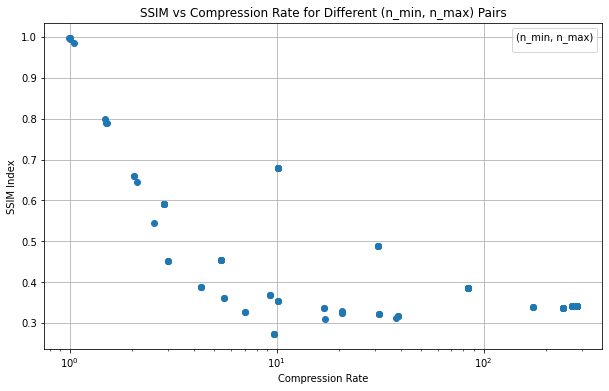

results for image  Sailboat_on_lake


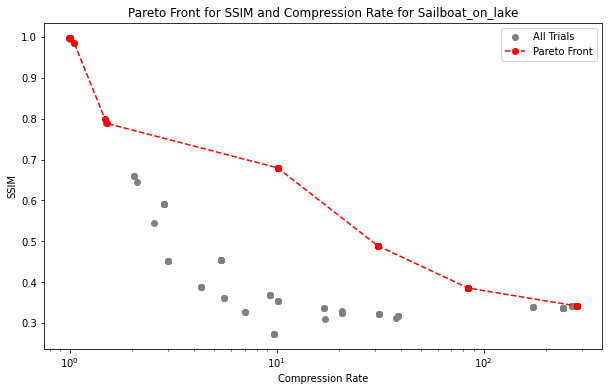

[I 2024-10-31 19:23:13,845] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Stream_and_bridge_time:2024-10-31_19-23-13


image name:  Stream_and_bridge
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 15727
File saved.


[I 2024-10-31 19:23:14,787] Trial 0 finished with values: [4.706735751295337, 0.26182213754928624] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.9071753025054932
SSIM Index : 0.26182213754928624

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 12740
File saved.


[I 2024-10-31 19:23:17,017] Trial 1 finished with values: [4.602425391429412, 0.29123023075963195] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.1849915981292725
SSIM Index : 0.29123023075963195

image name:  Stream_and_bridge
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 23000
File saved.


[I 2024-10-31 19:23:19,974] Trial 2 finished with values: [3.341290934978643, 0.3238889596810967] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.9133806228637695
SSIM Index : 0.3238889596810967

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 93712
File saved.


[I 2024-10-31 19:23:24,229] Trial 3 finished with values: [1.3704157907031067, 0.48006117567300843] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 4.207114934921265
SSIM Index : 0.48006117567300843

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 10852
File saved.


[I 2024-10-31 19:23:31,322] Trial 4 finished with values: [5.970740395216691, 0.2788184031146642] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 7.044145345687866
SSIM Index : 0.2788184031146642

image name:  Stream_and_bridge
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 3605
File saved.


[I 2024-10-31 19:23:32,783] Trial 5 finished with values: [10.097676419965577, 0.2144639314712942] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4136552810668945
SSIM Index : 0.2144639314712942

image name:  Stream_and_bridge
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 51642
File saved.


[I 2024-10-31 19:23:35,784] Trial 6 finished with values: [1.9137987277768715, 0.39334114466137843] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.9362573623657227
SSIM Index : 0.39334114466137843

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1922
File saved.


[I 2024-10-31 19:23:37,815] Trial 7 finished with values: [16.570789690478993, 0.2224472524106053] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.98600435256958
SSIM Index : 0.2224472524106053

image name:  Stream_and_bridge
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 5757
File saved.


[I 2024-10-31 19:23:42,296] Trial 8 finished with values: [7.657692935225975, 0.25460307644069774] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 4.426657199859619
SSIM Index : 0.25460307644069774

image name:  Stream_and_bridge
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.


[I 2024-10-31 19:23:43,306] Trial 9 finished with values: [5.126597487711633, 0.23286084079892594] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.9641461372375488
SSIM Index : 0.23286084079892594

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 10852
File saved.


[I 2024-10-31 19:23:50,516] Trial 10 finished with values: [5.970740395216691, 0.2788184031146642] and parameters: {'min_sparcity': 0.6902050912263995, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 11.939737969428494, 'exponent_a_cols': 8}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 7.150821208953857
SSIM Index : 0.2788184031146642

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1317
File saved.


[I 2024-10-31 19:23:52,172] Trial 11 finished with values: [15.875746983876423, 0.20495264973087698] and parameters: {'min_sparcity': 0.95935497285867, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.454561293916552, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.58009672164917
SSIM Index : 0.20495264973087698

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:23:53,560] Trial 12 finished with values: [71.50939563230067, 0.19047667135282453] and parameters: {'min_sparcity': 0.984796336326853, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 860.8671652610016, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3084850311279297
SSIM Index : 0.19047667135282453

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 677
File saved.


[I 2024-10-31 19:23:54,959] Trial 13 finished with values: [68.08607350096712, 0.19522825559246174] and parameters: {'min_sparcity': 0.9893806884209846, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 993.9447290633647, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.320763111114502
SSIM Index : 0.19522825559246174

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:23:56,441] Trial 14 finished with values: [71.50939563230067, 0.19047667135282453] and parameters: {'min_sparcity': 0.6934211450249229, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 21.09298295545387, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3600380420684814
SSIM Index : 0.19047667135282453

image name:  Stream_and_bridge
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 82975
File saved.


[I 2024-10-31 19:23:58,580] Trial 15 finished with values: [1.284127389464468, 0.42150777423832453] and parameters: {'min_sparcity': 0.8058202042121432, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 81.95912886512717, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.0472629070281982
SSIM Index : 0.42150777423832453

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 677
File saved.


[I 2024-10-31 19:23:59,857] Trial 16 finished with values: [68.08607350096712, 0.19522825559246174] and parameters: {'min_sparcity': 0.5669430934659332, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 925.4995889806504, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.2154505252838135
SSIM Index : 0.19522825559246174

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1601130
File saved.


[I 2024-10-31 19:24:19,720] Trial 17 finished with values: [0.2664564819160371, 0.9987657554891599] and parameters: {'min_sparcity': 0.9757282381074532, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 4.276615345489037, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 19.776600122451782
SSIM Index : 0.9987657554891599

image name:  Stream_and_bridge
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:24:24,126] Trial 18 finished with values: [1.3142238442368184, 0.48106821779620296] and parameters: {'min_sparcity': 0.825511928904983, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.04297631943484504, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 4.346158027648926
SSIM Index : 0.48106821779620296

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 917
File saved.


[I 2024-10-31 19:24:25,476] Trial 19 finished with values: [16.96409638554217, 0.20092188541536068] and parameters: {'min_sparcity': 0.8655077126084408, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.14567941450916636, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.289499282836914
SSIM Index : 0.20092188541536068

image name:  Stream_and_bridge
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:24:26,226] Trial 20 finished with values: [62.246684350132625, 0.1963539955638375] and parameters: {'min_sparcity': 0.7513333531776172, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 1.9720039788958807, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.6812701225280762
SSIM Index : 0.1963539955638375

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1922
File saved.


[I 2024-10-31 19:24:28,033] Trial 21 finished with values: [16.570789690478993, 0.2224472524106053] and parameters: {'min_sparcity': 0.9145335259746225, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 92.89331752540932, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.751155138015747
SSIM Index : 0.2224472524106053

image name:  Stream_and_bridge
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 1317
File saved.


[I 2024-10-31 19:24:29,668] Trial 22 finished with values: [15.875746983876423, 0.20495264973087698] and parameters: {'min_sparcity': 0.9082948719812909, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 257.86892897361247, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.5532307624816895
SSIM Index : 0.20495264973087698

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 677
File saved.


[I 2024-10-31 19:24:31,255] Trial 23 finished with values: [68.08607350096712, 0.19522825559246174] and parameters: {'min_sparcity': 0.5600284680410967, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 57.634181157703765, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.5138344764709473
SSIM Index : 0.19522825559246174

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 917
File saved.


[I 2024-10-31 19:24:32,731] Trial 24 finished with values: [16.96409638554217, 0.20092188541536068] and parameters: {'min_sparcity': 0.012257105091479037, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 364.4183055194338, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3930010795593262
SSIM Index : 0.20092188541536068

image name:  Stream_and_bridge
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 43430
File saved.


[I 2024-10-31 19:24:37,992] Trial 25 finished with values: [2.449284185989876, 0.3833508214996004] and parameters: {'min_sparcity': 0.9872594910338873, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 45.60389196191941, 'exponent_a_cols': 8}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 5.174393177032471
SSIM Index : 0.3833508214996004

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1922
File saved.


[I 2024-10-31 19:24:39,954] Trial 26 finished with values: [16.570789690478993, 0.2224472524106053] and parameters: {'min_sparcity': 0.7802144735757701, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 934.1313076176474, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.8891568183898926
SSIM Index : 0.2224472524106053

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 12740
File saved.


[I 2024-10-31 19:24:42,279] Trial 27 finished with values: [4.602425391429412, 0.29123023075963195] and parameters: {'min_sparcity': 0.901278491294712, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.007666859817704826, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.2407331466674805
SSIM Index : 0.29123023075963195

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:24:43,615] Trial 28 finished with values: [71.50939563230067, 0.19047667135282453] and parameters: {'min_sparcity': 0.7446429393552529, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 3.7396181629871963, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.2517094612121582
SSIM Index : 0.19047667135282453

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 3605
File saved.


[I 2024-10-31 19:24:45,094] Trial 29 finished with values: [10.097676419965577, 0.2144639314712942] and parameters: {'min_sparcity': 0.9984412619064298, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 377.8897019714447, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3932163715362549
SSIM Index : 0.2144639314712942

image name:  Stream_and_bridge
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 4975
File saved.


[I 2024-10-31 19:24:46,659] Trial 30 finished with values: [8.680764488286066, 0.23939537502591263] and parameters: {'min_sparcity': 0.621772574401027, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 139.24287285788662, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4735746383666992
SSIM Index : 0.23939537502591263

image name:  Stream_and_bridge
64 8
processed_blocks: 192
bytes_written (without DEFLATE): 43430
File saved.


[I 2024-10-31 19:24:51,919] Trial 31 finished with values: [2.449284185989876, 0.3833508214996004] and parameters: {'min_sparcity': 0.9109403008568117, 'exponent_min_n': 3, 'exponent_max_n': 6, 'max_error': 41.19623394923589, 'exponent_a_cols': 8}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 5.162275552749634
SSIM Index : 0.3833508214996004

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 677
File saved.


[I 2024-10-31 19:24:53,254] Trial 32 finished with values: [68.08607350096712, 0.19522825559246174] and parameters: {'min_sparcity': 0.839919693056236, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 577.4861710029247, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.2602381706237793
SSIM Index : 0.19522825559246174

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 3167
File saved.


[I 2024-10-31 19:24:56,122] Trial 33 finished with values: [10.966741958096424, 0.24308598603243498] and parameters: {'min_sparcity': 0.3061594070366462, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.021136366250006828, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.7787654399871826
SSIM Index : 0.24308598603243498

image name:  Stream_and_bridge
128 32
processed_blocks: 48
bytes_written (without DEFLATE): 3167
File saved.


[I 2024-10-31 19:24:59,212] Trial 34 finished with values: [10.966741958096424, 0.24308598603243498] and parameters: {'min_sparcity': 0.3172506179715338, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.016511323718192573, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.0034847259521484
SSIM Index : 0.24308598603243498

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1922
File saved.


[I 2024-10-31 19:25:01,267] Trial 35 finished with values: [16.570789690478993, 0.2224472524106053] and parameters: {'min_sparcity': 0.39316374000045384, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 31.94938380410129, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.9682080745697021
SSIM Index : 0.2224472524106053

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 5757
File saved.


[I 2024-10-31 19:25:06,488] Trial 36 finished with values: [7.657692935225975, 0.25460307644069774] and parameters: {'min_sparcity': 0.19351382590136895, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.0011506453269117312, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 5.133633852005005
SSIM Index : 0.25460307644069774

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 51642
File saved.


[I 2024-10-31 19:25:09,627] Trial 37 finished with values: [1.9137987277768715, 0.39334114466137843] and parameters: {'min_sparcity': 0.35907538325089156, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 142.32997890965544, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.038450002670288
SSIM Index : 0.39334114466137843

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 23000
File saved.


[I 2024-10-31 19:25:13,544] Trial 38 finished with values: [3.341290934978643, 0.3238889596810967] and parameters: {'min_sparcity': 0.4919262791240766, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0035026972655428576, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.821711301803589
SSIM Index : 0.3238889596810967

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1734655
File saved.


[I 2024-10-31 19:25:34,702] Trial 39 finished with values: [0.4569372012344918, 0.903224566906574] and parameters: {'min_sparcity': 0.06952872120661335, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.06417341059848447, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 21.0700044631958
SSIM Index : 0.903224566906574

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 82975
File saved.


[I 2024-10-31 19:25:36,631] Trial 40 finished with values: [1.284127389464468, 0.42150777423832453] and parameters: {'min_sparcity': 0.18256487279779168, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 466.5928102876166, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.8697118759155273
SSIM Index : 0.42150777423832453

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 10852
File saved.


[I 2024-10-31 19:25:43,617] Trial 41 finished with values: [5.970740395216691, 0.2788184031146642] and parameters: {'min_sparcity': 0.9409804565902169, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 174.43780846728487, 'exponent_a_cols': 8}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 6.924273490905762
SSIM Index : 0.2788184031146642

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 677
File saved.


[I 2024-10-31 19:25:44,967] Trial 42 finished with values: [68.08607350096712, 0.19522825559246174] and parameters: {'min_sparcity': 0.8676675910454656, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.5320452500000993, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.260542392730713
SSIM Index : 0.19522825559246174

image name:  Stream_and_bridge
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1922
File saved.


[I 2024-10-31 19:25:46,942] Trial 43 finished with values: [16.570789690478993, 0.2224472524106053] and parameters: {'min_sparcity': 0.9965941212467435, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 623.894753679939, 'exponent_a_cols': 5}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.8934314250946045
SSIM Index : 0.2224472524106053

image name:  Stream_and_bridge
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 917
File saved.


[I 2024-10-31 19:25:48,409] Trial 44 finished with values: [16.96409638554217, 0.20092188541536068] and parameters: {'min_sparcity': 0.9427874431598264, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.1654287762099682, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3802416324615479
SSIM Index : 0.20092188541536068

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 12740
File saved.


[I 2024-10-31 19:25:50,681] Trial 45 finished with values: [4.602425391429412, 0.29123023075963195] and parameters: {'min_sparcity': 0.8680099708681835, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 278.6013994608625, 'exponent_a_cols': 6}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 2.1804277896881104
SSIM Index : 0.29123023075963195

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:25:54,543] Trial 46 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.28028328230491495, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.01343411628890555, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.7830002307891846
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:26:07,138] Trial 47 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.011775966650598824, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.06610164048984318, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.532872915267944
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:26:19,696] Trial 48 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.03486326698385621, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.06584669367713661, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.500854015350342
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:26:23,430] Trial 49 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.08403259797776091, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.009354897092405572, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.6763858795166016
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:26:27,952] Trial 50 finished with values: [1.3142238442368184, 0.48106821779620296] and parameters: {'min_sparcity': 0.1041208486993647, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.07634971964964794, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 4.46037220954895
SSIM Index : 0.48106821779620296

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:26:40,475] Trial 51 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.07322444968040714, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.006323512821330499, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.461229801177979
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:26:41,854] Trial 52 finished with values: [24.793449550977286, 0.22971006112356468] and parameters: {'min_sparcity': 0.14708445160675837, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.002242633380883359, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3219873905181885
SSIM Index : 0.22971006112356468

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:26:45,393] Trial 53 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.1604244551477569, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0021189428466201537, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.4839282035827637
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:26:46,774] Trial 54 finished with values: [24.793449550977286, 0.22971006112356468] and parameters: {'min_sparcity': 0.23458113229464808, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.004061921818691779, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3223600387573242
SSIM Index : 0.22971006112356468

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:26:58,744] Trial 55 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.05527561735349334, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.012647579027938853, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 11.912004947662354
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:27:00,254] Trial 56 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.13843731410452875, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0340703787432578, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4534239768981934
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:27:03,708] Trial 57 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.24367677997725568, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.3826206536632824, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.399139881134033
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:27:05,192] Trial 58 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.013325689786926054, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 1.18247755982168, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4203484058380127
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:27:17,304] Trial 59 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.12466165362440179, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0020188849363901888, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.05361557006836
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.


[I 2024-10-31 19:27:18,178] Trial 60 finished with values: [5.126597487711633, 0.23286084079892594] and parameters: {'min_sparcity': 0.20142887540998033, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.08804142386582789, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.817152738571167
SSIM Index : 0.23286084079892594

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:27:21,768] Trial 61 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.06710955817809809, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.0543691060643505, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.535132884979248
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:27:22,589] Trial 62 finished with values: [44.86998087954111, 0.20477166033199184] and parameters: {'min_sparcity': 0.449711064726877, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.004806804203435349, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.7642333507537842
SSIM Index : 0.20477166033199184

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:27:23,508] Trial 63 finished with values: [44.86998087954111, 0.20477166033199184] and parameters: {'min_sparcity': 0.4173323145380404, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.0042904259859465384, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.8640050888061523
SSIM Index : 0.20477166033199184

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:27:35,383] Trial 64 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.48582477356873843, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.04533771143509161, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 11.81734824180603
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:27:36,862] Trial 65 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.274471267989548, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.24220302787139922, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4159367084503174
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:27:40,339] Trial 66 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.1449471237967367, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.02182273699175996, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.414335012435913
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:27:41,805] Trial 67 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.04141401465700366, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.011513043564534345, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4073808193206787
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:27:45,454] Trial 68 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.10671575310210507, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.005467338555660197, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.5915231704711914
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.


[I 2024-10-31 19:27:46,324] Trial 69 finished with values: [5.126597487711633, 0.23286084079892594] and parameters: {'min_sparcity': 0.5690018901481109, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.700525078958493, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.8122134208679199
SSIM Index : 0.23286084079892594

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:27:48,014] Trial 70 finished with values: [2.1053560214121236, 0.3661894763028167] and parameters: {'min_sparcity': 0.32918109581879035, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.002804287772663284, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.6244149208068848
SSIM Index : 0.3661894763028167

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:27:48,835] Trial 71 finished with values: [44.86998087954111, 0.20477166033199184] and parameters: {'min_sparcity': 0.27914971682876133, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.001332586433347853, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.7600023746490479
SSIM Index : 0.20477166033199184

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:28:00,736] Trial 72 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.01254935682405995, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.0455122658677496, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 11.83521842956543
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:28:13,058] Trial 73 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.09232173341334018, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.028376372205045488, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.26181173324585
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 11797
File saved.


[I 2024-10-31 19:28:13,938] Trial 74 finished with values: [5.126597487711633, 0.23286084079892594] and parameters: {'min_sparcity': 0.6570482958179191, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.01551135698596335, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.816652774810791
SSIM Index : 0.23286084079892594

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:28:17,468] Trial 75 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.44423805226802004, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.04652384795221137, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.4727299213409424
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:28:18,828] Trial 76 finished with values: [24.793449550977286, 0.22971006112356468] and parameters: {'min_sparcity': 0.3527262668064619, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.006723192467898315, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.3025405406951904
SSIM Index : 0.22971006112356468

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:28:30,876] Trial 77 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.5316525854071817, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.11386886809121186, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 11.991189241409302
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:28:32,450] Trial 78 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.16861463934436113, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.009311219477288076, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.5161082744598389
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:28:36,010] Trial 79 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.0406514044619159, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.0015710985506615775, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.4990758895874023
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 47125
File saved.


[I 2024-10-31 19:28:37,559] Trial 80 finished with values: [2.282560062250754, 0.3159832550034602] and parameters: {'min_sparcity': 0.12371012794541625, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.5938636390732723, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.4861464500427246
SSIM Index : 0.3159832550034602

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:28:50,535] Trial 81 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.3809208170823268, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.8464563694434464, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.906590938568115
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:28:51,568] Trial 82 finished with values: [44.86998087954111, 0.20477166033199184] and parameters: {'min_sparcity': 0.055922169044686075, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.34519899167096646, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.9512341022491455
SSIM Index : 0.20477166033199184

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3268455
File saved.


[I 2024-10-31 19:29:24,512] Trial 83 finished with values: [0.3599187126953899, 0.9996550882642751] and parameters: {'min_sparcity': 0.7361618681149703, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0010208164417698769, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 32.87214946746826
SSIM Index : 0.9996550882642751

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:29:36,926] Trial 84 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.7671299718645621, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.6868240555597205, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.354727268218994
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2900675
File saved.


[I 2024-10-31 19:30:07,641] Trial 85 finished with values: [0.3436005310114597, 0.9996520493904142] and parameters: {'min_sparcity': 0.20449119161404578, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.019176048410547746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 30.65056586265564
SSIM Index : 0.9996520493904142

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:30:19,763] Trial 86 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.08669975532015825, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0010024668612864445, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.064502000808716
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1080630
File saved.


[I 2024-10-31 19:30:35,262] Trial 87 finished with values: [0.6861060623041726, 0.7295133423435821] and parameters: {'min_sparcity': 0.721594561403704, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.00266717431926599, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 15.435148239135742
SSIM Index : 0.7295133423435821

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 188437
File saved.


[I 2024-10-31 19:30:39,373] Trial 88 finished with values: [0.9131246838480396, 0.4810864964767081] and parameters: {'min_sparcity': 0.6052680301911143, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 19.38061614479267, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 4.044524431228638
SSIM Index : 0.4810864964767081

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1734730
File saved.


[I 2024-10-31 19:30:59,664] Trial 89 finished with values: [0.45672969317153395, 0.9032253844951655] and parameters: {'min_sparcity': 0.028345834336019282, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.002573105746671288, 'exponent_a_cols': 3}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 20.220661640167236
SSIM Index : 0.9032253844951655

image name:  Stream_and_bridge
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:31:03,142] Trial 90 finished with values: [11.045893151329725, 0.33287912769380446] and parameters: {'min_sparcity': 0.26545355781606733, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.1734439425870038, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 3.413588285446167
SSIM Index : 0.33287912769380446

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:31:15,424] Trial 91 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.2215775249900294, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.005256267354551429, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.220081090927124
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:31:27,655] Trial 92 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.4515629169862659, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.00351654834335835, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.168983459472656
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:31:28,440] Trial 93 finished with values: [62.246684350132625, 0.1963539955638375] and parameters: {'min_sparcity': 0.7396439310634368, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.001715814441874827, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 0.7217683792114258
SSIM Index : 0.1963539955638375

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:31:40,639] Trial 94 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.06347261562632484, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.05692362279484193, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 12.136216640472412
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2965
File saved.


[I 2024-10-31 19:31:41,899] Trial 95 finished with values: [11.571499013806706, 0.20674539745812084] and parameters: {'min_sparcity': 0.3034243008767024, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.008941853961646793, 'exponent_a_cols': 2}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.1845223903656006
SSIM Index : 0.20674539745812084

image name:  Stream_and_bridge
8 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589600
File saved.


[I 2024-10-31 19:31:57,858] Trial 96 finished with values: [4.50364636642784, 0.5550144942935803] and parameters: {'min_sparcity': 0.011815302543800648, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.11052353018808399, 'exponent_a_cols': 1}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 15.8750159740448
SSIM Index : 0.5550144942935803

image name:  Stream_and_bridge
16 8
processed_blocks: 6144
bytes_written (without DEFLATE): 1196614
File saved.


[I 2024-10-31 19:32:23,230] Trial 97 finished with values: [0.46514593416032113, 0.9998211514465849] and parameters: {'min_sparcity': 0.163297559109972, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.028544927458354158, 'exponent_a_cols': 7}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 25.292660236358643
SSIM Index : 0.9998211514465849

image name:  Stream_and_bridge
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 82975
File saved.


[I 2024-10-31 19:32:25,298] Trial 98 finished with values: [1.284127389464468, 0.42150777423832453] and parameters: {'min_sparcity': 0.24512502085195195, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.030074975577913932, 'exponent_a_cols': 4}.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 1.9784448146820068
SSIM Index : 0.42150777423832453

image name:  Stream_and_bridge
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1080630
File saved.


[I 2024-10-31 19:32:41,673] Trial 99 finished with values: [0.6861060623041726, 0.7295133423435821] and parameters: {'min_sparcity': 0.1473294175113815, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.02244281367946916, 'exponent_a_cols': 2}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Stream_and_bridge_reconstructed.png
execution_time 16.300121307373047
SSIM Index : 0.7295133423435821



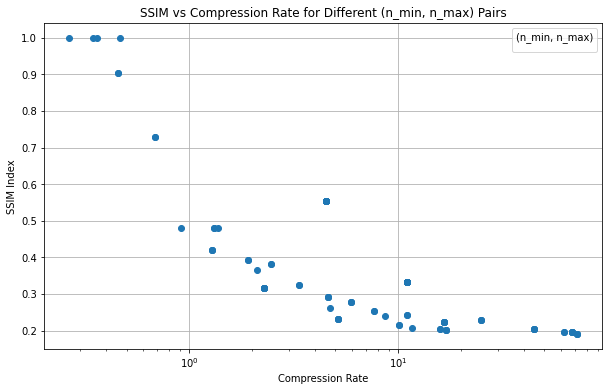

results for image  Stream_and_bridge


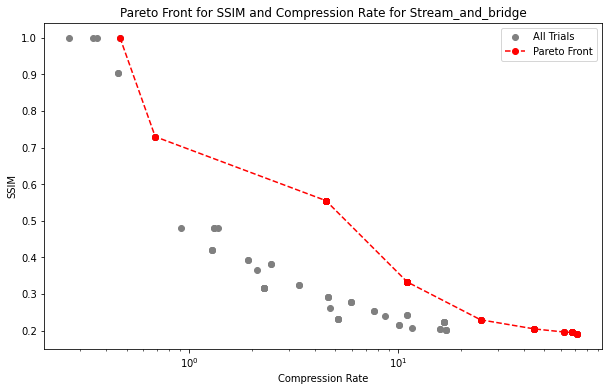

[I 2024-10-31 19:32:42,181] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Female_(NTSC_test_image)_time:2024-10-31_19-32-42


image name:  Female_(NTSC_test_image)
32 32
processed_blocks: 192
bytes_written (without DEFLATE): 6945
File saved.


[I 2024-10-31 19:32:42,448] Trial 0 finished with values: [9.412863394810879, 0.5112428619948286] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2553408145904541
SSIM Index : 0.5112428619948286

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 8427
File saved.


[I 2024-10-31 19:32:43,239] Trial 1 finished with values: [6.913897020836921, 0.46317623633379035] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.7725954055786133
SSIM Index : 0.46317623633379035

image name:  Female_(NTSC_test_image)
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:32:44,464] Trial 2 finished with values: [4.231704317886379, 0.49992415578622473] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.2093565464019775
SSIM Index : 0.49992415578622473

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 65735
File saved.


[I 2024-10-31 19:32:46,172] Trial 3 finished with values: [2.3259950176698916, 0.6520824768937857] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.690218210220337
SSIM Index : 0.6520824768937857

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 7850
File saved.


[I 2024-10-31 19:32:50,863] Trial 4 finished with values: [4.6402511846515395, 0.4545188661174765] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.674522399902344
SSIM Index : 0.4545188661174765

image name:  Female_(NTSC_test_image)
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:32:51,298] Trial 5 finished with values: [19.964694181999004, 0.4603301942717207] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4194643497467041
SSIM Index : 0.4603301942717207

image name:  Female_(NTSC_test_image)
32 4
processed_blocks: 192
bytes_written (without DEFLATE): 34105
File saved.


[I 2024-10-31 19:32:52,452] Trial 6 finished with values: [2.7711261934890143, 0.5803813141108277] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1368408203125
SSIM Index : 0.5803813141108277

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 1170
File saved.


[I 2024-10-31 19:32:53,354] Trial 7 finished with values: [28.967532467532468, 0.42588566527801275] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.8868265151977539
SSIM Index : 0.42588566527801275

image name:  Female_(NTSC_test_image)
128 8
processed_blocks: 12
bytes_written (without DEFLATE): 4035
File saved.


[I 2024-10-31 19:32:56,533] Trial 8 finished with values: [9.047322166303614, 0.40458954311112716] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.161480188369751
SSIM Index : 0.40458954311112716

image name:  Female_(NTSC_test_image)
32 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:32:56,858] Trial 9 finished with values: [9.819582586010108, 0.499215615524835] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3123817443847656
SSIM Index : 0.499215615524835

image name:  Female_(NTSC_test_image)
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:32:57,075] Trial 10 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.5460650465732574, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 9.710150883703287, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.18465042114257812
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:32:57,439] Trial 11 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.6104842273327785, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 13.800909892716907, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3254201412200928
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:32:57,869] Trial 12 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.624364215316456, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 9.311254897192036, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3786134719848633
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:32:58,372] Trial 13 finished with values: [60.55656108597285, 0.5100049182860134] and parameters: {'min_sparcity': 0.6173938735010195, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 11.143432919527932, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4557945728302002
SSIM Index : 0.5100049182860134

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:32:58,911] Trial 14 finished with values: [4.166418762323152, 0.603275165080454] and parameters: {'min_sparcity': 0.7238900231988967, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 13.738042402588633, 'exponent_a_cols': 3}.


processed_blocks: 768
bytes_written (without DEFLATE): 24597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.5065186023712158
SSIM Index : 0.603275165080454

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 264442
File saved.


[I 2024-10-31 19:33:03,000] Trial 15 finished with values: [1.4556232325429628, 0.8690057012852244] and parameters: {'min_sparcity': 0.3511642414757917, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 24.70619895397335, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.056511878967285
SSIM Index : 0.8690057012852244

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:33:03,328] Trial 16 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.5342211693087733, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 1.591080911563507, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2981855869293213
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:33:04,076] Trial 17 finished with values: [2.587531418505231, 0.6037211336999312] and parameters: {'min_sparcity': 0.7718060491923172, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 47.09435713844267, 'exponent_a_cols': 4}.


processed_blocks: 768
bytes_written (without DEFLATE): 43817
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.6998894214630127
SSIM Index : 0.6037211336999312

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:33:04,530] Trial 18 finished with values: [5.104984318046961, 0.57449365333018] and parameters: {'min_sparcity': 0.5847445706002183, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.723009395705977, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4229013919830322
SSIM Index : 0.57449365333018

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 705
File saved.


[I 2024-10-31 19:33:05,104] Trial 19 finished with values: [49.771487603305786, 0.42663614461359284] and parameters: {'min_sparcity': 0.93496078932694, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 757.8932514473148, 'exponent_a_cols': 4}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.540855884552002
SSIM Index : 0.42663614461359284

image name:  Female_(NTSC_test_image)
128 32
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:33:05,525] Trial 20 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.8036448397031265, 'exponent_min_n': 5, 'exponent_max_n': 7, 'max_error': 0.05088803553867104, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.37089037895202637
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:33:05,948] Trial 21 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.5507556844551192, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 4.401793575690762, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.37293362617492676
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 225
File saved.


[I 2024-10-31 19:33:06,396] Trial 22 finished with values: [147.96928746928748, 0.4371839337071981] and parameters: {'min_sparcity': 0.48148246666452554, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 46.18665188827253, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.40395450592041016
SSIM Index : 0.4371839337071981

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 225
File saved.


[I 2024-10-31 19:33:06,849] Trial 23 finished with values: [147.96928746928748, 0.4371839337071981] and parameters: {'min_sparcity': 0.47248129215162255, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 66.39967264633849, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4064981937408447
SSIM Index : 0.4371839337071981

image name:  Female_(NTSC_test_image)
8 8


[I 2024-10-31 19:33:08,196] Trial 24 finished with values: [2.7131369103932963, 0.7053161741876193] and parameters: {'min_sparcity': 0.3385168510886209, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 49.40398073479771, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67370
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.2962915897369385
SSIM Index : 0.7053161741876193

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 405
File saved.


[I 2024-10-31 19:33:08,631] Trial 25 finished with values: [49.99875466998755, 0.4355451437932454] and parameters: {'min_sparcity': 0.6807408948720701, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 5.314123110444616, 'exponent_a_cols': 3}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3989531993865967
SSIM Index : 0.4355451437932454

image name:  Female_(NTSC_test_image)
64 16


[I 2024-10-31 19:33:08,985] Trial 26 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.4951552517692397, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 108.78843309583826, 'exponent_a_cols': 1}.


processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.30306291580200195
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 705
File saved.


[I 2024-10-31 19:33:09,565] Trial 27 finished with values: [49.771487603305786, 0.42663614461359284] and parameters: {'min_sparcity': 0.4205238581874065, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.8602441203834595, 'exponent_a_cols': 4}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.5480403900146484
SSIM Index : 0.42663614461359284

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1077
File saved.


[I 2024-10-31 19:33:10,004] Trial 28 finished with values: [20.470258327668255, 0.4540889235004513] and parameters: {'min_sparcity': 0.24370980079626808, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 977.9899501108998, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3875722885131836
SSIM Index : 0.4540889235004513

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:33:10,495] Trial 29 finished with values: [19.964694181999004, 0.4603301942717207] and parameters: {'min_sparcity': 0.020825233453577008, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 24.33442419086943, 'exponent_a_cols': 3}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4351308345794678
SSIM Index : 0.4603301942717207

image name:  Female_(NTSC_test_image)
32 8
processed_blocks: 192
bytes_written (without DEFLATE): 19400
File saved.


[I 2024-10-31 19:33:11,360] Trial 30 finished with values: [4.321898884064732, 0.5329893650966195] and parameters: {'min_sparcity': 0.6536821125908591, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.009233735229232692, 'exponent_a_cols': 5}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.8092117309570312
SSIM Index : 0.5329893650966195

image name:  Female_(NTSC_test_image)
8 8


[I 2024-10-31 19:33:12,708] Trial 31 finished with values: [2.7135647824813574, 0.7053198735825988] and parameters: {'min_sparcity': 0.33819920169202844, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.08370947787685838, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.2905340194702148
SSIM Index : 0.7053198735825988

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:33:13,123] Trial 32 finished with values: [60.55656108597285, 0.5100049182860134] and parameters: {'min_sparcity': 0.7265637462507424, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.062359912507566874, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.37500953674316406
SSIM Index : 0.5100049182860134

image name:  Female_(NTSC_test_image)
8 8
processed_blocks: 3072
bytes_written (without DEFLATE): 747820
File saved.


[I 2024-10-31 19:33:26,485] Trial 33 finished with values: [0.9889241025977865, 0.9974346077249203] and parameters: {'min_sparcity': 0.5571609351362401, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.3330418798152871, 'exponent_a_cols': 8}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 13.31995153427124
SSIM Index : 0.9974346077249203

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:33:26,867] Trial 34 finished with values: [9.819582586010108, 0.499215615524835] and parameters: {'min_sparcity': 0.3668730663930357, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 3.564647208421085, 'exponent_a_cols': 2}.


processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3242833614349365
SSIM Index : 0.499215615524835

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:33:27,140] Trial 35 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.8580579793877989, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.9238208106687262, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2365262508392334
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:33:27,406] Trial 36 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.8751991371302463, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.2137007751190385, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.23016977310180664
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
64 32


[I 2024-10-31 19:33:27,627] Trial 37 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.8778613921284133, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 14.48897683339972, 'exponent_a_cols': 1}.


processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.18416500091552734
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
64 32


[I 2024-10-31 19:33:27,845] Trial 38 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.7822720591996998, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.8685623518826685, 'exponent_a_cols': 1}.


processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.18248820304870605
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:33:28,315] Trial 39 finished with values: [5.104984318046961, 0.57449365333018] and parameters: {'min_sparcity': 0.9941769864982586, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.17266703542079379, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.43219995498657227
SSIM Index : 0.57449365333018

image name:  Female_(NTSC_test_image)
8 8


[I 2024-10-31 19:33:29,871] Trial 40 finished with values: [1.9621568787162988, 0.758526203504292] and parameters: {'min_sparcity': 0.6157452646749866, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 102.23339449124062, 'exponent_a_cols': 3}.


processed_blocks: 3072
bytes_written (without DEFLATE): 117050
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.5204408168792725
SSIM Index : 0.758526203504292

image name:  Female_(NTSC_test_image)


[I 2024-10-31 19:33:30,073] Trial 41 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.1931101800663721, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 6.913117864803825, 'exponent_a_cols': 1}.


64 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.1672043800354004
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 452187
File saved.


[I 2024-10-31 19:33:35,462] Trial 42 finished with values: [0.9992865024516108, 0.9898318170049881] and parameters: {'min_sparcity': 0.9212011995486662, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 20.62879839396762, 'exponent_a_cols': 6}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 5.353002548217773
SSIM Index : 0.9898318170049881

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:33:35,700] Trial 43 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.7328697834446838, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.6707339866685071, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.20309734344482422
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
64 64
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:33:36,890] Trial 44 finished with values: [4.231704317886379, 0.49992415578622473] and parameters: {'min_sparcity': 0.8313868930263364, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 8.628356581933458, 'exponent_a_cols': 7}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1524667739868164
SSIM Index : 0.49992415578622473

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:33:37,183] Trial 45 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.2967405434791911, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.004647170494952446, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.23757123947143555
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:33:37,665] Trial 46 finished with values: [5.104984318046961, 0.57449365333018] and parameters: {'min_sparcity': 0.43731139431850397, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.3646117627248668, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4441032409667969
SSIM Index : 0.57449365333018

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:33:37,917] Trial 47 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.1821768014292876, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 12.518914519355608, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2156069278717041
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
16 8
processed_blocks: 768
bytes_written (without DEFLATE): 477072
File saved.


[I 2024-10-31 19:33:49,825] Trial 48 finished with values: [1.2057118832397369, 0.9503014142870544] and parameters: {'min_sparcity': 0.6750316895176813, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0010958904631166472, 'exponent_a_cols': 8}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 11.864563703536987
SSIM Index : 0.9503014142870544

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1077
File saved.


[I 2024-10-31 19:33:50,280] Trial 49 finished with values: [20.470258327668255, 0.4540889235004513] and parameters: {'min_sparcity': 0.9542542474891218, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 333.26223624713884, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3911092281341553
SSIM Index : 0.4540889235004513

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 1170
File saved.


[I 2024-10-31 19:33:51,434] Trial 50 finished with values: [28.967532467532468, 0.42588566527801275] and parameters: {'min_sparcity': 0.5967898458157082, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.7677978848866687, 'exponent_a_cols': 5}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.092581033706665
SSIM Index : 0.42588566527801275

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:33:51,784] Trial 51 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.5252748156454531, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.0006742112977385, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2893507480621338
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
16 16


[I 2024-10-31 19:33:52,266] Trial 52 finished with values: [5.104984318046961, 0.57449365333018] and parameters: {'min_sparcity': 0.5995293342559376, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 3.0895788278291882, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.44233107566833496
SSIM Index : 0.57449365333018

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:33:53,186] Trial 53 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.5739111565853159, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.5275375226696979, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.885209321975708
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:33:54,097] Trial 54 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.6439001312504594, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.09603120691415894, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.8767714500427246
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:33:57,209] Trial 55 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.5728301969318054, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.5183896304979736, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.0769731998443604
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:00,371] Trial 56 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.7099896999546341, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.4984129161361327, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.1265177726745605
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:03,535] Trial 57 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.5677632493957717, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.17098711582319895, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.1291685104370117
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:34:04,463] Trial 58 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.5187648948507644, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 1.2384974536871354, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.8921782970428467
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:34:05,634] Trial 59 finished with values: [2.7135647824813574, 0.7053198735825988] and parameters: {'min_sparcity': 0.4605451422010768, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.02746902750965172, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1342709064483643
SSIM Index : 0.7053198735825988

image name:  Female_(NTSC_test_image)
16 4


[I 2024-10-31 19:34:06,017] Trial 60 finished with values: [60.55656108597285, 0.5100049182860134] and parameters: {'min_sparcity': 0.7709587876867466, 'exponent_min_n': 2, 'exponent_max_n': 4, 'max_error': 0.4833429989266717, 'exponent_a_cols': 1}.


processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.34591174125671387
SSIM Index : 0.5100049182860134

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:34:06,685] Trial 61 finished with values: [2.587531418505231, 0.6037211336999312] and parameters: {'min_sparcity': 0.6959894516883592, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.01668464841207317, 'exponent_a_cols': 4}.


processed_blocks: 768
bytes_written (without DEFLATE): 43817
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.6299965381622314
SSIM Index : 0.6037211336999312

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:09,874] Trial 62 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.6721329800906075, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 39.15170417096018, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.147508144378662
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
16 8
processed_blocks: 768
bytes_written (without DEFLATE): 139882
File saved.


[I 2024-10-31 19:34:14,812] Trial 63 finished with values: [1.7287223354479433, 0.7769505784101521] and parameters: {'min_sparcity': 0.633250654332923, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.0021686311095800025, 'exponent_a_cols': 6}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.89405369758606
SSIM Index : 0.7769505784101521

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 515762
File saved.


[I 2024-10-31 19:34:21,151] Trial 64 finished with values: [1.1569872435257051, 0.9575350235928224] and parameters: {'min_sparcity': 0.582185954392575, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.7170602519370814, 'exponent_a_cols': 3}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 6.2418131828308105
SSIM Index : 0.9575350235928224

image name:  Female_(NTSC_test_image)
8 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:34:22,321] Trial 65 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.5399023666291416, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 16.619813230375204, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1313843727111816
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270237
File saved.


[I 2024-10-31 19:34:27,219] Trial 66 finished with values: [1.4688658536585366, 0.8691699839875047] and parameters: {'min_sparcity': 0.5020588373313513, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.5144207997274135, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.858370304107666
SSIM Index : 0.8691699839875047

image name:  Female_(NTSC_test_image)
16 8
processed_blocks: 768
bytes_written (without DEFLATE): 267172
File saved.


[I 2024-10-31 19:34:31,852] Trial 67 finished with values: [1.4136639984976878, 0.8756941021812276] and parameters: {'min_sparcity': 0.40026748566282966, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 2.6087519880218206, 'exponent_a_cols': 7}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.5735156536102295
SSIM Index : 0.8756941021812276

image name:  Female_(NTSC_test_image)
8 4
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.4288599491119385


[I 2024-10-31 19:34:33,374] Trial 68 finished with values: [2.7135647824813574, 0.7053198735825988] and parameters: {'min_sparcity': 0.7550817756722094, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 1.1717399369441486, 'exponent_a_cols': 2}.


SSIM Index : 0.7053198735825988

image name:  Female_(NTSC_test_image)
32 8
processed_blocks: 192
bytes_written (without DEFLATE): 126915
File saved.


[I 2024-10-31 19:34:37,821] Trial 69 finished with values: [1.978823026877834, 0.7450577500035575] and parameters: {'min_sparcity': 0.6171975385254713, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 29.755993359858333, 'exponent_a_cols': 8}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 4.395652770996094
SSIM Index : 0.7450577500035575

image name:  Female_(NTSC_test_image)
8 4
processed_blocks: 3072
bytes_written (without DEFLATE): 120285
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.65578293800354


[I 2024-10-31 19:34:39,545] Trial 70 finished with values: [1.9596030261124218, 0.7585735358655004] and parameters: {'min_sparcity': 0.6466554808079009, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 9.707195968254814, 'exponent_a_cols': 3}.


SSIM Index : 0.7585735358655004

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:34:39,802] Trial 71 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.48050929305754436, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.22282041853252937, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.21483922004699707
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:42,995] Trial 72 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.5605199204804814, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.0010756655821020592, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.149282932281494
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:34:43,244] Trial 73 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.6711485632737895, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 78.6089754748395, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.21060848236083984
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:34:43,708] Trial 74 finished with values: [5.105849936413734, 0.5744936916118467] and parameters: {'min_sparcity': 0.8061630764391268, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 180.09811342578175, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16907
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.42592382431030273
SSIM Index : 0.5744936916118467

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:34:44,911] Trial 75 finished with values: [2.7135647824813574, 0.7053198735825988] and parameters: {'min_sparcity': 0.5889427388403313, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.11737981347986366, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1658155918121338
SSIM Index : 0.7053198735825988

image name:  Female_(NTSC_test_image)


[I 2024-10-31 19:34:45,117] Trial 76 finished with values: [137.33979475484605, 0.44119565967051055] and parameters: {'min_sparcity': 0.4916658863608805, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.5294987589982776, 'exponent_a_cols': 1}.


64 32
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.1652846336364746
SSIM Index : 0.44119565967051055

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:34:45,355] Trial 77 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.5342520902152067, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 3.55729675006481, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.20078229904174805
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
128 128
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:34:45,663] Trial 78 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.9093245111679089, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.04370837284495005, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2756078243255615
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:34:46,186] Trial 79 finished with values: [5.105633504302488, 0.5744943782416411] and parameters: {'min_sparcity': 0.06321287101036716, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 560.315382858865, 'exponent_a_cols': 2}.


processed_blocks: 768
bytes_written (without DEFLATE): 16702
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.4594545364379883
SSIM Index : 0.5744943782416411

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:34:46,420] Trial 80 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.6164200881662316, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.896906810338955, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.19826674461364746
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:49,563] Trial 81 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.4994989734386601, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.2206169852120905, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.104689598083496
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:52,576] Trial 82 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.690556757627225, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.887626586269902, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 2.9760780334472656
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:34:56,549] Trial 83 finished with values: [1.4691166784572975, 0.8691736342670603] and parameters: {'min_sparcity': 0.5542932268308878, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.005704113958483337, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.9345898628234863
SSIM Index : 0.8691736342670603

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:34:59,734] Trial 84 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.6581594146806529, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.24559812507708734, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.148967981338501
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1077
File saved.


[I 2024-10-31 19:35:00,095] Trial 85 finished with values: [20.470258327668255, 0.4540889235004513] and parameters: {'min_sparcity': 0.5668877389744769, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 1.8665342370604032, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.3197915554046631
SSIM Index : 0.4540889235004513

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:35:01,103] Trial 86 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.6074570786005873, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.005734540741882736, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.93965744972229
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
64 32
processed_blocks: 48
bytes_written (without DEFLATE): 1077
File saved.


[I 2024-10-31 19:35:01,452] Trial 87 finished with values: [20.470258327668255, 0.4540889235004513] and parameters: {'min_sparcity': 0.7429486730552948, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.651172457608997, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.30674004554748535
SSIM Index : 0.4540889235004513

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:35:01,773] Trial 88 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.5456647166439222, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.1460735540238672, 'exponent_a_cols': 1}.


processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.26259350776672363
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:35:02,109] Trial 89 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.443480181532424, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.3711836848168424, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2965831756591797
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 258692
File saved.


[I 2024-10-31 19:35:06,109] Trial 90 finished with values: [1.449282860855754, 0.8687385899506598] and parameters: {'min_sparcity': 0.7084775179934988, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 34.136599635460364, 'exponent_a_cols': 2}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.936422824859619
SSIM Index : 0.8687385899506598

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:35:06,351] Trial 91 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.6320185510421288, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.7050123736176411, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.20397257804870605
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:35:07,234] Trial 92 finished with values: [25.28274559193955, 0.6111055170276296] and parameters: {'min_sparcity': 0.8484025030820714, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.35662721269118813, 'exponent_a_cols': 1}.


processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.846308708190918
SSIM Index : 0.6111055170276296

image name:  Female_(NTSC_test_image)
4 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:35:10,344] Trial 93 finished with values: [8.958497582744515, 0.7869563869011803] and parameters: {'min_sparcity': 0.5816432697754751, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.2843389828243329, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 3.073899030685425
SSIM Index : 0.7869563869011803

image name:  Female_(NTSC_test_image)
16 8


[I 2024-10-31 19:35:11,314] Trial 94 finished with values: [1.9843325260712696, 0.7128666561430197] and parameters: {'min_sparcity': 0.5596204989134044, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.8718358367640262, 'exponent_a_cols': 5}.


processed_blocks: 768
bytes_written (without DEFLATE): 78027
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.9150543212890625
SSIM Index : 0.7128666561430197

image name:  Female_(NTSC_test_image)
32 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png


[I 2024-10-31 19:35:11,557] Trial 95 finished with values: [108.21832884097034, 0.466511807133676] and parameters: {'min_sparcity': 0.513389627512697, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.6537979918764952, 'exponent_a_cols': 1}.


execution_time 0.2024855613708496
SSIM Index : 0.466511807133676

image name:  Female_(NTSC_test_image)
128 64
processed_blocks: 12
bytes_written (without DEFLATE): 165
File saved.


[I 2024-10-31 19:35:11,854] Trial 96 finished with values: [152.85152284263958, 0.43265433484986443] and parameters: {'min_sparcity': 0.5826391250783406, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 18.809604560240185, 'exponent_a_cols': 1}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.2547647953033447
SSIM Index : 0.43265433484986443

image name:  Female_(NTSC_test_image)
8 4


[I 2024-10-31 19:35:13,114] Trial 97 finished with values: [2.7135647824813574, 0.7053198735825988] and parameters: {'min_sparcity': 0.9528656267315941, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.450780856302622, 'exponent_a_cols': 2}.


processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 1.1940968036651611
SSIM Index : 0.7053198735825988

image name:  Female_(NTSC_test_image)
16 8
processed_blocks: 768
bytes_written (without DEFLATE): 477072
File saved.


[I 2024-10-31 19:35:23,740] Trial 98 finished with values: [1.2057118832397369, 0.9503014142870544] and parameters: {'min_sparcity': 0.6496133246830952, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 3.6868042284261606, 'exponent_a_cols': 8}.


Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 10.580507040023804
SSIM Index : 0.9503014142870544

image name:  Female_(NTSC_test_image)
32 16


[I 2024-10-31 19:35:24,103] Trial 99 finished with values: [9.819582586010108, 0.499215615524835] and parameters: {'min_sparcity': 0.411266438707265, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.0458896738972125, 'exponent_a_cols': 2}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.
Output file saved to: ../images/Female_(NTSC_test_image)_reconstructed.png
execution_time 0.295682430267334
SSIM Index : 0.499215615524835



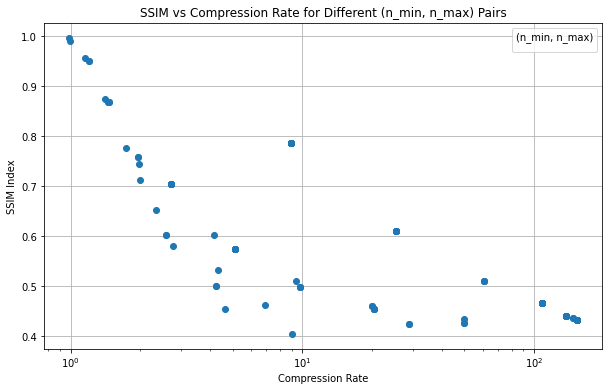

results for image  Female_(NTSC_test_image)


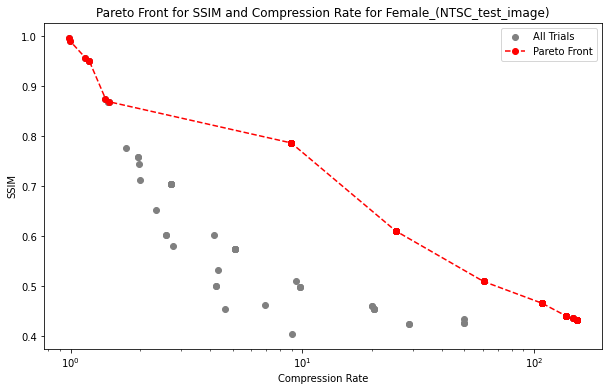

[I 2024-10-31 19:35:24,709] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Peppers_time:2024-10-31_19-35-24


image name:  Peppers
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28367
File saved.


[I 2024-10-31 19:35:25,781] Trial 0 finished with values: [8.675309201362667, 0.4631861733340548] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.0293262004852295
SSIM Index : 0.4631861733340548

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33560
File saved.


[I 2024-10-31 19:35:28,190] Trial 1 finished with values: [5.698335537918871, 0.34046629623363545] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 2.3570377826690674
SSIM Index : 0.34046629623363545

image name:  Peppers
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-31 19:35:31,547] Trial 2 finished with values: [3.4927132809491317, 0.4701854784784144] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.303449869155884
SSIM Index : 0.4701854784784144

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262707
File saved.


[I 2024-10-31 19:35:37,710] Trial 3 finished with values: [2.2920780884902388, 0.5998778146068542] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 6.101684331893921
SSIM Index : 0.5998778146068542

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31362
File saved.


[I 2024-10-31 19:35:45,381] Trial 4 finished with values: [4.55786457414918, 0.43877066913178336] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 7.614119291305542
SSIM Index : 0.43877066913178336

image name:  Peppers
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:35:46,795] Trial 5 finished with values: [20.245672436750997, 0.41156973852814344] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.3644022941589355
SSIM Index : 0.41156973852814344

image name:  Peppers
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
File saved.


[I 2024-10-31 19:35:50,779] Trial 6 finished with values: [2.619035073942538, 0.5484727084013029] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.929757595062256
SSIM Index : 0.5484727084013029

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4567
File saved.


[I 2024-10-31 19:35:52,789] Trial 7 finished with values: [29.691172247429787, 0.39170998617655023] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.9587624073028564
SSIM Index : 0.39170998617655023

image name:  Peppers
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16082
File saved.


[I 2024-10-31 19:35:57,714] Trial 8 finished with values: [8.399184376421655, 0.30383510561083465] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 4.870992422103882
SSIM Index : 0.30383510561083465

image name:  Peppers
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:35:58,851] Trial 9 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.0864601135253906
SSIM Index : 0.4614084831190191

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:36:00,455] Trial 10 finished with values: [44.62646754143646, 0.4033947424927011] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.5381503105163574
SSIM Index : 0.4033947424927011

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:36:01,802] Trial 11 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.6786440830104932, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.2712311744689941
SSIM Index : 0.4144719733999033

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:36:03,166] Trial 12 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.6433077671486415, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 15.0141401748985, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.2819616794586182
SSIM Index : 0.4144719733999033

image name:  Peppers
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:36:04,701] Trial 13 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.6256686784685921, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 13.265287901477882, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.46382474899292
SSIM Index : 0.46894676698662724

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:36:08,246] Trial 14 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.6203109251296234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.4888486862182617
SSIM Index : 0.5816151861599193

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081360
File saved.


[I 2024-10-31 19:36:24,521] Trial 15 finished with values: [1.5402421111279947, 0.8237848599034625] and parameters: {'min_sparcity': 0.7674028378760763, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 6.795065796278994, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 16.213809728622437
SSIM Index : 0.8237848599034625

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:36:28,215] Trial 16 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.5709255861884776, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 2.589488546494979, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.6409568786621094
SSIM Index : 0.5816151861599193

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:36:29,435] Trial 17 finished with values: [246.28537398761316, 0.4126889445878013] and parameters: {'min_sparcity': 0.49800647956660665, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 984.7940308782788, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1576333045959473
SSIM Index : 0.4126889445878013

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 98325
File saved.


[I 2024-10-31 19:36:31,451] Trial 18 finished with values: [4.161558834657586, 0.5505685159769117] and parameters: {'min_sparcity': 0.7704989271387993, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 56.05550543577921, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.9440102577209473
SSIM Index : 0.5505685159769117

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:36:32,884] Trial 19 finished with values: [44.62646754143646, 0.4033947424927011] and parameters: {'min_sparcity': 0.35463873268250473, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.035168375868930096, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.373476266860962
SSIM Index : 0.4033947424927011

image name:  Peppers
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:36:33,631] Trial 20 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.7513333531776172, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 2.3691329778369523, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6739089488983154
SSIM Index : 0.41307519376201296

image name:  Peppers
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:36:35,076] Trial 21 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.6066653537315065, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 40.09575746070031, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.3897757530212402
SSIM Index : 0.46894676698662724

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:36:36,344] Trial 22 finished with values: [21.120812224219645, 0.41750915475205497] and parameters: {'min_sparcity': 0.012130548355998527, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 57.25843719200402, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1977851390838623
SSIM Index : 0.41750915475205497

image name:  Peppers
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:36:38,005] Trial 23 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.5557222406192883, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 3.4719819178969535, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.578634262084961
SSIM Index : 0.46894676698662724

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:36:42,642] Trial 24 finished with values: [2.8067814094907155, 0.6644981939054186] and parameters: {'min_sparcity': 0.6998159710953578, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 28.332877629734906, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 4.570741176605225
SSIM Index : 0.6644981939054186

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:36:43,974] Trial 25 finished with values: [38.49527142750763, 0.39999634044721966] and parameters: {'min_sparcity': 0.8794218646285838, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.9955387677148444, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.264557123184204
SSIM Index : 0.39999634044721966

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:36:44,723] Trial 26 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.5030265354431228, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 109.16594138564973, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6732683181762695
SSIM Index : 0.41307519376201296

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:36:45,948] Trial 27 finished with values: [246.28537398761316, 0.4126889445878013] and parameters: {'min_sparcity': 0.7105729944759445, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 7.69194498450678, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1632890701293945
SSIM Index : 0.4126889445878013

image name:  Peppers
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:36:50,067] Trial 28 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.8079854900911104, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 890.5751442253897, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 4.042567253112793
SSIM Index : 0.5816151861599193

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 28367
File saved.


[I 2024-10-31 19:36:51,127] Trial 29 finished with values: [8.675309201362667, 0.4631861733340548] and parameters: {'min_sparcity': 0.6131082748931094, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.05160810295622647, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.9966902732849121
SSIM Index : 0.4631861733340548

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:36:52,392] Trial 30 finished with values: [246.28537398761316, 0.4126889445878013] and parameters: {'min_sparcity': 0.3078687812445219, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.1089982330888149, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.19539475440979
SSIM Index : 0.4126889445878013

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:36:56,170] Trial 31 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.6906618029455751, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.008323850017473412, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.6971774101257324
SSIM Index : 0.5816151861599193

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:36:57,887] Trial 32 finished with values: [5.055824506841143, 0.5312981138679226] and parameters: {'min_sparcity': 0.5688634495003281, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 23.050857354408322, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.652076005935669
SSIM Index : 0.5312981138679226

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:36:58,585] Trial 33 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.41047238611518083, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 6.245265437113218, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6380789279937744
SSIM Index : 0.41307519376201296

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:36:59,869] Trial 34 finished with values: [21.120812224219645, 0.41750915475205497] and parameters: {'min_sparcity': 0.9262498978034777, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 25.541983981802357, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.2171883583068848
SSIM Index : 0.41750915475205497

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 1486142
File saved.


[I 2024-10-31 19:37:28,229] Trial 35 finished with values: [1.0165454370264622, 0.984742681933875] and parameters: {'min_sparcity': 0.7138098088764177, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 110.37759688680822, 'exponent_a_cols': 8}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 28.266332149505615
SSIM Index : 0.984742681933875

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40032
File saved.


[I 2024-10-31 19:37:30,257] Trial 36 finished with values: [6.037618836280395, 0.47005654698592664] and parameters: {'min_sparcity': 0.8339707074153085, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.4849397047439395, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.9386894702911377
SSIM Index : 0.47005654698592664

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 3413640
File saved.


[I 2024-10-31 19:38:02,105] Trial 37 finished with values: [1.0000773824608784, 0.9967794989336753] and parameters: {'min_sparcity': 0.5204187379603943, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 1.6073619635623315, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 31.76370620727539
SSIM Index : 0.9967794989336753

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:38:03,399] Trial 38 finished with values: [38.49527142750763, 0.39999634044721966] and parameters: {'min_sparcity': 0.21118266691283105, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.0012211824849688467, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.22951078414917
SSIM Index : 0.39999634044721966

image name:  Peppers
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 33560
File saved.


[I 2024-10-31 19:38:05,691] Trial 39 finished with values: [5.698335537918871, 0.34046629623363545] and parameters: {'min_sparcity': 0.43620045486069625, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.008937022528639213, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 2.2052531242370605
SSIM Index : 0.34046629623363545

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:38:06,940] Trial 40 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.6426669016344242, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 117.21683936951258, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1626582145690918
SSIM Index : 0.4144719733999033

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081355
File saved.


[I 2024-10-31 19:38:22,733] Trial 41 finished with values: [1.5402283439699196, 0.8237847320723428] and parameters: {'min_sparcity': 0.7628471702375218, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.603221686031967, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 15.706016302108765
SSIM Index : 0.8237847320723428

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:38:23,433] Trial 42 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.6537665702642825, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.870573406381047, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6378443241119385
SSIM Index : 0.41307519376201296

image name:  Peppers
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:38:24,347] Trial 43 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.9001069237709676, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 12.263983393391685, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.8563888072967529
SSIM Index : 0.4614084831190191

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 16082
File saved.


[I 2024-10-31 19:38:27,984] Trial 44 finished with values: [8.399184376421655, 0.30383510561083465] and parameters: {'min_sparcity': 0.7238584087856088, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 25.719848709204044, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.574371576309204
SSIM Index : 0.30383510561083465

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:38:29,218] Trial 45 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.800946184719263, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.6282246109393534, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.14870023727417
SSIM Index : 0.4144719733999033

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 827085
File saved.


[I 2024-10-31 19:38:43,237] Trial 46 finished with values: [1.5622965732124887, 0.872223911533555] and parameters: {'min_sparcity': 0.6089179285232241, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 424.06418107018317, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 13.93496584892273
SSIM Index : 0.872223911533555

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77452
File saved.


[I 2024-10-31 19:38:46,006] Trial 47 finished with values: [4.073254329703579, 0.451781457259674] and parameters: {'min_sparcity': 0.6017792334105359, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 185.89212649299049, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 2.6940884590148926
SSIM Index : 0.451781457259674

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 557270
File saved.


[I 2024-10-31 19:38:55,695] Trial 48 finished with values: [1.768092099637799, 0.7342546527511563] and parameters: {'min_sparcity': 0.527676457813939, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 507.2023641777243, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 9.595524787902832
SSIM Index : 0.7342546527511563

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:38:56,929] Trial 49 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.17022143738425138, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 14.834138813863209, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1684670448303223
SSIM Index : 0.4144719733999033

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:38:58,369] Trial 50 finished with values: [20.245672436750997, 0.41156973852814344] and parameters: {'min_sparcity': 0.6771822767397528, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 45.695500371858046, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.3493716716766357
SSIM Index : 0.41156973852814344

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559175
File saved.


[I 2024-10-31 19:39:08,340] Trial 51 finished with values: [1.7689936009307736, 0.7342581934591781] and parameters: {'min_sparcity': 0.48066225647128197, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 350.0940086460276, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 9.869922161102295
SSIM Index : 0.7342581934591781

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31362
File saved.


[I 2024-10-31 19:39:16,909] Trial 52 finished with values: [4.55786457414918, 0.43877066913178336] and parameters: {'min_sparcity': 0.4873025609110555, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.003431738791206564, 'exponent_a_cols': 8}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 8.485506772994995
SSIM Index : 0.43877066913178336

image name:  Peppers
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:39:20,813] Trial 53 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.6138471367849401, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.3149748735815547, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.832226037979126
SSIM Index : 0.5816151861599193

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:39:21,804] Trial 54 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.6485701571240743, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 12.311130421223453, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.9216454029083252
SSIM Index : 0.4614084831190191

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:39:23,279] Trial 55 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.7358018418270078, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 71.73241164822547, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.412226676940918
SSIM Index : 0.46894676698662724

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:39:24,519] Trial 56 finished with values: [246.28537398761316, 0.4126889445878013] and parameters: {'min_sparcity': 0.05364523246537367, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 3.848218815247883, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.176072359085083
SSIM Index : 0.4126889445878013

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 64230
File saved.


[I 2024-10-31 19:39:28,095] Trial 57 finished with values: [3.4927132809491317, 0.4701854784784144] and parameters: {'min_sparcity': 0.5571241619860046, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 24.66113131122224, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.478231191635132
SSIM Index : 0.4701854784784144

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:39:29,645] Trial 58 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.3592030223755524, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 2.1580370069588, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.469188928604126
SSIM Index : 0.46894676698662724

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:39:30,889] Trial 59 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.45567124213359295, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 1.1301006865156626, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1741273403167725
SSIM Index : 0.4144719733999033

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:39:31,940] Trial 60 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.6843674780955864, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.15462500446927352, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.9666798114776611
SSIM Index : 0.4614084831190191

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 31362
File saved.


[I 2024-10-31 19:39:40,379] Trial 61 finished with values: [4.55786457414918, 0.43877066913178336] and parameters: {'min_sparcity': 0.7116102201478353, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 105.1504248123186, 'exponent_a_cols': 8}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 8.360581874847412
SSIM Index : 0.43877066913178336

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:39:44,077] Trial 62 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.5944288861787117, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 35.26211433193173, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.618299722671509
SSIM Index : 0.5816151861599193

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:39:45,272] Trial 63 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.8003042774539371, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 10.083342028630476, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.129192590713501
SSIM Index : 0.4144719733999033

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:39:46,251] Trial 64 finished with values: [157.1763453937367, 0.4249992330907051] and parameters: {'min_sparcity': 0.6473748862870964, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 17.123046216194744, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.8894500732421875
SSIM Index : 0.4249992330907051

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:39:47,129] Trial 65 finished with values: [157.1763453937367, 0.4249992330907051] and parameters: {'min_sparcity': 0.6287441767267692, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 4.572675951875311, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.8130385875701904
SSIM Index : 0.4249992330907051

image name:  Peppers
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:39:48,583] Trial 66 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.5732336028819582, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 16.084987570933773, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.3893332481384277
SSIM Index : 0.46894676698662724

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:39:49,840] Trial 67 finished with values: [21.120812224219645, 0.41750915475205497] and parameters: {'min_sparcity': 0.6750100253305109, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 73.56433541414758, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.182450532913208
SSIM Index : 0.41750915475205497

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1080615
File saved.


[I 2024-10-31 19:40:05,836] Trial 68 finished with values: [1.539806270589707, 0.8237839851772618] and parameters: {'min_sparcity': 0.7516405253615488, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 17.348370156862735, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 15.907391548156738
SSIM Index : 0.8237839851772618

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:40:07,331] Trial 69 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.4737659142433313, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 35.27896303645924, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.436384677886963
SSIM Index : 0.46894676698662724

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:40:08,271] Trial 70 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.5339988286434079, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.6536603239897106, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.8755111694335938
SSIM Index : 0.4614084831190191

image name:  Peppers
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:40:11,892] Trial 71 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.7028431997218642, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 6.281708375875437, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.5620641708374023
SSIM Index : 0.5816151861599193

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:40:12,754] Trial 72 finished with values: [157.1763453937367, 0.4249992330907051] and parameters: {'min_sparcity': 0.5934052367094017, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 3.2346769056105202, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.7974867820739746
SSIM Index : 0.4249992330907051

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:40:13,437] Trial 73 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.6597379993958985, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 8.43547882752232, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6209568977355957
SSIM Index : 0.41307519376201296

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:40:14,866] Trial 74 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.6347954111143644, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 169.97501281776246, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.370046854019165
SSIM Index : 0.46894676698662724

image name:  Peppers
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:40:19,405] Trial 75 finished with values: [2.8067814094907155, 0.6644981939054186] and parameters: {'min_sparcity': 0.575853358347849, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 20.182715615798685, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 4.473305940628052
SSIM Index : 0.6644981939054186

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:40:20,243] Trial 76 finished with values: [157.1763453937367, 0.4249992330907051] and parameters: {'min_sparcity': 0.9694427242946155, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 417.8217533722481, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.7765405178070068
SSIM Index : 0.4249992330907051

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33560
File saved.


[I 2024-10-31 19:40:22,517] Trial 77 finished with values: [5.698335537918871, 0.34046629623363545] and parameters: {'min_sparcity': 0.8313252742169404, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 10.649561992445348, 'exponent_a_cols': 6}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 2.2026422023773193
SSIM Index : 0.34046629623363545

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1073785
File saved.


[I 2024-10-31 19:40:38,362] Trial 78 finished with values: [1.5367531429013088, 0.8237800247100837] and parameters: {'min_sparcity': 0.727163849881188, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 32.04046537679882, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 15.758459568023682
SSIM Index : 0.8237800247100837

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2757
File saved.


[I 2024-10-31 19:40:39,773] Trial 79 finished with values: [44.62646754143646, 0.4033947424927011] and parameters: {'min_sparcity': 0.7883060061305232, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 57.445994825274354, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.3449368476867676
SSIM Index : 0.4033947424927011

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:40:41,302] Trial 80 finished with values: [76.00014701558365, 0.46894676698662724] and parameters: {'min_sparcity': 0.5380241709391131, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.017657540677507636, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.4422903060913086
SSIM Index : 0.46894676698662724

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 77452
File saved.


[I 2024-10-31 19:40:44,047] Trial 81 finished with values: [4.073254329703579, 0.451781457259674] and parameters: {'min_sparcity': 0.6602370307658965, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.6275758706174215, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 2.667309284210205
SSIM Index : 0.451781457259674

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:40:45,295] Trial 82 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.6211010554966243, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 6.251650924322439, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1533229351043701
SSIM Index : 0.4144719733999033

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:40:58,557] Trial 83 finished with values: [9.881544490108, 0.7505051666264336] and parameters: {'min_sparcity': 0.2802812071144855, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 9.609914624731243, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 13.175986528396606
SSIM Index : 0.7505051666264336

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2063495
File saved.


[I 2024-10-31 19:41:20,629] Trial 84 finished with values: [1.2496265283330836, 0.9160277852901025] and parameters: {'min_sparcity': 0.25800651849139944, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 3.0466386021471736, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 22.002843618392944
SSIM Index : 0.9160277852901025

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2876535
File saved.


[I 2024-10-31 19:41:47,007] Trial 85 finished with values: [1.0761222769237175, 0.9463084958630164] and parameters: {'min_sparcity': 0.2907291685464749, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 5.070094183193948, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 26.304962635040283
SSIM Index : 0.9463084958630164

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2796165
File saved.


[I 2024-10-31 19:42:12,964] Trial 86 finished with values: [1.0773086092494415, 0.9461091338927449] and parameters: {'min_sparcity': 0.2061846726926989, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 18.359881882011173, 'exponent_a_cols': 4}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 25.880570888519287
SSIM Index : 0.9461091338927449

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2060790
File saved.


[I 2024-10-31 19:42:34,916] Trial 87 finished with values: [1.2496386113004676, 0.9160230659724538] and parameters: {'min_sparcity': 0.23545417332571167, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 9.287453087048478, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 21.87910223007202
SSIM Index : 0.9160230659724538

image name:  Peppers
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2427640
File saved.


[I 2024-10-31 19:42:58,564] Trial 88 finished with values: [1.0067734553775745, 0.9898501095985148] and parameters: {'min_sparcity': 0.3453707568148945, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 19.77951888556856, 'exponent_a_cols': 5}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 23.579001903533936
SSIM Index : 0.9898501095985148

image name:  Peppers
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:43:02,166] Trial 89 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.7749587110606657, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 2.7921325341671728, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.540673017501831
SSIM Index : 0.5816151861599193

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:43:02,848] Trial 90 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.5236858544684158, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 12.541910211490688, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6220004558563232
SSIM Index : 0.41307519376201296

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:43:03,981] Trial 91 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.02862313188186999, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 43.78088360423987, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.0699098110198975
SSIM Index : 0.4144719733999033

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:43:05,208] Trial 92 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.12891177876307697, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 17.725264409131793, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1361236572265625
SSIM Index : 0.4144719733999033

image name:  Peppers
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:43:08,820] Trial 93 finished with values: [28.444646197865083, 0.5816151861599193] and parameters: {'min_sparcity': 0.681317135121822, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.08573357970944638, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 3.527208089828491
SSIM Index : 0.5816151861599193

image name:  Peppers
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:43:09,746] Trial 94 finished with values: [9.636375498639227, 0.4614084831190191] and parameters: {'min_sparcity': 0.3983944568299984, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 7.940952326873816, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.8596127033233643
SSIM Index : 0.4614084831190191

image name:  Peppers
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:43:10,450] Trial 95 finished with values: [222.05884879725085, 0.41307519376201296] and parameters: {'min_sparcity': 0.7396879754603845, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 26.1485368476458, 'exponent_a_cols': 1}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 0.6372730731964111
SSIM Index : 0.41307519376201296

image name:  Peppers
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:43:11,769] Trial 96 finished with values: [38.49527142750763, 0.39999634044721966] and parameters: {'min_sparcity': 0.6345854034596504, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 4.034989661493946, 'exponent_a_cols': 3}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.2439100742340088
SSIM Index : 0.39999634044721966

image name:  Peppers
16 8
processed_blocks: 12288
bytes_written (without DEFLATE): 2937407
File saved.


[I 2024-10-31 19:44:11,131] Trial 97 finished with values: [1.0007879259543198, 0.9975020095261081] and parameters: {'min_sparcity': 0.0884064285563721, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 11.893142274594561, 'exponent_a_cols': 7}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 59.26365518569946
SSIM Index : 0.9975020095261081

image name:  Peppers
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:44:12,834] Trial 98 finished with values: [5.055824506841143, 0.5312981138679226] and parameters: {'min_sparcity': 0.5911931545736028, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 12.989413158476935, 'exponent_a_cols': 2}.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.6311869621276855
SSIM Index : 0.5312981138679226

image name:  Peppers
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:44:14,048] Trial 99 finished with values: [259.3843452082288, 0.4144719733999033] and parameters: {'min_sparcity': 0.7093348254033961, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 5.844439268093826, 'exponent_a_cols': 1}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Peppers_reconstructed.png
execution_time 1.1489734649658203
SSIM Index : 0.4144719733999033



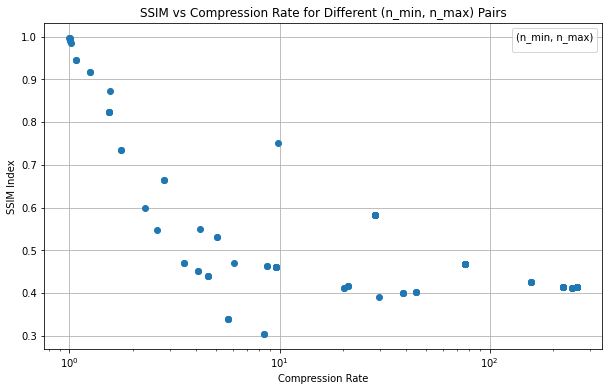

results for image  Peppers


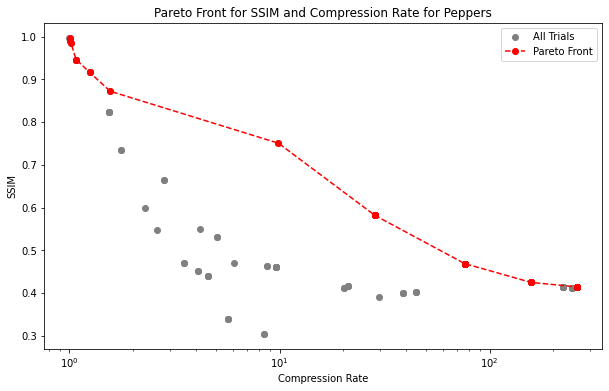

[I 2024-10-31 19:44:14,620] A new study created in memory with name: multiobjTPE_trials:100_seed:43_image:Mandrill_(a.k.a._Baboon)_time:2024-10-31_19-44-14


image name:  Mandrill_(a.k.a._Baboon)
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 28422
File saved.


[I 2024-10-31 19:44:15,658] Trial 0 finished with values: [10.738599915146372, 0.19807294415834936] and parameters: {'min_sparcity': 0.12390402072588116, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 0.027767560053080172, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.9923303127288818
SSIM Index : 0.19807294415834936

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 33570
File saved.


[I 2024-10-31 19:44:17,978] Trial 1 finished with values: [6.834645669291339, 0.18204670977038137] and parameters: {'min_sparcity': 0.8605461160391117, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.0014930795478222975, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 2.268902540206909
SSIM Index : 0.18204670977038137

image name:  Mandrill_(a.k.a._Baboon)
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 64235
File saved.


[I 2024-10-31 19:44:21,449] Trial 2 finished with values: [4.451062871934835, 0.23382128925499487] and parameters: {'min_sparcity': 0.4010005182466958, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 0.0021943688007952746, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.4162561893463135
SSIM Index : 0.23382128925499487

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
File saved.


[I 2024-10-31 19:44:27,605] Trial 3 finished with values: [2.8739502668332007, 0.3859191224471399] and parameters: {'min_sparcity': 0.2288187059255276, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.002883873457990516, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 6.098102331161499
SSIM Index : 0.3859191224471399

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 31357
File saved.


[I 2024-10-31 19:44:35,024] Trial 4 finished with values: [5.6101782072878805, 0.20335021208478157] and parameters: {'min_sparcity': 0.8504497562674128, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.20523975444033044, 'exponent_a_cols': 8}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 7.356616497039795
SSIM Index : 0.20335021208478157

image name:  Mandrill_(a.k.a._Baboon)
64 64
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:44:36,428] Trial 5 finished with values: [25.16492344402466, 0.18008976767806625] and parameters: {'min_sparcity': 0.45130077723132167, 'exponent_min_n': 6, 'exponent_max_n': 6, 'max_error': 241.3189793910891, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.351222276687622
SSIM Index : 0.18008976767806625

image name:  Mandrill_(a.k.a._Baboon)
32 4
processed_blocks: 768
bytes_written (without DEFLATE): 136297
File saved.


[I 2024-10-31 19:44:40,411] Trial 6 finished with values: [3.4803260474990925, 0.29586870506598156] and parameters: {'min_sparcity': 0.2696817743704176, 'exponent_min_n': 2, 'exponent_max_n': 5, 'max_error': 0.7138027257662096, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.9258246421813965
SSIM Index : 0.29586870506598156

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 4542
File saved.


[I 2024-10-31 19:44:42,761] Trial 7 finished with values: [32.56842863760358, 0.17791462905793304] and parameters: {'min_sparcity': 0.9784220927411861, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 289.0137164706386, 'exponent_a_cols': 5}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 2.295336961746216
SSIM Index : 0.17791462905793304

image name:  Mandrill_(a.k.a._Baboon)
128 8
processed_blocks: 48
bytes_written (without DEFLATE): 16107
File saved.


[I 2024-10-31 19:44:47,844] Trial 8 finished with values: [10.251304150601044, 0.1750090567667471] and parameters: {'min_sparcity': 0.11297876035621526, 'exponent_min_n': 3, 'exponent_max_n': 7, 'max_error': 0.296290618336323, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 5.027485609054565
SSIM Index : 0.1750090567667471

image name:  Mandrill_(a.k.a._Baboon)
32 32
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:44:48,913] Trial 9 finished with values: [12.978074943085096, 0.18955949381205783] and parameters: {'min_sparcity': 0.6754555066814144, 'exponent_min_n': 5, 'exponent_max_n': 5, 'max_error': 240.1505681565605, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.0239696502685547
SSIM Index : 0.18955949381205783

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
File saved.


[I 2024-10-31 19:44:50,487] Trial 10 finished with values: [49.57474146035725, 0.17719954983801306] and parameters: {'min_sparcity': 0.9871179892332056, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 13.083942921541707, 'exponent_a_cols': 4}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.5113554000854492
SSIM Index : 0.17719954983801306

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:44:51,957] Trial 11 finished with values: [49.05969917816716, 0.17421055479046818] and parameters: {'min_sparcity': 0.6540337852300198, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 15.887128783449372, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3891913890838623
SSIM Index : 0.17421055479046818

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:44:53,338] Trial 12 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.6059507601264229, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.778039860056361, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2977831363677979
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:44:54,692] Trial 13 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.6159826350785884, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 7.730170088504397, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2728009223937988
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:44:56,235] Trial 14 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.522592577586653, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 10.671974291643279, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.4711296558380127
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:44:57,611] Trial 15 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.5389879840136532, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 2.103846215160764, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3224375247955322
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:45:01,478] Trial 16 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.7610231514940821, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 26.93361328466897, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.8088531494140625
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1080430
File saved.


[I 2024-10-31 19:45:17,292] Trial 17 finished with values: [1.4820439433294532, 0.6643087745163103] and parameters: {'min_sparcity': 0.7699623312488544, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 54.261203761062525, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 15.749165058135986
SSIM Index : 0.6643087745163103

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:45:18,486] Trial 18 finished with values: [302.9066539013882, 0.1715886048103243] and parameters: {'min_sparcity': 0.35360492078192596, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.020407130198244274, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.1326611042022705
SSIM Index : 0.1715886048103243

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 778192
File saved.


[I 2024-10-31 19:45:26,275] Trial 19 finished with values: [1.6038343678793117, 0.6278151616068006] and parameters: {'min_sparcity': 0.7674661163887234, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 54.60005477607847, 'exponent_a_cols': 4}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 7.714690923690796
SSIM Index : 0.6278151616068006

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:45:27,413] Trial 20 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.020966336660231344, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 976.7353569963619, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.075939655303955
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:45:28,130] Trial 21 finished with values: [271.575965665236, 0.1713392263461055] and parameters: {'min_sparcity': 0.5625781796327175, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 2.8229795999355343, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.645627498626709
SSIM Index : 0.1713392263461055

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:45:29,758] Trial 22 finished with values: [5.748918850165352, 0.24010906503634516] and parameters: {'min_sparcity': 0.49775357416716354, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 46.18665188827253, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.5704658031463623
SSIM Index : 0.24010906503634516

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:45:30,445] Trial 23 finished with values: [271.575965665236, 0.1713392263461055] and parameters: {'min_sparcity': 0.7203002975283977, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.87959136103302, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.6261396408081055
SSIM Index : 0.1713392263461055

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:45:32,138] Trial 24 finished with values: [5.748918850165352, 0.24010906503634516] and parameters: {'min_sparcity': 0.5764619260613666, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.951940143195337, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.6314826011657715
SSIM Index : 0.24010906503634516

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:45:32,817] Trial 25 finished with values: [271.575965665236, 0.1713392263461055] and parameters: {'min_sparcity': 0.33930451350447194, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 19.42213991108101, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.6243579387664795
SSIM Index : 0.1713392263461055

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 492832
File saved.


[I 2024-10-31 19:45:38,681] Trial 26 finished with values: [2.0884253605729564, 0.49004396347556756] and parameters: {'min_sparcity': 0.479711681759038, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.0868184222099575, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 5.803530216217041
SSIM Index : 0.49004396347556756

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:45:39,886] Trial 27 finished with values: [302.9066539013882, 0.1715886048103243] and parameters: {'min_sparcity': 0.8657458530350106, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 5.2372272540225, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.1403121948242188
SSIM Index : 0.1715886048103243

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:45:40,813] Trial 28 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.4396495379277111, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.1352003436062332, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.8511459827423096
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:45:42,547] Trial 29 finished with values: [25.16492344402466, 0.18008976767806625] and parameters: {'min_sparcity': 0.620040167978489, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 0.06386535651489743, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.6647815704345703
SSIM Index : 0.18008976767806625

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 2767
File saved.


[I 2024-10-31 19:45:44,083] Trial 30 finished with values: [49.57474146035725, 0.17719954983801306] and parameters: {'min_sparcity': 0.7073124053820253, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.013818056174264572, 'exponent_a_cols': 4}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.4476923942565918
SSIM Index : 0.17719954983801306

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:45:45,002] Trial 31 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.5333615893032065, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.5893335840675622, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.8393979072570801
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:45:46,288] Trial 32 finished with values: [29.702027788208788, 0.1779906125332616] and parameters: {'min_sparcity': 0.40259448736076503, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 29.801472457209382, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2141072750091553
SSIM Index : 0.1779906125332616

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:45:47,223] Trial 33 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.4096476926824884, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.4829757766784953, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.856661319732666
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:45:48,654] Trial 34 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.30710364642684335, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 95.31839523062406, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.374737024307251
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 311550
File saved.


[I 2024-10-31 19:45:52,064] Trial 35 finished with values: [2.3839775154750646, 0.42159896626001564] and parameters: {'min_sparcity': 0.21609088612801164, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 8.891259214575388, 'exponent_a_cols': 5}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.346633195877075
SSIM Index : 0.42159896626001564

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 125620
File saved.


[I 2024-10-31 19:45:59,143] Trial 36 finished with values: [4.209835803816164, 0.2843306858447373] and parameters: {'min_sparcity': 0.7841427417662744, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 107.2401701401213, 'exponent_a_cols': 8}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 7.002907037734985
SSIM Index : 0.2843306858447373

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:46:03,765] Trial 37 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.4362567978522971, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.008023520353102866, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.543231964111328
SSIM Index : 0.387248424363326

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 1557
File saved.


[I 2024-10-31 19:46:05,077] Trial 38 finished with values: [49.05969917816716, 0.17421055479046818] and parameters: {'min_sparcity': 0.6019469914844137, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.001223769675680232, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2438907623291016
SSIM Index : 0.17421055479046818

image name:  Mandrill_(a.k.a._Baboon)
32 8
processed_blocks: 768
bytes_written (without DEFLATE): 136297
File saved.


[I 2024-10-31 19:46:08,779] Trial 39 finished with values: [3.4803260474990925, 0.29586870506598156] and parameters: {'min_sparcity': 0.8957975935331579, 'exponent_min_n': 3, 'exponent_max_n': 5, 'max_error': 0.20500130005578038, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.604811906814575
SSIM Index : 0.29586870506598156

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:46:09,671] Trial 40 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.5158266733801457, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.1515035069170123, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.8133485317230225
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
File saved.


[I 2024-10-31 19:46:25,773] Trial 41 finished with values: [1.482068241863254, 0.6643083811994743] and parameters: {'min_sparcity': 0.8413589581579136, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 7.412938420278929, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 16.03457808494568
SSIM Index : 0.6643083811994743

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:46:29,315] Trial 42 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.93973708685143, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 24.30878658470133, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.48075532913208
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1067925
File saved.


[I 2024-10-31 19:46:47,657] Trial 43 finished with values: [1.5045437901534569, 0.7303345342655821] and parameters: {'min_sparcity': 0.698643719119832, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 127.80115365711573, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 18.258341312408447
SSIM Index : 0.7303345342655821

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:46:48,627] Trial 44 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.8155692857514077, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 757.6795618737231, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.9010241031646729
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
File saved.


[I 2024-10-31 19:47:05,979] Trial 45 finished with values: [1.482068241863254, 0.6643083811994743] and parameters: {'min_sparcity': 0.2191784789346623, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 11.284067637686752, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 17.28354239463806
SSIM Index : 0.6643083811994743

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:47:07,184] Trial 46 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.6511235643697901, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 0.003587813883875294, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.142505168914795
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:47:08,618] Trial 47 finished with values: [25.16492344402466, 0.18008976767806625] and parameters: {'min_sparcity': 0.7246130549868074, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 4.261932073676844, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3389644622802734
SSIM Index : 0.18008976767806625

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 16917
File saved.


[I 2024-10-31 19:47:09,617] Trial 48 finished with values: [12.978074943085096, 0.18955949381205783] and parameters: {'min_sparcity': 0.6467988042794341, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 444.0087682991438, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.9166061878204346
SSIM Index : 0.18955949381205783

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559670
File saved.


[I 2024-10-31 19:47:19,433] Trial 49 finished with values: [1.9712277728626435, 0.5462622034116963] and parameters: {'min_sparcity': 0.4605956379447445, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 32.88241559124309, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 9.734570741653442
SSIM Index : 0.5462622034116963

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:47:20,707] Trial 50 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.7506747765802788, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.5588862952376061, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2006134986877441
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 12267
bytes_written (without DEFLATE): 2559585
File saved.


[I 2024-10-31 19:48:50,446] Trial 51 finished with values: [1.000483820474144, 0.9978147506144658] and parameters: {'min_sparcity': 0.4673343737338811, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 39.74246674623982, 'exponent_a_cols': 8}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 89.63480877876282
SSIM Index : 0.9978147506144658

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1067925
File saved.


[I 2024-10-31 19:49:09,170] Trial 52 finished with values: [1.5045437901534569, 0.7303345342655821] and parameters: {'min_sparcity': 0.6865376325710147, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 107.11112895515119, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 18.615044116973877
SSIM Index : 0.7303345342655821

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 2192562
File saved.


[I 2024-10-31 19:49:26,222] Trial 53 finished with values: [1.125554308441853, 0.9023534670512404] and parameters: {'min_sparcity': 0.5769071773341434, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 16.22065679331814, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 16.977176904678345
SSIM Index : 0.9023534670512404

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:49:29,927] Trial 54 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.8073579886676151, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 72.90567185584348, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.647185802459717
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311550
File saved.


[I 2024-10-31 19:49:33,385] Trial 55 finished with values: [2.3839775154750646, 0.42159896626001564] and parameters: {'min_sparcity': 0.13843731410452875, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 159.3033170906587, 'exponent_a_cols': 5}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.3918228149414062
SSIM Index : 0.42159896626001564

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:49:34,246] Trial 56 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.6765416562890239, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 2.6804002504720734, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.8017702102661133
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 837
File saved.


[I 2024-10-31 19:49:35,447] Trial 57 finished with values: [302.9066539013882, 0.1715886048103243] and parameters: {'min_sparcity': 0.6079349105444537, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 5.990244393872813, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.135894775390625
SSIM Index : 0.1715886048103243

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 67605
File saved.


[I 2024-10-31 19:49:37,228] Trial 58 finished with values: [5.748918850165352, 0.24010906503634516] and parameters: {'min_sparcity': 0.5420890400671861, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 25.728117736788324, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.6980319023132324
SSIM Index : 0.24010906503634516

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:49:38,418] Trial 59 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.9016314920623869, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 2.0613627722311305, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.1206450462341309
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:49:39,178] Trial 60 finished with values: [271.575965665236, 0.1713392263461055] and parameters: {'min_sparcity': 0.4442271841140081, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.850517416628855, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.6796479225158691
SSIM Index : 0.1713392263461055

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:49:40,041] Trial 61 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.5004155669418803, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 12.83254632309463, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.798680305480957
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 262642
File saved.


[I 2024-10-31 19:49:46,052] Trial 62 finished with values: [2.8739502668332007, 0.3859191224471399] and parameters: {'min_sparcity': 0.7384114943549356, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 42.1563228512858, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 5.93031120300293
SSIM Index : 0.3859191224471399

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:49:51,172] Trial 63 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.011593948473677729, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 17.326111330163982, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 5.040039300918579
SSIM Index : 0.387248424363326

image name:  Mandrill_(a.k.a._Baboon)
128 128
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:49:52,422] Trial 64 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.5649811679123468, 'exponent_min_n': 7, 'exponent_max_n': 7, 'max_error': 207.2992308986935, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.180083990097046
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
64 16
processed_blocks: 192
bytes_written (without DEFLATE): 2325
File saved.


[I 2024-10-31 19:49:53,240] Trial 65 finished with values: [271.575965665236, 0.1713392263461055] and parameters: {'min_sparcity': 0.6402277095400333, 'exponent_min_n': 4, 'exponent_max_n': 6, 'max_error': 0.24702833375214625, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.728996992111206
SSIM Index : 0.1713392263461055

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:49:54,604] Trial 66 finished with values: [29.702027788208788, 0.1779906125332616] and parameters: {'min_sparcity': 0.7024623087433407, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 10.997608254124719, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2849023342132568
SSIM Index : 0.1779906125332616

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:49:56,224] Trial 67 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.7889928400578792, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 65.74736457007302, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.530519723892212
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
128 64
processed_blocks: 48
bytes_written (without DEFLATE): 597
File saved.


[I 2024-10-31 19:49:57,525] Trial 68 finished with values: [318.2957746478873, 0.17098570767146853] and parameters: {'min_sparcity': 0.3639717365129557, 'exponent_min_n': 6, 'exponent_max_n': 7, 'max_error': 0.09032379071021833, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.2271437644958496
SSIM Index : 0.17098570767146853

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 40057
File saved.


[I 2024-10-31 19:49:59,820] Trial 69 finished with values: [7.465455403492213, 0.21568108557991655] and parameters: {'min_sparcity': 0.10924227551499605, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 1.2918663435117579, 'exponent_a_cols': 4}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 2.1944305896759033
SSIM Index : 0.21568108557991655

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:50:01,250] Trial 70 finished with values: [29.702027788208788, 0.1779906125332616] and parameters: {'min_sparcity': 0.5746419026969541, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 29.16154621955118, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3287606239318848
SSIM Index : 0.1779906125332616

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 3886417
File saved.


[I 2024-10-31 19:50:32,607] Trial 71 finished with values: [0.9996619198528878, 0.9996076172650759] and parameters: {'min_sparcity': 0.353341168976427, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.04780968641625975, 'exponent_a_cols': 7}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 31.264620065689087
SSIM Index : 0.9996076172650759

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:50:45,295] Trial 72 finished with values: [10.339073886474297, 0.46536352046232854] and parameters: {'min_sparcity': 0.854991103475664, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.018901992604244716, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 12.618390083312988
SSIM Index : 0.46536352046232854

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:50:58,429] Trial 73 finished with values: [10.339073886474297, 0.46536352046232854] and parameters: {'min_sparcity': 0.9613076707304181, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.004649515992054124, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 13.066356897354126
SSIM Index : 0.46536352046232854

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:51:10,871] Trial 74 finished with values: [10.339073886474297, 0.46536352046232854] and parameters: {'min_sparcity': 0.8755636605451873, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.02072997122027116, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 12.37986159324646
SSIM Index : 0.46536352046232854

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 1081365
File saved.


[I 2024-10-31 19:51:26,938] Trial 75 finished with values: [1.482068241863254, 0.6643083811994743] and parameters: {'min_sparcity': 0.8383550805092036, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.011175487288341062, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 15.997528076171875
SSIM Index : 0.6643083811994743

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:51:30,634] Trial 76 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.9374635227941677, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.044226316516741006, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.633152723312378
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:51:35,203] Trial 77 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.7634816201198869, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.02611810938749363, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.501733779907227
SSIM Index : 0.387248424363326

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:51:47,626] Trial 78 finished with values: [10.339073886474297, 0.46536352046232854] and parameters: {'min_sparcity': 0.8242720382289351, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.13311971061473735, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 12.357984781265259
SSIM Index : 0.46536352046232854

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:51:51,245] Trial 79 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.9048771398099047, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.002230444869300506, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.5574452877044678
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:51:55,902] Trial 80 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.8662148962044144, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.010346398120474031, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.59101128578186
SSIM Index : 0.387248424363326

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 559670
File saved.


[I 2024-10-31 19:52:05,086] Trial 81 finished with values: [1.9712277728626435, 0.5462622034116963] and parameters: {'min_sparcity': 0.4791270015013516, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.007233507733828281, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 9.100052833557129
SSIM Index : 0.5462622034116963

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 589845
File saved.


[I 2024-10-31 19:52:17,619] Trial 82 finished with values: [10.339073886474297, 0.46536352046232854] and parameters: {'min_sparcity': 0.7889070277256539, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.03413421255206997, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 12.456564664840698
SSIM Index : 0.46536352046232854

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:52:18,474] Trial 83 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.3806423625284538, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 0.01891883932246369, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.7937643527984619
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:52:19,909] Trial 84 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.3096010014931116, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 17.951520435473512, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3719978332519531
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2064070
File saved.


[I 2024-10-31 19:52:41,677] Trial 85 finished with values: [1.128942016057092, 0.8835968892320828] and parameters: {'min_sparcity': 0.8050416803838083, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 0.005327156668299489, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 21.693654537200928
SSIM Index : 0.8835968892320828

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:52:43,137] Trial 86 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.5171428552136983, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 8.339578515433015, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3902390003204346
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:52:47,725] Trial 87 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.7429486730552948, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 0.7726661520217806, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.509865045547485
SSIM Index : 0.387248424363326

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:52:48,747] Trial 88 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.9364868517154874, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 5.565812838611472, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.9510979652404785
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 4245
File saved.


[I 2024-10-31 19:52:51,072] Trial 89 finished with values: [29.702027788208788, 0.1779906125332616] and parameters: {'min_sparcity': 0.7042893453012752, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 34.1310515829567, 'exponent_a_cols': 2}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 2.1789469718933105
SSIM Index : 0.1779906125332616

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 311550
File saved.


[I 2024-10-31 19:52:55,360] Trial 90 finished with values: [2.3839775154750646, 0.42159896626001564] and parameters: {'min_sparcity': 0.4239659851294723, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.40077216425157125, 'exponent_a_cols': 5}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.173591613769531
SSIM Index : 0.42159896626001564

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:52:56,799] Trial 91 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.9961438433267653, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 0.038279525658664916, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.374640941619873
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
16 16
processed_blocks: 3072
bytes_written (without DEFLATE): 36885
File saved.


[I 2024-10-31 19:52:58,245] Trial 92 finished with values: [94.8257155702083, 0.1978578194511651] and parameters: {'min_sparcity': 0.5915014113268362, 'exponent_min_n': 4, 'exponent_max_n': 4, 'max_error': 0.015541928630121098, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3824996948242188
SSIM Index : 0.1978578194511651

image name:  Mandrill_(a.k.a._Baboon)
8 8
processed_blocks: 12288
bytes_written (without DEFLATE): 147477
File saved.


[I 2024-10-31 19:53:01,705] Trial 93 finished with values: [33.481771522302765, 0.2721485703367739] and parameters: {'min_sparcity': 0.46428759227243077, 'exponent_min_n': 3, 'exponent_max_n': 3, 'max_error': 0.05715403692037951, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 3.3970611095428467
SSIM Index : 0.2721485703367739

image name:  Mandrill_(a.k.a._Baboon)
4 4
processed_blocks: 49152
bytes_written (without DEFLATE): 2297115
File saved.


[I 2024-10-31 19:53:24,925] Trial 94 finished with values: [1.002155489847342, 0.993223576302567] and parameters: {'min_sparcity': 0.25121480995837847, 'exponent_min_n': 2, 'exponent_max_n': 2, 'max_error': 52.146354442787505, 'exponent_a_cols': 6}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 23.15231227874756
SSIM Index : 0.993223576302567

image name:  Mandrill_(a.k.a._Baboon)
32 16
processed_blocks: 768
bytes_written (without DEFLATE): 9237
File saved.


[I 2024-10-31 19:53:25,785] Trial 95 finished with values: [196.45203352995964, 0.17647885421674392] and parameters: {'min_sparcity': 0.6233002152394859, 'exponent_min_n': 4, 'exponent_max_n': 5, 'max_error': 14.638722260358284, 'exponent_a_cols': 1}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 0.7990593910217285
SSIM Index : 0.17647885421674392

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
File saved.


[I 2024-10-31 19:54:10,594] Trial 96 finished with values: [1.211151199624848, 0.8947404950448772] and parameters: {'min_sparcity': 0.5392333583496716, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 21.561395009978394, 'exponent_a_cols': 8}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 44.721551179885864
SSIM Index : 0.8947404950448772

image name:  Mandrill_(a.k.a._Baboon)
64 32
processed_blocks: 192
bytes_written (without DEFLATE): 6165
File saved.


[I 2024-10-31 19:54:12,064] Trial 97 finished with values: [25.16492344402466, 0.18008976767806625] and parameters: {'min_sparcity': 0.5375610187639066, 'exponent_min_n': 5, 'exponent_max_n': 6, 'max_error': 3.510107336674885, 'exponent_a_cols': 3}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 1.3818886280059814
SSIM Index : 0.18008976767806625

image name:  Mandrill_(a.k.a._Baboon)
16 8
processed_blocks: 3072
bytes_written (without DEFLATE): 1980125
File saved.


[I 2024-10-31 19:55:00,848] Trial 98 finished with values: [1.211151199624848, 0.8947404950448772] and parameters: {'min_sparcity': 0.8836216679033285, 'exponent_min_n': 3, 'exponent_max_n': 4, 'max_error': 23.151420154788422, 'exponent_a_cols': 8}.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 48.66404104232788
SSIM Index : 0.8947404950448772

image name:  Mandrill_(a.k.a._Baboon)
8 4
processed_blocks: 12288
bytes_written (without DEFLATE): 270357
File saved.


[I 2024-10-31 19:55:05,501] Trial 99 finished with values: [2.8052258954022937, 0.387248424363326] and parameters: {'min_sparcity': 0.8516681173655103, 'exponent_min_n': 2, 'exponent_max_n': 3, 'max_error': 6.651060986953711, 'exponent_a_cols': 2}.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output file saved to: ../images/Mandrill_(a.k.a._Baboon)_reconstructed.png
execution_time 4.574200630187988
SSIM Index : 0.387248424363326



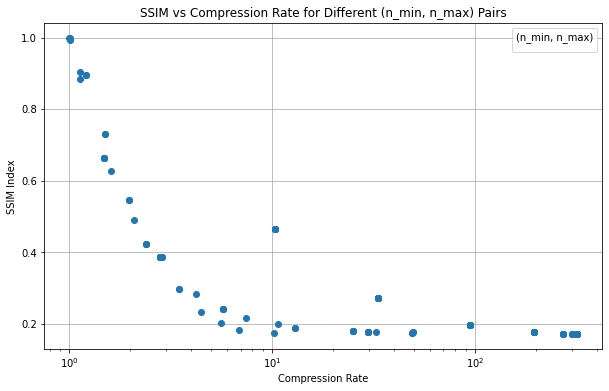

results for image  Mandrill_(a.k.a._Baboon)


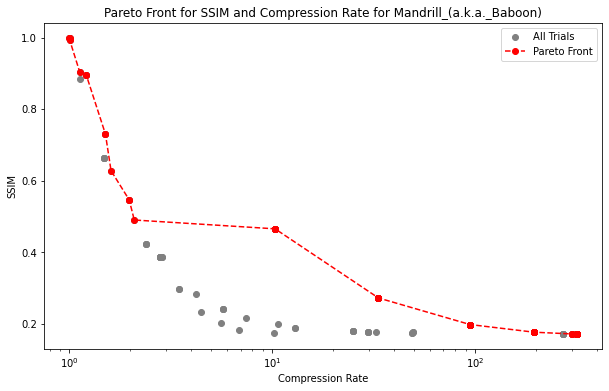

In [31]:
seed = 43
n_trials = 100

# search best hyperparameters of AQMP for each test image
for image_name in test_images:    
    # create study and begin to optimize
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    study_name = f"multiobjTPE_trials:{n_trials}_seed:{seed}_image:{image_name}_time:{current_time}"
    storage_path = "sqlite:///"+study_name+".db" 
    sampler = TPESampler(seed=seed)  # Make the sampler behave in a deterministic way
    study = optuna.create_study(directions=['maximize', 'maximize'], study_name=study_name, sampler=sampler)
    study.optimize(objective, n_trials=n_trials)

    plot_results(study, log_xscale=True)

In [47]:
name = "multiobjTPE_trials:100_seed:43_image:Clock_time:2024-11-01_09-14-32"
study = optuna.load_study(
    study_name = name,
    storage="sqlite:///"+name+".db"
)

In [50]:
study.trials_dataframe()

,number,values_0,values_1,datetime_start,datetime_complete,duration,params_exponent_a_cols,params_exponent_max_n,params_exponent_min_n,params_max_error,params_min_sparcity,user_attrs_compression_rate,user_attrs_execution_time,user_attrs_ssim,state
0,0,5.319064,0.603752,2024-11-01 09:14:33.514058,2024-11-01 09:14:33.852627,0 days 00:00:00.338569,3,5,5,0.027768,0.123904,5.319064,0.239926,0.603752,COMPLETE
1,1,4.114353,0.484083,2024-11-01 09:14:33.870519,2024-11-01 09:14:34.698788,0 days 00:00:00.828269,6,6,5,0.001493,0.860546,4.114353,0.744061,0.484083,COMPLETE
2,2,2.644592,0.586881,2024-11-01 09:14:34.721934,2024-11-01 09:14:35.939314,0 days 00:00:01.217380,7,6,6,0.002194,0.401001,2.644592,1.108739,0.586881,COMPLETE
3,3,1.560093,0.700546,2024-11-01 09:14:35.991769,2024-11-01 09:14:37.331884,0 days 00:00:01.340115,7,5,4,0.002884,0.228819,1.560093,1.145177,0.700546,COMPLETE
4,4,5.390260,0.587283,2024-11-01 09:14:37.359112,2024-11-01 09:14:42.189937,0 days 00:00:04.830825,8,7,7,0.205240,0.850450,5.390260,4.722713,0.587283,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,42.797695,0.563230,2024-11-01 09:17:56.723023,2024-11-01 09:17:57.441157,0 days 00:00:00.718134,1,7,7,27.653323,0.591873,42.797695,0.524108,0.563230,COMPLETE
96,96,38.821138,0.547838,2024-11-01 09:17:57.463853,2024-11-01 09:17:57.802065,0 days 00:00:00.338212,1,6,5,81.667937,0.753942,38.821138,0.210905,0.547838,COMPLETE
97,97,42.797695,0.563230,2024-11-01 09:17:57.823871,2024-11-01 09:17:58.296750,0 days 00:00:00.472879,1,7,6,6.391308,0.659906,42.797695,0.346700,0.563230,COMPLETE
98,98,15.403226,0.558752,2024-11-01 09:17:58.326893,2024-11-01 09:17:59.427261,0 days 00:00:01.100368,5,7,7,1.686103,0.712828,15.403226,0.949364,0.558752,COMPLETE


In [7]:
import pandas as pd
from scipy.stats import pearsonr

# Verifica que las columnas 'user_attrs_ssim' y 'user_attrs_compression_rate' existen y son numéricas
if 'user_attrs_ssim' in df.columns and 'user_attrs_compression_rate' in df.columns:
    metrics = ['user_attrs_ssim', 'user_attrs_compression_rate']
    correlations = {}

    for metric in metrics:
        correlations[metric] = {}
        for column in df.select_dtypes(include='number').columns:
            if column not in metrics:
                try:
                    corr, _ = pearsonr(df[column], df[metric])
                    correlations[metric][column] = corr
                except TypeError:
                    print(f"Column {column} or {metric} contains non-numeric values.")

    # Convierte el diccionario de correlaciones en un DataFrame para visualización
    correlations_df = pd.DataFrame(correlations)
    print(correlations_df)
else:
    print("Las columnas 'user_attrs_ssim' y 'user_attrs_compression_rate' no existen o no son numéricas.")


Column duration or user_attrs_ssim contains non-numeric values.
Column duration or user_attrs_compression_rate contains non-numeric values.
                           user_attrs_ssim  user_attrs_compression_rate
number                            0.302545                    -0.026497
values_0                         -0.589189                     1.000000
values_1                          1.000000                    -0.589189
params_exponent_a_cols            0.339103                    -0.530421
params_exponent_max_n            -0.805553                     0.601398
params_exponent_min_n            -0.677418                     0.544031
params_max_error                 -0.096131                     0.161032
params_min_sparcity               0.029707                    -0.050270
user_attrs_execution_time         0.787862                    -0.499986
